In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import math
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

np.random.seed(1)
tf.set_random_seed(1)
###########设置定义域范围
a = -np.pi / 2
b = np.pi / 2
# a = 0
# b = 5

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, layers_U, layers_V, x_range, f, num_train_tps):

        # Initialize NNs
        self.layers_U = layers_U
        self.weights_U, self.biases_U, self.adaps_U = self.initialize_NN(layers_U)
        self.layers_V = layers_V
        self.weights_V, self.biases_V, self.adaps_V = self.initialize_NN(layers_V)

        # Parameters
        self.x_range =x_range
        self.lb = np.array([ x_range[0]])
        self.ub = np.array([ x_range[1]])
        # Output file
        self.f = f
        # Coordinates of datapoints             #####################数据点坐标
        self.xx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        # Test Points                           ######################测试点
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # Generate Training and Testing Points  ########################生成训练和测试点
        self.generateTrain(num_train_tps)

        # Physics
        self.f, self.e, self.Uf, self.Vf,self.U_xf,self.V_xf,self.Ve= self.pinn(self.xf)
        self.f, self.e, self.Ui, self.Vi,_,_,_ = self.pinn(self.xi)
        self.f, self.e, self.Ue, self.Ve, _, _,_ = self.pinn(self.xe)
        self.f_test,  self.e_test, self.U_test, self.V_test,_,_,_= self.pinn(self.x_test_tf)

        # self.loss_f = tf.reduce_mean((tf.cos(self.xf) - self.xf + 1 / 4 * self.xf * self.Ve - self.U_xf ) ** 2)
        # self.loss_e = tf.reduce_mean((self.V_xf - self.Uf ** 2 * self.xf) ** 2)
        # self.loss_i= tf.reduce_mean((self.Ui) ** 2) + tf.reduce_mean((self.Vi) ** 2)

        # self.loss_f = tf.reduce_mean(abs(tf.cos(self.xf) - self.xf + 1 / 4 * self.xf * self.Ve - self.U_xf ))
        # self.loss_e = tf.reduce_mean(abs(self.V_xf - self.Uf ** 2 * self.xf) )
        # self.loss_i= tf.reduce_mean(abs(self.Ui) ) + tf.reduce_mean(abs(self.Vi) )
        #
        self.loss_f = tf.sqrt(tf.reduce_mean((tf.cos(self.xf) - self.xf + 1 / 4 * self.xf * self.Ve - self.U_xf ) ** 2))
        self.loss_e = tf.sqrt(tf.reduce_mean((self.V_xf - self.Uf ** 2 * self.xf) ** 2))
        self.loss_i= tf.sqrt(tf.reduce_mean((self.Ui) ** 2) + tf.reduce_mean((self.Vi) ** 2))

        # self.loss_f = tf.reduce_mean((self.U_xf + self.Uf - self.Vf) ** 2)
        # self.loss_e = tf.reduce_mean((self.V_xf - self.Uf + self.Vf) ** 2)
        # self.loss_i = tf.reduce_mean((self.Ui - 1) ** 2) + tf.reduce_mean((self.Vi) ** 2)
        # # Total Loss
        self.loss = self.loss_f *1+ self.loss_e*1 + self.loss_i * 1

        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)

#####################初始化神经网络参数
    def initialize_NN(self, layers):
        weights = []
        biases = []
        adaps = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            a = tf.Variable(1.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            adaps.append(a)
        return weights, biases, adaps

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def net_U(self, X):
        weights = self.weights_U
        biases = self.biases_U
        adaps = self.adaps_U
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(h, W), b)
        return U

    def net_V(self, X):
        weights = self.weights_V
        biases = self.biases_V
        adaps = self.adaps_V
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V = tf.add(tf.matmul(h, W), b)
        return V
    #
    def pinn(self,x):
        X=x
        # x=self.x_range[1] * tf.ones(x.shape)
        U = self.net_U(X)
        V = self.net_V(X)
        Ve = self.net_V(X)

        # Deformation Gradient     导数
        U_x = tf.gradients(U, x)  # du/dx
        V_x = tf.gradients(V,x)  # dv/dx
        f = tf.cos(x)- x+ 1 / 4 * x *Ve  -U_x
        e =V_x - U ** 2 * x
        return f, e,U,V, U_x , V_x,Ve

    def generateTrain(self, num_train_tps):
        xf = tf.linspace(np.float32(self.x_range[0]), np.float32(self.x_range[1]), num_train_tps)
        self.xf = tf.reshape(xf, [-1, 1])
        xi = self.x_range[0] * tf.ones(xf.shape)
        self.xi = tf.reshape(xi, [-1, 1])
        xe = self.x_range[1] * tf.ones(xf.shape)
        self.xe = tf.reshape(xe, [-1, 1])
        return

    def train(self, xx,  it, num_train_tps):
        xx = np.linspace(self.x_range[0], self.x_range[1],num_train_tps)
        xx = np.reshape(xx, [-1, 1])
        tf_dict = {self.xx_tf: xx}
        self.sess.run(self.train_op_Adam, tf_dict)

        loss_value, loss_value_f,loss_value_e,loss_value_i= self.sess.run(
            [self.loss, self.loss_f,self.loss_e,self.loss_i
             ], tf_dict)
        loss_value_array = [loss_value_f*1,loss_value_e*1,loss_value_i*1]
        np.set_printoptions(precision=6)
        content = 'It: %d, Loss: %.3e' % (it, loss_value) + '  Losses ILRUDrxIC:' + str(loss_value_array)
        print(content, flush=True)
        return loss_value, loss_value_array

    def test(self, num_test_tps):
        x = np.linspace(self.x_range[0], self.x_range[1], num_test_tps)
        x_test = np.reshape(x, [-1, 1])
        tf_dict = {self.x_test_tf: x_test}
        U_test = self.sess.run(self.U_test, tf_dict)
        V_test = self.sess.run(self.V_test, tf_dict)
        U_test_x = tf.gradients(U_test, x_test)  # du/dx
        V_test_x = tf.gradients(V_test, x_test)  # du/dx
        f_test = self.sess.run(self.f_test, tf_dict)
        e_test = self.sess.run(self.e_test, tf_dict)
        return x_test, U_test, V_test, f_test, e_test,U_test_x,V_test_x

It: 1, Loss: 1.202e+00  Losses ILRUDrxIC:[1.1502560377120972, 0.018436914309859276, 0.03334158658981323]
It: 2, Loss: 1.239e+00  Losses ILRUDrxIC:[1.1447304487228394, 0.025460410863161087, 0.0687943547964096]
It: 3, Loss: 1.251e+00  Losses ILRUDrxIC:[1.1322088241577148, 0.02748830057680607, 0.09113585948944092]
It: 4, Loss: 1.226e+00  Losses ILRUDrxIC:[1.1215388774871826, 0.015746209770441055, 0.08906687051057816]
It: 5, Loss: 1.194e+00  Losses ILRUDrxIC:[1.1149647235870361, 0.007488592062145472, 0.07132776081562042]
It: 6, Loss: 1.185e+00  Losses ILRUDrxIC:[1.114180564880371, 0.022034747526049614, 0.04888174682855606]
It: 7, Loss: 1.182e+00  Losses ILRUDrxIC:[1.1181640625, 0.03216540813446045, 0.031723879277706146]
It: 8, Loss: 1.186e+00  Losses ILRUDrxIC:[1.1242457628250122, 0.03324417024850845, 0.028992127627134323]
It: 9, Loss: 1.179e+00  Losses ILRUDrxIC:[1.1258066892623901, 0.026693131774663925, 0.02667008340358734]
It: 10, Loss: 1.158e+00  Losses ILRUDrxIC:[1.1223491430282593, 0

It: 79, Loss: 1.119e+00  Losses ILRUDrxIC:[1.0621036291122437, 0.053675275295972824, 0.003086445853114128]
It: 80, Loss: 1.124e+00  Losses ILRUDrxIC:[1.0581440925598145, 0.05637847259640694, 0.009713099338114262]
It: 81, Loss: 1.126e+00  Losses ILRUDrxIC:[1.057052731513977, 0.05631869286298752, 0.012379956431686878]
It: 82, Loss: 1.121e+00  Losses ILRUDrxIC:[1.0585906505584717, 0.054463841021060944, 0.008328952826559544]
It: 83, Loss: 1.122e+00  Losses ILRUDrxIC:[1.0617188215255737, 0.052725665271282196, 0.0071758488193154335]
It: 84, Loss: 1.123e+00  Losses ILRUDrxIC:[1.0620203018188477, 0.053771212697029114, 0.007205548696219921]
It: 85, Loss: 1.118e+00  Losses ILRUDrxIC:[1.059108853340149, 0.05592221021652222, 0.0033662552013993263]
It: 86, Loss: 1.121e+00  Losses ILRUDrxIC:[1.0578030347824097, 0.05459488928318024, 0.008592071011662483]
It: 87, Loss: 1.122e+00  Losses ILRUDrxIC:[1.0580567121505737, 0.05384334921836853, 0.010178760625422001]
It: 88, Loss: 1.118e+00  Losses ILRUDrxIC:

It: 156, Loss: 1.094e+00  Losses ILRUDrxIC:[1.0374714136123657, 0.053945526480674744, 0.0021724204998463392]
It: 157, Loss: 1.097e+00  Losses ILRUDrxIC:[1.034287691116333, 0.05410059913992882, 0.008658712729811668]
It: 158, Loss: 1.095e+00  Losses ILRUDrxIC:[1.033829689025879, 0.05415714532136917, 0.006766336504369974]
It: 159, Loss: 1.095e+00  Losses ILRUDrxIC:[1.0360513925552368, 0.05403038486838341, 0.0051455069333314896]
It: 160, Loss: 1.089e+00  Losses ILRUDrxIC:[1.0334434509277344, 0.05409224331378937, 0.0012414709199219942]
It: 161, Loss: 1.092e+00  Losses ILRUDrxIC:[1.034456491470337, 0.05272335186600685, 0.0044015985913574696]
It: 162, Loss: 1.091e+00  Losses ILRUDrxIC:[1.030263900756836, 0.0540897436439991, 0.006324575282633305]
It: 163, Loss: 1.088e+00  Losses ILRUDrxIC:[1.0298442840576172, 0.05391650274395943, 0.004440151620656252]
It: 164, Loss: 1.093e+00  Losses ILRUDrxIC:[1.0331134796142578, 0.051927581429481506, 0.008341451175510883]
It: 165, Loss: 1.087e+00  Losses ILR

It: 233, Loss: 8.829e-01  Losses ILRUDrxIC:[0.8285092115402222, 0.049871765077114105, 0.004553712904453278]
It: 234, Loss: 8.831e-01  Losses ILRUDrxIC:[0.8297025561332703, 0.04537312686443329, 0.008062967099249363]
It: 235, Loss: 8.801e-01  Losses ILRUDrxIC:[0.8189018368721008, 0.04827311262488365, 0.012968541122972965]
It: 236, Loss: 8.772e-01  Losses ILRUDrxIC:[0.8147671818733215, 0.05064671114087105, 0.011804938316345215]
It: 237, Loss: 8.736e-01  Losses ILRUDrxIC:[0.8186250329017639, 0.050406936556100845, 0.004553317092359066]
It: 238, Loss: 8.757e-01  Losses ILRUDrxIC:[0.8100237846374512, 0.04990058019757271, 0.015788044780492783]
It: 239, Loss: 8.752e-01  Losses ILRUDrxIC:[0.8051983714103699, 0.051968157291412354, 0.018021024763584137]
It: 240, Loss: 8.614e-01  Losses ILRUDrxIC:[0.8054314851760864, 0.05265799164772034, 0.003326629288494587]
It: 241, Loss: 8.925e-01  Losses ILRUDrxIC:[0.8130300045013428, 0.05660858005285263, 0.022909468039870262]
It: 242, Loss: 8.675e-01  Losses I

It: 310, Loss: 7.774e-01  Losses ILRUDrxIC:[0.6941272616386414, 0.07455688714981079, 0.00868619792163372]
It: 311, Loss: 7.804e-01  Losses ILRUDrxIC:[0.6948279738426208, 0.07802817970514297, 0.007580925244837999]
It: 312, Loss: 7.774e-01  Losses ILRUDrxIC:[0.678864061832428, 0.07838509231805801, 0.02019280567765236]
It: 313, Loss: 7.843e-01  Losses ILRUDrxIC:[0.6709631085395813, 0.08324450254440308, 0.030047526583075523]
It: 314, Loss: 7.761e-01  Losses ILRUDrxIC:[0.6723865270614624, 0.0829348936676979, 0.020773159340023994]
It: 315, Loss: 7.674e-01  Losses ILRUDrxIC:[0.6821274161338806, 0.07972622662782669, 0.005572188179939985]
It: 316, Loss: 7.678e-01  Losses ILRUDrxIC:[0.6801800727844238, 0.07795102894306183, 0.009674080647528172]
It: 317, Loss: 7.659e-01  Losses ILRUDrxIC:[0.6721495985984802, 0.08176679164171219, 0.012025173753499985]
It: 318, Loss: 7.633e-01  Losses ILRUDrxIC:[0.6728431582450867, 0.0808662548661232, 0.009598624892532825]
It: 319, Loss: 7.687e-01  Losses ILRUDrxIC

It: 388, Loss: 6.707e-01  Losses ILRUDrxIC:[0.5730088949203491, 0.04308255761861801, 0.05460851266980171]
It: 389, Loss: 6.694e-01  Losses ILRUDrxIC:[0.5898227095603943, 0.042039912194013596, 0.03751545399427414]
It: 390, Loss: 6.371e-01  Losses ILRUDrxIC:[0.5859983563423157, 0.03960178792476654, 0.01146134827286005]
It: 391, Loss: 6.469e-01  Losses ILRUDrxIC:[0.5549375414848328, 0.0592736080288887, 0.03268701583147049]
It: 392, Loss: 6.697e-01  Losses ILRUDrxIC:[0.5403481721878052, 0.08785188943147659, 0.04147070646286011]
It: 393, Loss: 6.419e-01  Losses ILRUDrxIC:[0.5445693731307983, 0.07225129753351212, 0.025080958381295204]
It: 394, Loss: 6.197e-01  Losses ILRUDrxIC:[0.5662800669670105, 0.03622930496931076, 0.017210152000188828]
It: 395, Loss: 6.426e-01  Losses ILRUDrxIC:[0.573654055595398, 0.05110107734799385, 0.017821308225393295]
It: 396, Loss: 6.135e-01  Losses ILRUDrxIC:[0.5532858371734619, 0.03964449092745781, 0.02059694193303585]
It: 397, Loss: 6.288e-01  Losses ILRUDrxIC:[

It: 465, Loss: 4.869e-01  Losses ILRUDrxIC:[0.4054398238658905, 0.04343204200267792, 0.03800201416015625]
It: 466, Loss: 4.714e-01  Losses ILRUDrxIC:[0.4250277876853943, 0.04542193189263344, 0.000968762265983969]
It: 467, Loss: 4.536e-01  Losses ILRUDrxIC:[0.41494277119636536, 0.029059529304504395, 0.009599262848496437]
It: 468, Loss: 4.636e-01  Losses ILRUDrxIC:[0.40805700421333313, 0.046150658279657364, 0.009409003891050816]
It: 469, Loss: 4.770e-01  Losses ILRUDrxIC:[0.415668785572052, 0.03620035573840141, 0.025124287232756615]
It: 470, Loss: 4.649e-01  Losses ILRUDrxIC:[0.41770750284194946, 0.02877959795296192, 0.018368609249591827]
It: 471, Loss: 4.698e-01  Losses ILRUDrxIC:[0.4043518602848053, 0.034058403223752975, 0.03134822100400925]
It: 472, Loss: 4.690e-01  Losses ILRUDrxIC:[0.4018406867980957, 0.0313408188521862, 0.03579491749405861]
It: 473, Loss: 4.701e-01  Losses ILRUDrxIC:[0.40153825283050537, 0.037676528096199036, 0.030839156359434128]
It: 474, Loss: 4.552e-01  Losses I

It: 542, Loss: 3.579e-01  Losses ILRUDrxIC:[0.29973164200782776, 0.039220429956912994, 0.01891029067337513]
It: 543, Loss: 3.745e-01  Losses ILRUDrxIC:[0.296955406665802, 0.04888145625591278, 0.02864501252770424]
It: 544, Loss: 3.584e-01  Losses ILRUDrxIC:[0.303132563829422, 0.03104119747877121, 0.024251943454146385]
It: 545, Loss: 3.522e-01  Losses ILRUDrxIC:[0.29739826917648315, 0.035630401223897934, 0.019161609932780266]
It: 546, Loss: 3.567e-01  Losses ILRUDrxIC:[0.284778892993927, 0.046863507479429245, 0.025066236034035683]
It: 547, Loss: 3.398e-01  Losses ILRUDrxIC:[0.28842926025390625, 0.04315446317195892, 0.00823253020644188]
It: 548, Loss: 3.787e-01  Losses ILRUDrxIC:[0.3066715896129608, 0.04461883008480072, 0.027433497831225395]
It: 549, Loss: 3.429e-01  Losses ILRUDrxIC:[0.2971915006637573, 0.02950986847281456, 0.016179870814085007]
It: 550, Loss: 3.668e-01  Losses ILRUDrxIC:[0.27605417370796204, 0.06592642515897751, 0.024834003299474716]
It: 551, Loss: 3.584e-01  Losses ILR

It: 619, Loss: 2.616e-01  Losses ILRUDrxIC:[0.20976659655570984, 0.03399420529603958, 0.017835265025496483]
It: 620, Loss: 2.671e-01  Losses ILRUDrxIC:[0.22081570327281952, 0.03030441142618656, 0.015964604914188385]
It: 621, Loss: 2.563e-01  Losses ILRUDrxIC:[0.21564731001853943, 0.032712455838918686, 0.007931261323392391]
It: 622, Loss: 2.728e-01  Losses ILRUDrxIC:[0.20445604622364044, 0.035806361585855484, 0.03252667188644409]
It: 623, Loss: 2.758e-01  Losses ILRUDrxIC:[0.20182958245277405, 0.036154597997665405, 0.037814944982528687]
It: 624, Loss: 2.676e-01  Losses ILRUDrxIC:[0.20001472532749176, 0.033419299870729446, 0.034211255609989166]
It: 625, Loss: 2.682e-01  Losses ILRUDrxIC:[0.20466309785842896, 0.03171807527542114, 0.03180499002337456]
It: 626, Loss: 2.475e-01  Losses ILRUDrxIC:[0.21194234490394592, 0.031711407005786896, 0.0038796216249465942]
It: 627, Loss: 2.975e-01  Losses ILRUDrxIC:[0.20708249509334564, 0.037168316543102264, 0.0532168410718441]
It: 628, Loss: 3.075e-01 

It: 771, Loss: 1.252e-01  Losses ILRUDrxIC:[0.0816643089056015, 0.03022214211523533, 0.013348480686545372]
It: 772, Loss: 1.502e-01  Losses ILRUDrxIC:[0.09043791890144348, 0.053962770849466324, 0.005758856888860464]
It: 773, Loss: 1.472e-01  Losses ILRUDrxIC:[0.08225275576114655, 0.026713000610470772, 0.038235392421483994]
It: 774, Loss: 1.755e-01  Losses ILRUDrxIC:[0.07387949526309967, 0.0558629035949707, 0.045726608484983444]
It: 775, Loss: 1.222e-01  Losses ILRUDrxIC:[0.07733120769262314, 0.024841342121362686, 0.020036881789565086]
It: 776, Loss: 1.867e-01  Losses ILRUDrxIC:[0.08844473958015442, 0.060855306684970856, 0.03743765503168106]
It: 777, Loss: 1.458e-01  Losses ILRUDrxIC:[0.08183081448078156, 0.023190753534436226, 0.04082561656832695]
It: 778, Loss: 1.621e-01  Losses ILRUDrxIC:[0.07287075370550156, 0.07476969808340073, 0.014423740096390247]
It: 779, Loss: 1.642e-01  Losses ILRUDrxIC:[0.07828523963689804, 0.05290418118238449, 0.032961949706077576]
It: 780, Loss: 1.889e-01  L

It: 847, Loss: 8.984e-02  Losses ILRUDrxIC:[0.05996692553162575, 0.020097387954592705, 0.0097751310095191]
It: 848, Loss: 1.194e-01  Losses ILRUDrxIC:[0.05925464630126953, 0.02900484763085842, 0.031143493950366974]
It: 849, Loss: 1.394e-01  Losses ILRUDrxIC:[0.04852054640650749, 0.04771587625145912, 0.04313810542225838]
It: 850, Loss: 1.014e-01  Losses ILRUDrxIC:[0.04880321025848389, 0.02334505319595337, 0.029262518510222435]
It: 851, Loss: 1.516e-01  Losses ILRUDrxIC:[0.0576898455619812, 0.0657019168138504, 0.02825348637998104]
It: 852, Loss: 1.173e-01  Losses ILRUDrxIC:[0.05567960813641548, 0.029754864051938057, 0.03186679258942604]
It: 853, Loss: 1.666e-01  Losses ILRUDrxIC:[0.04721337929368019, 0.10605844110250473, 0.013367061503231525]
It: 854, Loss: 1.969e-01  Losses ILRUDrxIC:[0.0503237284719944, 0.12351612746715546, 0.02301597222685814]
It: 855, Loss: 1.301e-01  Losses ILRUDrxIC:[0.05835552141070366, 0.047154031693935394, 0.024632088840007782]
It: 856, Loss: 1.948e-01  Losses I

It: 924, Loss: 1.231e-01  Losses ILRUDrxIC:[0.03512593358755112, 0.03985433280467987, 0.04816615208983421]
It: 925, Loss: 1.281e-01  Losses ILRUDrxIC:[0.044400136917829514, 0.059829603880643845, 0.023866141214966774]
It: 926, Loss: 1.267e-01  Losses ILRUDrxIC:[0.05149950459599495, 0.0603523813188076, 0.014824829064309597]
It: 927, Loss: 1.154e-01  Losses ILRUDrxIC:[0.047555748373270035, 0.05353312939405441, 0.014298652298748493]
It: 928, Loss: 1.250e-01  Losses ILRUDrxIC:[0.04292726889252663, 0.07318802177906036, 0.008850479498505592]
It: 929, Loss: 8.661e-02  Losses ILRUDrxIC:[0.04244779422879219, 0.022194264456629753, 0.021965060383081436]
It: 930, Loss: 1.623e-01  Losses ILRUDrxIC:[0.04990146681666374, 0.08269134163856506, 0.029734475538134575]
It: 931, Loss: 1.469e-01  Losses ILRUDrxIC:[0.04925694689154625, 0.08082134276628494, 0.016797754913568497]
It: 932, Loss: 1.018e-01  Losses ILRUDrxIC:[0.04284389317035675, 0.029389675706624985, 0.029558129608631134]
It: 933, Loss: 1.411e-01 

It: 1000, Loss: 6.342e-02  Losses ILRUDrxIC:[0.038167014718055725, 0.013319435529410839, 0.01193094253540039]
It: 1001, Loss: 6.994e-02  Losses ILRUDrxIC:[0.03832054138183594, 0.018423158675432205, 0.013192706741392612]
It: 1002, Loss: 7.747e-02  Losses ILRUDrxIC:[0.0365137942135334, 0.033484362065792084, 0.007474740967154503]
It: 1003, Loss: 7.472e-02  Losses ILRUDrxIC:[0.04202696681022644, 0.016672860831022263, 0.016016105189919472]
It: 1004, Loss: 6.216e-02  Losses ILRUDrxIC:[0.040801722556352615, 0.013732600957155228, 0.007624687626957893]
It: 1005, Loss: 1.052e-01  Losses ILRUDrxIC:[0.03306800127029419, 0.04650725796818733, 0.0256061851978302]
It: 1006, Loss: 9.122e-02  Losses ILRUDrxIC:[0.03363234922289848, 0.0270601324737072, 0.03053097426891327]
It: 1007, Loss: 1.067e-01  Losses ILRUDrxIC:[0.039231762290000916, 0.053132012486457825, 0.01435434352606535]
It: 1008, Loss: 8.025e-02  Losses ILRUDrxIC:[0.04167116805911064, 0.030017217621207237, 0.008561195805668831]
It: 1009, Loss: 

It: 1075, Loss: 9.069e-02  Losses ILRUDrxIC:[0.03421196714043617, 0.03518536686897278, 0.02129078470170498]
It: 1076, Loss: 1.021e-01  Losses ILRUDrxIC:[0.03219130262732506, 0.03470127284526825, 0.03523465245962143]
It: 1077, Loss: 9.963e-02  Losses ILRUDrxIC:[0.029413677752017975, 0.03450074419379234, 0.035716038197278976]
It: 1078, Loss: 6.193e-02  Losses ILRUDrxIC:[0.030898088589310646, 0.016706760972738266, 0.014322896488010883]
It: 1079, Loss: 1.319e-01  Losses ILRUDrxIC:[0.041306160390377045, 0.06218289956450462, 0.028440020978450775]
It: 1080, Loss: 1.163e-01  Losses ILRUDrxIC:[0.04136229678988457, 0.04358278214931488, 0.03132398799061775]
It: 1081, Loss: 9.911e-02  Losses ILRUDrxIC:[0.03190469369292259, 0.061925143003463745, 0.00528306607156992]
It: 1082, Loss: 1.449e-01  Losses ILRUDrxIC:[0.029124494642019272, 0.08631444722414017, 0.029507486149668694]
It: 1083, Loss: 9.639e-02  Losses ILRUDrxIC:[0.029329365119338036, 0.0318932980298996, 0.03517177700996399]
It: 1084, Loss: 1.

It: 1150, Loss: 7.589e-02  Losses ILRUDrxIC:[0.02662959322333336, 0.038772329688072205, 0.010489932261407375]
It: 1151, Loss: 9.868e-02  Losses ILRUDrxIC:[0.0355815663933754, 0.05176296457648277, 0.011332484893500805]
It: 1152, Loss: 8.637e-02  Losses ILRUDrxIC:[0.033452264964580536, 0.04921916872262955, 0.0036982449237257242]
It: 1153, Loss: 9.306e-02  Losses ILRUDrxIC:[0.025645507499575615, 0.037730906158685684, 0.02967873029410839]
It: 1154, Loss: 1.021e-01  Losses ILRUDrxIC:[0.02563740871846676, 0.041450999677181244, 0.035016778856515884]
It: 1155, Loss: 7.629e-02  Losses ILRUDrxIC:[0.028820784762501717, 0.03178901597857475, 0.015682842582464218]
It: 1156, Loss: 7.414e-02  Losses ILRUDrxIC:[0.032294657081365585, 0.029741887003183365, 0.012101244181394577]
It: 1157, Loss: 8.983e-02  Losses ILRUDrxIC:[0.028481069952249527, 0.053208936005830765, 0.008135566487908363]
It: 1158, Loss: 9.922e-02  Losses ILRUDrxIC:[0.02656596153974533, 0.06518077105283737, 0.00747405830770731]
It: 1159, L

It: 1225, Loss: 7.571e-02  Losses ILRUDrxIC:[0.025119706988334656, 0.024976123124361038, 0.025609882548451424]
It: 1226, Loss: 6.713e-02  Losses ILRUDrxIC:[0.027232708409428596, 0.012786943465471268, 0.027113985270261765]
It: 1227, Loss: 5.987e-02  Losses ILRUDrxIC:[0.028733935207128525, 0.019703229889273643, 0.011430996470153332]
It: 1228, Loss: 7.682e-02  Losses ILRUDrxIC:[0.023861819878220558, 0.03304231911897659, 0.019920075312256813]
It: 1229, Loss: 7.331e-02  Losses ILRUDrxIC:[0.023461850360035896, 0.01868739351630211, 0.031162502244114876]
It: 1230, Loss: 1.060e-01  Losses ILRUDrxIC:[0.02696750871837139, 0.05359651893377304, 0.025398800149559975]
It: 1231, Loss: 7.951e-02  Losses ILRUDrxIC:[0.026610909029841423, 0.043785467743873596, 0.009113476611673832]
It: 1232, Loss: 8.277e-02  Losses ILRUDrxIC:[0.023718461394309998, 0.034536100924015045, 0.024513239040970802]
It: 1233, Loss: 8.129e-02  Losses ILRUDrxIC:[0.024617722257971764, 0.03637426346540451, 0.020300574600696564]
It: 12

It: 1300, Loss: 9.132e-02  Losses ILRUDrxIC:[0.02387196384370327, 0.05473519489169121, 0.012716255150735378]
It: 1301, Loss: 1.140e-01  Losses ILRUDrxIC:[0.033528052270412445, 0.050227195024490356, 0.03024820052087307]
It: 1302, Loss: 1.170e-01  Losses ILRUDrxIC:[0.032946426421403885, 0.06080605834722519, 0.0232864823192358]
It: 1303, Loss: 5.139e-02  Losses ILRUDrxIC:[0.02325151488184929, 0.01353063341230154, 0.014605733565986156]
It: 1304, Loss: 9.717e-02  Losses ILRUDrxIC:[0.021001093089580536, 0.04944165050983429, 0.02672230638563633]
It: 1305, Loss: 6.399e-02  Losses ILRUDrxIC:[0.02128930576145649, 0.02358952723443508, 0.01911023072898388]
It: 1306, Loss: 1.066e-01  Losses ILRUDrxIC:[0.03103109821677208, 0.06356993317604065, 0.012002691626548767]
It: 1307, Loss: 1.097e-01  Losses ILRUDrxIC:[0.029636772349476814, 0.06638909876346588, 0.013713918626308441]
It: 1308, Loss: 4.815e-02  Losses ILRUDrxIC:[0.022210324183106422, 0.012326600961387157, 0.01361778937280178]
It: 1309, Loss: 8.

It: 1375, Loss: 5.007e-02  Losses ILRUDrxIC:[0.021937254816293716, 0.01704799011349678, 0.011083550751209259]
It: 1376, Loss: 5.044e-02  Losses ILRUDrxIC:[0.02150179073214531, 0.015183092094957829, 0.013755728490650654]
It: 1377, Loss: 4.386e-02  Losses ILRUDrxIC:[0.02319854125380516, 0.015294895507395267, 0.00536899920552969]
It: 1378, Loss: 5.260e-02  Losses ILRUDrxIC:[0.02097911387681961, 0.029065145179629326, 0.0025510075502097607]
It: 1379, Loss: 4.690e-02  Losses ILRUDrxIC:[0.024316633120179176, 0.010331614874303341, 0.012254368513822556]
It: 1380, Loss: 7.715e-02  Losses ILRUDrxIC:[0.02734178863465786, 0.03896140307188034, 0.010844368487596512]
It: 1381, Loss: 4.587e-02  Losses ILRUDrxIC:[0.020932257175445557, 0.011265737004578114, 0.013667983002960682]
It: 1382, Loss: 1.093e-01  Losses ILRUDrxIC:[0.02120276913046837, 0.06378237903118134, 0.02426547184586525]
It: 1383, Loss: 9.449e-02  Losses ILRUDrxIC:[0.02035149745643139, 0.06140271574258804, 0.012734202668070793]
It: 1384, Lo

It: 1450, Loss: 3.683e-02  Losses ILRUDrxIC:[0.020399531349539757, 0.00692698685452342, 0.009498890489339828]
It: 1451, Loss: 5.362e-02  Losses ILRUDrxIC:[0.022038526833057404, 0.026826107874512672, 0.004758148919790983]
It: 1452, Loss: 6.301e-02  Losses ILRUDrxIC:[0.019979942589998245, 0.02318037487566471, 0.01985001564025879]
It: 1453, Loss: 5.890e-02  Losses ILRUDrxIC:[0.01988176442682743, 0.01832645572721958, 0.020692825317382812]
It: 1454, Loss: 5.672e-02  Losses ILRUDrxIC:[0.021872252225875854, 0.03001624159514904, 0.004836425185203552]
It: 1455, Loss: 4.806e-02  Losses ILRUDrxIC:[0.02218903973698616, 0.012465775944292545, 0.013403364457190037]
It: 1456, Loss: 8.129e-02  Losses ILRUDrxIC:[0.019935403019189835, 0.056106626987457275, 0.005249443929642439]
It: 1457, Loss: 9.216e-02  Losses ILRUDrxIC:[0.01924191042780876, 0.06032968685030937, 0.012592630460858345]
It: 1458, Loss: 3.322e-02  Losses ILRUDrxIC:[0.020757514983415604, 0.0066113462671637535, 0.005851013585925102]
It: 1459,

It: 1525, Loss: 1.148e-01  Losses ILRUDrxIC:[0.028439726680517197, 0.07847976684570312, 0.007921137847006321]
It: 1526, Loss: 7.126e-02  Losses ILRUDrxIC:[0.019442887976765633, 0.03195676580071449, 0.019859392195940018]
It: 1527, Loss: 1.230e-01  Losses ILRUDrxIC:[0.022618122398853302, 0.06599094718694687, 0.03437675163149834]
It: 1528, Loss: 1.373e-01  Losses ILRUDrxIC:[0.022946136072278023, 0.08767277002334595, 0.026684079319238663]
It: 1529, Loss: 6.739e-02  Losses ILRUDrxIC:[0.01948535442352295, 0.043332453817129135, 0.004576801788061857]
It: 1530, Loss: 1.063e-01  Losses ILRUDrxIC:[0.03096820041537285, 0.05050358176231384, 0.024846157059073448]
It: 1531, Loss: 1.266e-01  Losses ILRUDrxIC:[0.03346899524331093, 0.06718935072422028, 0.025953812524676323]
It: 1532, Loss: 5.977e-02  Losses ILRUDrxIC:[0.02373194321990013, 0.020147353410720825, 0.015886932611465454]
It: 1533, Loss: 1.267e-01  Losses ILRUDrxIC:[0.019728880375623703, 0.07910368591547012, 0.027897201478481293]
It: 1534, Los

It: 1600, Loss: 1.011e-01  Losses ILRUDrxIC:[0.01759973354637623, 0.07069727778434753, 0.012806291691958904]
It: 1601, Loss: 7.263e-02  Losses ILRUDrxIC:[0.026177017018198967, 0.02447223849594593, 0.021980449557304382]
It: 1602, Loss: 9.950e-02  Losses ILRUDrxIC:[0.026914842426776886, 0.04636511951684952, 0.026218300685286522]
It: 1603, Loss: 4.356e-02  Losses ILRUDrxIC:[0.01934433914721012, 0.007452717516571283, 0.016767075285315514]
It: 1604, Loss: 1.139e-01  Losses ILRUDrxIC:[0.01844649948179722, 0.07289840281009674, 0.022533953189849854]
It: 1605, Loss: 1.260e-01  Losses ILRUDrxIC:[0.018445855006575584, 0.08179053664207458, 0.025721516460180283]
It: 1606, Loss: 6.427e-02  Losses ILRUDrxIC:[0.01915046200156212, 0.030004847794771194, 0.015111113898456097]
It: 1607, Loss: 1.192e-01  Losses ILRUDrxIC:[0.03013918548822403, 0.06991078704595566, 0.019105425104498863]
It: 1608, Loss: 1.467e-01  Losses ILRUDrxIC:[0.030666658654808998, 0.09319735318422318, 0.022799598053097725]
It: 1609, Los

It: 1675, Loss: 9.874e-02  Losses ILRUDrxIC:[0.026515355333685875, 0.0658983662724495, 0.0063295490108430386]
It: 1676, Loss: 1.181e-01  Losses ILRUDrxIC:[0.023877494037151337, 0.07843796908855438, 0.015742072835564613]
It: 1677, Loss: 8.343e-02  Losses ILRUDrxIC:[0.01887834444642067, 0.039121098816394806, 0.02542831189930439]
It: 1678, Loss: 9.092e-02  Losses ILRUDrxIC:[0.01864330843091011, 0.0478682667016983, 0.024408545345067978]
It: 1679, Loss: 9.151e-02  Losses ILRUDrxIC:[0.019366269931197166, 0.06665066629648209, 0.005495744291692972]
It: 1680, Loss: 8.370e-02  Losses ILRUDrxIC:[0.02413974516093731, 0.03173822537064552, 0.02782271057367325]
It: 1681, Loss: 1.213e-01  Losses ILRUDrxIC:[0.03346152976155281, 0.04628389701247215, 0.0415685698390007]
It: 1682, Loss: 1.148e-01  Losses ILRUDrxIC:[0.03145850822329521, 0.052102748304605484, 0.031245846301317215]
It: 1683, Loss: 3.543e-02  Losses ILRUDrxIC:[0.019873930141329765, 0.011306525208055973, 0.004250829573720694]
It: 1684, Loss: 9

It: 1750, Loss: 5.019e-02  Losses ILRUDrxIC:[0.022335544228553772, 0.013507951982319355, 0.01434177067130804]
It: 1751, Loss: 6.684e-02  Losses ILRUDrxIC:[0.018308093771338463, 0.04228051379323006, 0.006249559111893177]
It: 1752, Loss: 7.789e-02  Losses ILRUDrxIC:[0.017594531178474426, 0.0451948419213295, 0.015096290037035942]
It: 1753, Loss: 4.481e-02  Losses ILRUDrxIC:[0.017295021563768387, 0.009285975247621536, 0.01822883076965809]
It: 1754, Loss: 4.569e-02  Losses ILRUDrxIC:[0.018725937232375145, 0.02155368961393833, 0.005405906587839127]
It: 1755, Loss: 6.047e-02  Losses ILRUDrxIC:[0.01944611221551895, 0.023033052682876587, 0.017995325848460197]
It: 1756, Loss: 6.030e-02  Losses ILRUDrxIC:[0.020039355382323265, 0.020640848204493523, 0.019621102139353752]
It: 1757, Loss: 4.507e-02  Losses ILRUDrxIC:[0.02102285996079445, 0.01995404250919819, 0.0040970453992486]
It: 1758, Loss: 6.134e-02  Losses ILRUDrxIC:[0.01771438494324684, 0.01909734308719635, 0.024524955078959465]
It: 1759, Loss

It: 1825, Loss: 8.698e-02  Losses ILRUDrxIC:[0.016376305371522903, 0.05199261009693146, 0.018611261621117592]
It: 1826, Loss: 2.837e-02  Losses ILRUDrxIC:[0.017834866419434547, 0.0076393247582018375, 0.0028932513669133186]
It: 1827, Loss: 5.900e-02  Losses ILRUDrxIC:[0.022223783656954765, 0.01842457242310047, 0.018352622166275978]
It: 1828, Loss: 6.385e-02  Losses ILRUDrxIC:[0.01859147474169731, 0.02958102338016033, 0.01567341759800911]
It: 1829, Loss: 4.784e-02  Losses ILRUDrxIC:[0.016700584441423416, 0.029345698654651642, 0.0017913823248818517]
It: 1830, Loss: 5.603e-02  Losses ILRUDrxIC:[0.017804143950343132, 0.018807070329785347, 0.019421609118580818]
It: 1831, Loss: 6.363e-02  Losses ILRUDrxIC:[0.017330680042505264, 0.0194696132093668, 0.026825888082385063]
It: 1832, Loss: 6.166e-02  Losses ILRUDrxIC:[0.01612704060971737, 0.023500530049204826, 0.022031033411622047]
It: 1833, Loss: 3.098e-02  Losses ILRUDrxIC:[0.01768588088452816, 0.011635735630989075, 0.0016582075040787458]
It: 18

It: 1900, Loss: 5.087e-02  Losses ILRUDrxIC:[0.017860719934105873, 0.016528021544218063, 0.01648465171456337]
It: 1901, Loss: 6.139e-02  Losses ILRUDrxIC:[0.017223037779331207, 0.02214566059410572, 0.022018257528543472]
It: 1902, Loss: 4.478e-02  Losses ILRUDrxIC:[0.016328807920217514, 0.014056001789867878, 0.014395562000572681]
It: 1903, Loss: 3.596e-02  Losses ILRUDrxIC:[0.017406214028596878, 0.008629770949482918, 0.009922683238983154]
It: 1904, Loss: 5.408e-02  Losses ILRUDrxIC:[0.018045593053102493, 0.023425228893756866, 0.012614003382623196]
It: 1905, Loss: 3.952e-02  Losses ILRUDrxIC:[0.018659302964806557, 0.010483155958354473, 0.01037362590432167]
It: 1906, Loss: 5.051e-02  Losses ILRUDrxIC:[0.01768594980239868, 0.021354667842388153, 0.011468869633972645]
It: 1907, Loss: 4.781e-02  Losses ILRUDrxIC:[0.01630612649023533, 0.01135848369449377, 0.020146051421761513]
It: 1908, Loss: 3.071e-02  Losses ILRUDrxIC:[0.016057725995779037, 0.0043298727832734585, 0.010321502573788166]
It: 19

It: 1975, Loss: 7.204e-02  Losses ILRUDrxIC:[0.020567385479807854, 0.02450047992169857, 0.026970138773322105]
It: 1976, Loss: 5.602e-02  Losses ILRUDrxIC:[0.017797663807868958, 0.024720316752791405, 0.013502844609320164]
It: 1977, Loss: 5.670e-02  Losses ILRUDrxIC:[0.01601994037628174, 0.02494163066148758, 0.01573830656707287]
It: 1978, Loss: 6.461e-02  Losses ILRUDrxIC:[0.015802135691046715, 0.0307332631200552, 0.01807277277112007]
It: 1979, Loss: 6.483e-02  Losses ILRUDrxIC:[0.015731584280729294, 0.031387560069561005, 0.01770917885005474]
It: 1980, Loss: 4.409e-02  Losses ILRUDrxIC:[0.015332268550992012, 0.01565343700349331, 0.013099318370223045]
It: 1981, Loss: 3.777e-02  Losses ILRUDrxIC:[0.016947150230407715, 0.007030845619738102, 0.013789718970656395]
It: 1982, Loss: 7.797e-02  Losses ILRUDrxIC:[0.02238004095852375, 0.036803752183914185, 0.01878429390490055]
It: 1983, Loss: 4.637e-02  Losses ILRUDrxIC:[0.018833432346582413, 0.018731173127889633, 0.008808563463389874]
It: 1984, Lo

It: 2050, Loss: 1.411e-01  Losses ILRUDrxIC:[0.02705126814544201, 0.09234872460365295, 0.02174489200115204]
It: 2051, Loss: 8.521e-02  Losses ILRUDrxIC:[0.018748078495264053, 0.05613628774881363, 0.010328928008675575]
It: 2052, Loss: 7.433e-02  Losses ILRUDrxIC:[0.015575219877064228, 0.034403905272483826, 0.02434712089598179]
It: 2053, Loss: 1.067e-01  Losses ILRUDrxIC:[0.016997968778014183, 0.059836942702531815, 0.02982190251350403]
It: 2054, Loss: 5.811e-02  Losses ILRUDrxIC:[0.014575150795280933, 0.026249097660183907, 0.0172890592366457]
It: 2055, Loss: 9.460e-02  Losses ILRUDrxIC:[0.023532461374998093, 0.056389257311820984, 0.014678426086902618]
It: 2056, Loss: 1.174e-01  Losses ILRUDrxIC:[0.025237945839762688, 0.07132690399885178, 0.020882798358798027]
It: 2057, Loss: 5.464e-02  Losses ILRUDrxIC:[0.01741642691195011, 0.025706924498081207, 0.011516558937728405]
It: 2058, Loss: 1.095e-01  Losses ILRUDrxIC:[0.016401788219809532, 0.07219012826681137, 0.020877733826637268]
It: 2059, Lo

It: 2125, Loss: 4.606e-02  Losses ILRUDrxIC:[0.014939352869987488, 0.021103497594594955, 0.010016761720180511]
It: 2126, Loss: 3.889e-02  Losses ILRUDrxIC:[0.015450408682227135, 0.011490624397993088, 0.011945672333240509]
It: 2127, Loss: 3.489e-02  Losses ILRUDrxIC:[0.01640038751065731, 0.004970157984644175, 0.013517724350094795]
It: 2128, Loss: 4.691e-02  Losses ILRUDrxIC:[0.014524711295962334, 0.02939349226653576, 0.0029874122701585293]
It: 2129, Loss: 5.388e-02  Losses ILRUDrxIC:[0.014348166063427925, 0.018545927479863167, 0.02098776586353779]
It: 2130, Loss: 7.448e-02  Losses ILRUDrxIC:[0.015631482005119324, 0.0303517933934927, 0.028500700369477272]
It: 2131, Loss: 4.539e-02  Losses ILRUDrxIC:[0.014475022442638874, 0.011436051689088345, 0.019482165575027466]
It: 2132, Loss: 8.041e-02  Losses ILRUDrxIC:[0.015138272196054459, 0.056553054600954056, 0.008715467527508736]
It: 2133, Loss: 9.289e-02  Losses ILRUDrxIC:[0.014858937822282314, 0.06161622703075409, 0.016418805345892906]
It: 21

It: 2200, Loss: 6.069e-02  Losses ILRUDrxIC:[0.013974233530461788, 0.03341112658381462, 0.013304264284670353]
It: 2201, Loss: 5.421e-02  Losses ILRUDrxIC:[0.01822347193956375, 0.026363123208284378, 0.009626738727092743]
It: 2202, Loss: 5.012e-02  Losses ILRUDrxIC:[0.018491005524992943, 0.02126453071832657, 0.010363209061324596]
It: 2203, Loss: 6.432e-02  Losses ILRUDrxIC:[0.013192940503358841, 0.03982149064540863, 0.011305026710033417]
It: 2204, Loss: 6.483e-02  Losses ILRUDrxIC:[0.013668950647115707, 0.04123189300298691, 0.009925351478159428]
It: 2205, Loss: 3.841e-02  Losses ILRUDrxIC:[0.014738830737769604, 0.012922480702400208, 0.0107516348361969]
It: 2206, Loss: 3.153e-02  Losses ILRUDrxIC:[0.014961971901357174, 0.007579474709928036, 0.008993061259388924]
It: 2207, Loss: 7.252e-02  Losses ILRUDrxIC:[0.014105705544352531, 0.048630788922309875, 0.009779075160622597]
It: 2208, Loss: 6.567e-02  Losses ILRUDrxIC:[0.013418457470834255, 0.04305945336818695, 0.009193401783704758]
It: 2209,

It: 2349, Loss: 7.031e-02  Losses ILRUDrxIC:[0.014556199312210083, 0.037673067301511765, 0.018078505992889404]
It: 2350, Loss: 5.988e-02  Losses ILRUDrxIC:[0.01445162482559681, 0.034682951867580414, 0.010744943283498287]
It: 2351, Loss: 4.974e-02  Losses ILRUDrxIC:[0.01243976317346096, 0.024807071313261986, 0.012489979155361652]
It: 2352, Loss: 5.409e-02  Losses ILRUDrxIC:[0.012143340893089771, 0.025089841336011887, 0.016861524432897568]
It: 2353, Loss: 4.432e-02  Losses ILRUDrxIC:[0.014785682782530785, 0.024537885561585426, 0.004996591247618198]
It: 2354, Loss: 5.096e-02  Losses ILRUDrxIC:[0.014041442424058914, 0.022418834269046783, 0.014502228237688541]
It: 2355, Loss: 6.289e-02  Losses ILRUDrxIC:[0.012251190841197968, 0.03434518724679947, 0.016290489584207535]
It: 2356, Loss: 5.617e-02  Losses ILRUDrxIC:[0.012278890237212181, 0.036478281021118164, 0.007411264348775148]
It: 2357, Loss: 3.321e-02  Losses ILRUDrxIC:[0.013972925022244453, 0.007878181524574757, 0.011357881128787994]
It: 

It: 2498, Loss: 4.625e-02  Losses ILRUDrxIC:[0.010890316218137741, 0.020056620240211487, 0.015303032472729683]
It: 2499, Loss: 4.068e-02  Losses ILRUDrxIC:[0.011353464797139168, 0.008612623438239098, 0.020710496231913567]
It: 2500, Loss: 5.720e-02  Losses ILRUDrxIC:[0.011582276783883572, 0.03333565592765808, 0.012278872542083263]
It: 2501, Loss: 4.216e-02  Losses ILRUDrxIC:[0.012277272529900074, 0.0183666180819273, 0.01151154562830925]
It: 2502, Loss: 7.232e-02  Losses ILRUDrxIC:[0.01886201836168766, 0.0349048487842083, 0.01855609565973282]
It: 2503, Loss: 4.743e-02  Losses ILRUDrxIC:[0.015901796519756317, 0.025598961859941483, 0.005931418389081955]
It: 2504, Loss: 7.496e-02  Losses ILRUDrxIC:[0.012999692931771278, 0.03927881270647049, 0.0226854607462883]
It: 2505, Loss: 8.909e-02  Losses ILRUDrxIC:[0.01445101760327816, 0.04490814730525017, 0.029732808470726013]
It: 2506, Loss: 3.522e-02  Losses ILRUDrxIC:[0.010720333084464073, 0.007570894900709391, 0.016927175223827362]
It: 2507, Loss

It: 2573, Loss: 3.416e-02  Losses ILRUDrxIC:[0.011189562268555164, 0.008980289101600647, 0.013987427577376366]
It: 2574, Loss: 9.170e-02  Losses ILRUDrxIC:[0.01200353167951107, 0.06149259954690933, 0.018208486959338188]
It: 2575, Loss: 9.720e-02  Losses ILRUDrxIC:[0.011547943577170372, 0.06977333873510361, 0.01587473228573799]
It: 2576, Loss: 5.005e-02  Losses ILRUDrxIC:[0.011779271066188812, 0.026962803676724434, 0.011312379501760006]
It: 2577, Loss: 9.161e-02  Losses ILRUDrxIC:[0.019718188792467117, 0.05634307861328125, 0.01554777380079031]
It: 2578, Loss: 1.046e-01  Losses ILRUDrxIC:[0.018473083153367043, 0.07266335189342499, 0.013443996198475361]
It: 2579, Loss: 6.267e-02  Losses ILRUDrxIC:[0.011568484827876091, 0.034783486276865005, 0.01631455309689045]
It: 2580, Loss: 8.489e-02  Losses ILRUDrxIC:[0.01246565766632557, 0.048336148262023926, 0.02408583275973797]
It: 2581, Loss: 1.010e-01  Losses ILRUDrxIC:[0.013173419050872326, 0.06910104304552078, 0.018692050129175186]
It: 2582, Lo

It: 2648, Loss: 4.778e-02  Losses ILRUDrxIC:[0.009537016041576862, 0.023938223719596863, 0.014303015545010567]
It: 2649, Loss: 5.944e-02  Losses ILRUDrxIC:[0.012289912439882755, 0.028410017490386963, 0.018736986443400383]
It: 2650, Loss: 4.326e-02  Losses ILRUDrxIC:[0.011603307910263538, 0.02354077436029911, 0.008112647570669651]
It: 2651, Loss: 6.221e-02  Losses ILRUDrxIC:[0.010750165209174156, 0.03385764732956886, 0.017603689804673195]
It: 2652, Loss: 6.810e-02  Losses ILRUDrxIC:[0.010467594489455223, 0.03270408511161804, 0.024926267564296722]
It: 2653, Loss: 4.629e-02  Losses ILRUDrxIC:[0.010869991965591908, 0.02000964805483818, 0.015412147156894207]
It: 2654, Loss: 3.589e-02  Losses ILRUDrxIC:[0.011879387311637402, 0.021770644932985306, 0.00223896699026227]
It: 2655, Loss: 4.667e-02  Losses ILRUDrxIC:[0.009628658182919025, 0.02916203811764717, 0.007876458577811718]
It: 2656, Loss: 4.270e-02  Losses ILRUDrxIC:[0.009501928463578224, 0.02930082194507122, 0.0038930391892790794]
It: 265

It: 2723, Loss: 3.278e-02  Losses ILRUDrxIC:[0.011010940186679363, 0.014436822384595871, 0.007333487272262573]
It: 2724, Loss: 6.203e-02  Losses ILRUDrxIC:[0.00888893473893404, 0.041822221130132675, 0.011316563934087753]
It: 2725, Loss: 6.313e-02  Losses ILRUDrxIC:[0.008842556737363338, 0.041908372193574905, 0.012375390157103539]
It: 2726, Loss: 2.306e-02  Losses ILRUDrxIC:[0.010787864215672016, 0.008836175315082073, 0.0034359758719801903]
It: 2727, Loss: 2.211e-02  Losses ILRUDrxIC:[0.009061078540980816, 0.006206801626831293, 0.0068432302214205265]
It: 2728, Loss: 5.757e-02  Losses ILRUDrxIC:[0.01001532282680273, 0.04186679422855377, 0.005687917582690716]
It: 2729, Loss: 5.215e-02  Losses ILRUDrxIC:[0.010078048333525658, 0.03489081561565399, 0.007177841849625111]
It: 2730, Loss: 3.740e-02  Losses ILRUDrxIC:[0.011122284457087517, 0.019400721415877342, 0.006874446291476488]
It: 2731, Loss: 3.638e-02  Losses ILRUDrxIC:[0.009822947904467583, 0.015580289997160435, 0.010981610976159573]
It:

It: 2798, Loss: 3.772e-02  Losses ILRUDrxIC:[0.011279857717454433, 0.015490824356675148, 0.010948546230793]
It: 2799, Loss: 2.955e-02  Losses ILRUDrxIC:[0.011043193750083447, 0.009803823195397854, 0.008706682361662388]
It: 2800, Loss: 6.511e-02  Losses ILRUDrxIC:[0.00860042404383421, 0.045448899269104004, 0.011060222052037716]
It: 2801, Loss: 6.527e-02  Losses ILRUDrxIC:[0.008696143515408039, 0.04391619563102722, 0.01266120932996273]
It: 2802, Loss: 2.094e-02  Losses ILRUDrxIC:[0.009637060575187206, 0.008804712444543839, 0.0025005622301250696]
It: 2803, Loss: 1.936e-02  Losses ILRUDrxIC:[0.009827558882534504, 0.006050819531083107, 0.0034827550407499075]
It: 2804, Loss: 5.908e-02  Losses ILRUDrxIC:[0.0084811607375741, 0.04076927900314331, 0.009830387309193611]
It: 2805, Loss: 4.708e-02  Losses ILRUDrxIC:[0.007740987464785576, 0.03270387277007103, 0.006631551310420036]
It: 2806, Loss: 4.532e-02  Losses ILRUDrxIC:[0.012949339114129543, 0.020693477243185043, 0.011675457470119]
It: 2807, Lo

It: 2873, Loss: 5.291e-02  Losses ILRUDrxIC:[0.008566171862185001, 0.028520740568637848, 0.015826212242245674]
It: 2874, Loss: 3.278e-02  Losses ILRUDrxIC:[0.00748136593028903, 0.018224205821752548, 0.007071192841976881]
It: 2875, Loss: 3.839e-02  Losses ILRUDrxIC:[0.009349267929792404, 0.016131706535816193, 0.012909173034131527]
It: 2876, Loss: 5.478e-02  Losses ILRUDrxIC:[0.012308101169764996, 0.027950333431363106, 0.014523036777973175]
It: 2877, Loss: 3.198e-02  Losses ILRUDrxIC:[0.00824720785021782, 0.01730337180197239, 0.006429910194128752]
It: 2878, Loss: 6.086e-02  Losses ILRUDrxIC:[0.009903225116431713, 0.03708607330918312, 0.013874822296202183]
It: 2879, Loss: 5.852e-02  Losses ILRUDrxIC:[0.008695091120898724, 0.035999421030282974, 0.013826712965965271]
It: 2880, Loss: 3.622e-02  Losses ILRUDrxIC:[0.009656171314418316, 0.011978273279964924, 0.01458767056465149]
It: 2881, Loss: 2.721e-02  Losses ILRUDrxIC:[0.010039912536740303, 0.0058964695781469345, 0.011276413686573505]
It: 2

It: 2948, Loss: 5.912e-02  Losses ILRUDrxIC:[0.007164172362536192, 0.040989406406879425, 0.010967371053993702]
It: 2949, Loss: 2.579e-02  Losses ILRUDrxIC:[0.009170941077172756, 0.011412082239985466, 0.005210566334426403]
It: 2950, Loss: 2.013e-02  Losses ILRUDrxIC:[0.008364803157746792, 0.008002683520317078, 0.0037643397226929665]
It: 2951, Loss: 6.678e-02  Losses ILRUDrxIC:[0.007974243722856045, 0.04531126096844673, 0.013498147018253803]
It: 2952, Loss: 6.192e-02  Losses ILRUDrxIC:[0.007305895444005728, 0.04186399653553963, 0.012752573005855083]
It: 2953, Loss: 2.715e-02  Losses ILRUDrxIC:[0.009379137307405472, 0.0138121722266078, 0.003958036191761494]
It: 2954, Loss: 2.749e-02  Losses ILRUDrxIC:[0.008954337798058987, 0.014389828778803349, 0.00414619455114007]
It: 2955, Loss: 5.140e-02  Losses ILRUDrxIC:[0.0062729897908866405, 0.03532123565673828, 0.009810267947614193]
It: 2956, Loss: 4.428e-02  Losses ILRUDrxIC:[0.006340542808175087, 0.031275391578674316, 0.006661546416580677]
It: 2

It: 3023, Loss: 5.484e-02  Losses ILRUDrxIC:[0.007263295818120241, 0.038400303572416306, 0.009175117127597332]
It: 3024, Loss: 5.933e-02  Losses ILRUDrxIC:[0.00642461609095335, 0.04313464090228081, 0.009766287170350552]
It: 3025, Loss: 2.574e-02  Losses ILRUDrxIC:[0.009206609800457954, 0.005547074601054192, 0.01098872721195221]
It: 3026, Loss: 4.823e-02  Losses ILRUDrxIC:[0.009570377878844738, 0.03209545090794563, 0.006562103517353535]
It: 3027, Loss: 3.235e-02  Losses ILRUDrxIC:[0.0060950894840061665, 0.01260327361524105, 0.01364924106746912]
It: 3028, Loss: 7.075e-02  Losses ILRUDrxIC:[0.010519216768443584, 0.04217949137091637, 0.018050266429781914]
It: 3029, Loss: 5.056e-02  Losses ILRUDrxIC:[0.007234871853142977, 0.03629744425415993, 0.007031419314444065]
It: 3030, Loss: 4.978e-02  Losses ILRUDrxIC:[0.011828342452645302, 0.02023540623486042, 0.017715157940983772]
It: 3031, Loss: 5.478e-02  Losses ILRUDrxIC:[0.012999323196709156, 0.019940398633480072, 0.021840358152985573]
It: 3032,

It: 3171, Loss: 5.484e-02  Losses ILRUDrxIC:[0.006698235869407654, 0.03465118631720543, 0.013493801467120647]
It: 3172, Loss: 4.972e-02  Losses ILRUDrxIC:[0.005607985891401768, 0.029642265290021896, 0.014466903172433376]
It: 3173, Loss: 4.559e-02  Losses ILRUDrxIC:[0.01067125704139471, 0.02123374678194523, 0.013682708144187927]
It: 3174, Loss: 3.456e-02  Losses ILRUDrxIC:[0.007952142506837845, 0.019664719700813293, 0.006941330619156361]
It: 3175, Loss: 5.480e-02  Losses ILRUDrxIC:[0.00835663266479969, 0.031708456575870514, 0.014729976654052734]
It: 3176, Loss: 5.500e-02  Losses ILRUDrxIC:[0.008641313761472702, 0.029894523322582245, 0.016465844586491585]
It: 3177, Loss: 3.004e-02  Losses ILRUDrxIC:[0.006885906215757132, 0.01989666558802128, 0.0032563465647399426]
It: 3178, Loss: 4.532e-02  Losses ILRUDrxIC:[0.010933666490018368, 0.016309479251503944, 0.018076155334711075]
It: 3179, Loss: 6.332e-02  Losses ILRUDrxIC:[0.007693746127188206, 0.033187828958034515, 0.022442849352955818]
It: 3

It: 3246, Loss: 2.956e-02  Losses ILRUDrxIC:[0.0049589769914746284, 0.012709408067166805, 0.011889896355569363]
It: 3247, Loss: 3.372e-02  Losses ILRUDrxIC:[0.0050206296145915985, 0.01005271915346384, 0.018643435090780258]
It: 3248, Loss: 3.347e-02  Losses ILRUDrxIC:[0.005390803795307875, 0.01716509275138378, 0.010910547338426113]
It: 3249, Loss: 1.648e-02  Losses ILRUDrxIC:[0.0054548075422644615, 0.006417444907128811, 0.004603668116033077]
It: 3250, Loss: 2.086e-02  Losses ILRUDrxIC:[0.006212661508470774, 0.0073639568872749805, 0.007279400713741779]
It: 3251, Loss: 3.052e-02  Losses ILRUDrxIC:[0.005042475648224354, 0.024699460715055466, 0.0007813050178810954]
It: 3252, Loss: 3.171e-02  Losses ILRUDrxIC:[0.006250858306884766, 0.006344958208501339, 0.01911163330078125]
It: 3253, Loss: 7.040e-02  Losses ILRUDrxIC:[0.008735846728086472, 0.036181773990392685, 0.025485536083579063]
It: 3254, Loss: 4.606e-02  Losses ILRUDrxIC:[0.005695579573512077, 0.02358868345618248, 0.016775736585259438]


It: 3321, Loss: 3.642e-02  Losses ILRUDrxIC:[0.008754309266805649, 0.01726493239402771, 0.010404258035123348]
It: 3322, Loss: 3.370e-02  Losses ILRUDrxIC:[0.00890361424535513, 0.01421237364411354, 0.010584666393697262]
It: 3323, Loss: 4.942e-02  Losses ILRUDrxIC:[0.005646471865475178, 0.03680868074297905, 0.006961869541555643]
It: 3324, Loss: 4.693e-02  Losses ILRUDrxIC:[0.006044481880962849, 0.03328121826052666, 0.007607059553265572]
It: 3325, Loss: 3.386e-02  Losses ILRUDrxIC:[0.007599956821650267, 0.01809065230190754, 0.008173380978405476]
It: 3326, Loss: 2.767e-02  Losses ILRUDrxIC:[0.007408453151583672, 0.014120994135737419, 0.00614026328548789]
It: 3327, Loss: 5.655e-02  Losses ILRUDrxIC:[0.0066010537557303905, 0.038555167615413666, 0.011391477659344673]
It: 3328, Loss: 5.400e-02  Losses ILRUDrxIC:[0.006400571204721928, 0.036225710064172745, 0.011375763453543186]
It: 3329, Loss: 2.687e-02  Losses ILRUDrxIC:[0.0071771047078073025, 0.015399166382849216, 0.004290434531867504]
It: 33

It: 3396, Loss: 2.721e-02  Losses ILRUDrxIC:[0.004440914373844862, 0.012411181814968586, 0.010354847647249699]
It: 3397, Loss: 6.152e-02  Losses ILRUDrxIC:[0.009025477804243565, 0.04054182767868042, 0.01194779109209776]
It: 3398, Loss: 4.774e-02  Losses ILRUDrxIC:[0.008503981865942478, 0.03789201378822327, 0.0013419385068118572]
It: 3399, Loss: 3.784e-02  Losses ILRUDrxIC:[0.005456812679767609, 0.016011234372854233, 0.016373710706830025]
It: 3400, Loss: 4.625e-02  Losses ILRUDrxIC:[0.005710440222173929, 0.02338341437280178, 0.01715913414955139]
It: 3401, Loss: 2.482e-02  Losses ILRUDrxIC:[0.005241771694272757, 0.015105169266462326, 0.004475571680814028]
It: 3402, Loss: 3.410e-02  Losses ILRUDrxIC:[0.004850554279983044, 0.013918551616370678, 0.015328051522374153]
It: 3403, Loss: 4.989e-02  Losses ILRUDrxIC:[0.006714113522320986, 0.024063212797045708, 0.019114570692181587]
It: 3404, Loss: 3.144e-02  Losses ILRUDrxIC:[0.004595698323100805, 0.011893161572515965, 0.014947187155485153]
It: 3

It: 3471, Loss: 3.950e-02  Losses ILRUDrxIC:[0.0068413564004004, 0.02135619707405567, 0.011301153339445591]
It: 3472, Loss: 2.722e-02  Losses ILRUDrxIC:[0.00657684775069356, 0.01710095815360546, 0.003543195780366659]
It: 3473, Loss: 5.911e-02  Losses ILRUDrxIC:[0.00712218601256609, 0.03386175259947777, 0.01812838576734066]
It: 3474, Loss: 6.175e-02  Losses ILRUDrxIC:[0.007044164463877678, 0.032813169062137604, 0.021888582035899162]
It: 3475, Loss: 3.593e-02  Losses ILRUDrxIC:[0.006404000334441662, 0.018340855836868286, 0.011180587112903595]
It: 3476, Loss: 3.821e-02  Losses ILRUDrxIC:[0.008491186425089836, 0.020015528425574303, 0.009706523269414902]
It: 3477, Loss: 4.262e-02  Losses ILRUDrxIC:[0.008792157284915447, 0.02346235327422619, 0.010368786752223969]
It: 3478, Loss: 3.794e-02  Losses ILRUDrxIC:[0.00710479449480772, 0.020194608718156815, 0.010641729459166527]
It: 3479, Loss: 4.089e-02  Losses ILRUDrxIC:[0.006486118771135807, 0.02750287763774395, 0.006905006244778633]
It: 3480, Lo

It: 3546, Loss: 4.852e-02  Losses ILRUDrxIC:[0.004457204602658749, 0.031818825751543045, 0.01224799919873476]
It: 3547, Loss: 3.790e-02  Losses ILRUDrxIC:[0.009481143206357956, 0.014124054461717606, 0.01429676916450262]
It: 3548, Loss: 2.817e-02  Losses ILRUDrxIC:[0.009221822954714298, 0.011359467171132565, 0.007591503672301769]
It: 3549, Loss: 4.832e-02  Losses ILRUDrxIC:[0.006078331731259823, 0.0342896394431591, 0.007947954349219799]
It: 3550, Loss: 4.987e-02  Losses ILRUDrxIC:[0.005037910770624876, 0.03177034854888916, 0.01306205615401268]
It: 3551, Loss: 3.531e-02  Losses ILRUDrxIC:[0.006842605769634247, 0.013502616435289383, 0.014960762113332748]
It: 3552, Loss: 1.533e-02  Losses ILRUDrxIC:[0.005277803633362055, 0.006653531454503536, 0.003399409120902419]
It: 3553, Loss: 7.495e-02  Losses ILRUDrxIC:[0.009501112625002861, 0.044222310185432434, 0.02122163213789463]
It: 3554, Loss: 7.794e-02  Losses ILRUDrxIC:[0.009882575832307339, 0.04096715897321701, 0.027085883542895317]
It: 3555,

It: 3621, Loss: 2.461e-02  Losses ILRUDrxIC:[0.005764651112258434, 0.012685872614383698, 0.006157274357974529]
It: 3622, Loss: 1.869e-02  Losses ILRUDrxIC:[0.004710537847131491, 0.010718351230025291, 0.0032583519350737333]
It: 3623, Loss: 5.098e-02  Losses ILRUDrxIC:[0.00983794778585434, 0.03141634538769722, 0.009725111536681652]
It: 3624, Loss: 3.191e-02  Losses ILRUDrxIC:[0.008304988965392113, 0.01879868656396866, 0.004809171427041292]
It: 3625, Loss: 6.363e-02  Losses ILRUDrxIC:[0.008485503494739532, 0.04024064168334007, 0.014899698086082935]
It: 3626, Loss: 7.162e-02  Losses ILRUDrxIC:[0.009383589029312134, 0.04651273041963577, 0.015727350488305092]
It: 3627, Loss: 1.190e-02  Losses ILRUDrxIC:[0.004373698495328426, 0.0069070071913301945, 0.0006195023888722062]
It: 3628, Loss: 7.890e-02  Losses ILRUDrxIC:[0.012162407860159874, 0.05566348135471344, 0.011075148358941078]
It: 3629, Loss: 8.179e-02  Losses ILRUDrxIC:[0.010478027164936066, 0.06426900625228882, 0.007039233576506376]
It: 3

It: 3696, Loss: 4.266e-02  Losses ILRUDrxIC:[0.00693343672901392, 0.02015586942434311, 0.015575036406517029]
It: 3697, Loss: 8.127e-02  Losses ILRUDrxIC:[0.009949165396392345, 0.052116986364126205, 0.01920129358768463]
It: 3698, Loss: 9.178e-02  Losses ILRUDrxIC:[0.009954220615327358, 0.06834420561790466, 0.013477741740643978]
It: 3699, Loss: 5.701e-02  Losses ILRUDrxIC:[0.0076923249289393425, 0.03545284643769264, 0.01386359054595232]
It: 3700, Loss: 6.680e-02  Losses ILRUDrxIC:[0.013367771171033382, 0.03631959483027458, 0.01711762137711048]
It: 3701, Loss: 7.734e-02  Losses ILRUDrxIC:[0.012596772983670235, 0.05241715535521507, 0.01232164353132248]
It: 3702, Loss: 4.268e-02  Losses ILRUDrxIC:[0.00710388645529747, 0.020355531945824623, 0.01522016990929842]
It: 3703, Loss: 8.156e-02  Losses ILRUDrxIC:[0.009989440441131592, 0.05212058126926422, 0.019453346729278564]
It: 3704, Loss: 9.250e-02  Losses ILRUDrxIC:[0.010197837837040424, 0.06876934319734573, 0.013530964963138103]
It: 3705, Loss

It: 3771, Loss: 5.576e-02  Losses ILRUDrxIC:[0.007515303324908018, 0.035314563661813736, 0.012925904244184494]
It: 3772, Loss: 6.486e-02  Losses ILRUDrxIC:[0.013002310879528522, 0.03504648059606552, 0.016807692125439644]
It: 3773, Loss: 7.557e-02  Losses ILRUDrxIC:[0.01235091034322977, 0.050851352512836456, 0.01236927043646574]
It: 3774, Loss: 4.086e-02  Losses ILRUDrxIC:[0.0069570052437484264, 0.01945088431239128, 0.014450114220380783]
It: 3775, Loss: 8.013e-02  Losses ILRUDrxIC:[0.009819721803069115, 0.051413290202617645, 0.018898501992225647]
It: 3776, Loss: 9.087e-02  Losses ILRUDrxIC:[0.009970960207283497, 0.0674424096941948, 0.01345796138048172]
It: 3777, Loss: 5.568e-02  Losses ILRUDrxIC:[0.007514004595577717, 0.035277269780635834, 0.012893433682620525]
It: 3778, Loss: 6.475e-02  Losses ILRUDrxIC:[0.012982876040041447, 0.03498554602265358, 0.01678375154733658]
It: 3779, Loss: 7.547e-02  Losses ILRUDrxIC:[0.012332380749285221, 0.05077081918716431, 0.012364625930786133]
It: 3780, 

It: 3920, Loss: 8.834e-02  Losses ILRUDrxIC:[0.009735016152262688, 0.06526774913072586, 0.013339046388864517]
It: 3921, Loss: 5.344e-02  Losses ILRUDrxIC:[0.007278042379766703, 0.03407847136259079, 0.012079271487891674]
It: 3922, Loss: 6.291e-02  Losses ILRUDrxIC:[0.012682467699050903, 0.033981867134571075, 0.01624193601310253]
It: 3923, Loss: 7.346e-02  Losses ILRUDrxIC:[0.012117932550609112, 0.04913227632641792, 0.012213949114084244]
It: 3924, Loss: 3.914e-02  Losses ILRUDrxIC:[0.006836904212832451, 0.0187014602124691, 0.01360156387090683]
It: 3925, Loss: 7.769e-02  Losses ILRUDrxIC:[0.009568328969180584, 0.04979754611849785, 0.018320657312870026]
It: 3926, Loss: 8.825e-02  Losses ILRUDrxIC:[0.009725642390549183, 0.0651877224445343, 0.013332031667232513]
It: 3927, Loss: 5.336e-02  Losses ILRUDrxIC:[0.007269988767802715, 0.03403472527861595, 0.01205182634294033]
It: 3928, Loss: 6.284e-02  Losses ILRUDrxIC:[0.012669907882809639, 0.03394569829106331, 0.016220707446336746]
It: 3929, Loss

It: 3995, Loss: 7.261e-02  Losses ILRUDrxIC:[0.012003947049379349, 0.04846782609820366, 0.012136551551520824]
It: 3996, Loss: 3.851e-02  Losses ILRUDrxIC:[0.006791302002966404, 0.018428392708301544, 0.013286713510751724]
It: 3997, Loss: 7.664e-02  Losses ILRUDrxIC:[0.00945704709738493, 0.049136314541101456, 0.01804865151643753]
It: 3998, Loss: 8.714e-02  Losses ILRUDrxIC:[0.009619113989174366, 0.0642775446176529, 0.013240404427051544]
It: 3999, Loss: 5.247e-02  Losses ILRUDrxIC:[0.007181307300925255, 0.03353571146726608, 0.011755483224987984]
It: 4000, Loss: 6.204e-02  Losses ILRUDrxIC:[0.012524189427495003, 0.033541712909936905, 0.015978362411260605]
It: 4001, Loss: 7.254e-02  Losses ILRUDrxIC:[0.011994706466794014, 0.0484156459569931, 0.012130833230912685]
It: 4002, Loss: 3.846e-02  Losses ILRUDrxIC:[0.006787965074181557, 0.018406756222248077, 0.013262287713587284]
It: 4003, Loss: 7.656e-02  Losses ILRUDrxIC:[0.009448031894862652, 0.04908466339111328, 0.018025992438197136]
It: 4004, 

It: 4070, Loss: 8.610e-02  Losses ILRUDrxIC:[0.009519957937300205, 0.06344100087881088, 0.013140836730599403]
It: 4071, Loss: 5.168e-02  Losses ILRUDrxIC:[0.007105355150997639, 0.03307352960109711, 0.011503946967422962]
It: 4072, Loss: 6.133e-02  Losses ILRUDrxIC:[0.012386178597807884, 0.033192090690135956, 0.015755392611026764]
It: 4073, Loss: 7.177e-02  Losses ILRUDrxIC:[0.01188402809202671, 0.04783997684717178, 0.012050861492753029]
It: 4074, Loss: 3.793e-02  Losses ILRUDrxIC:[0.006748286075890064, 0.018185988068580627, 0.012992811389267445]
It: 4075, Loss: 7.559e-02  Losses ILRUDrxIC:[0.009344838559627533, 0.0484723225235939, 0.017771843820810318]
It: 4076, Loss: 8.602e-02  Losses ILRUDrxIC:[0.009512042626738548, 0.06337428838014603, 0.013132965192198753]
It: 4077, Loss: 5.162e-02  Losses ILRUDrxIC:[0.007099292241036892, 0.03303630277514458, 0.011484879069030285]
It: 4078, Loss: 6.128e-02  Losses ILRUDrxIC:[0.012375038117170334, 0.033165719360113144, 0.015737010166049004]
It: 4079,

It: 4145, Loss: 7.108e-02  Losses ILRUDrxIC:[0.011777578853070736, 0.04733087867498398, 0.011968226172029972]
It: 4146, Loss: 3.747e-02  Losses ILRUDrxIC:[0.006712545640766621, 0.018002551048994064, 0.012756787240505219]
It: 4147, Loss: 7.468e-02  Losses ILRUDrxIC:[0.009248842485249043, 0.047898631542921066, 0.01753484457731247]
It: 4148, Loss: 8.505e-02  Losses ILRUDrxIC:[0.009420930407941341, 0.06260107457637787, 0.013028412126004696]
It: 4149, Loss: 5.091e-02  Losses ILRUDrxIC:[0.007034175097942352, 0.03260570764541626, 0.01126996148377657]
It: 4150, Loss: 6.064e-02  Losses ILRUDrxIC:[0.01224555354565382, 0.03286392241716385, 0.015533698722720146]
It: 4151, Loss: 7.102e-02  Losses ILRUDrxIC:[0.011769085191190243, 0.047292210161685944, 0.011961336247622967]
It: 4152, Loss: 3.744e-02  Losses ILRUDrxIC:[0.00670988904312253, 0.01798962987959385, 0.012738225981593132]
It: 4153, Loss: 7.461e-02  Losses ILRUDrxIC:[0.009241128340363503, 0.047851916402578354, 0.017515961080789566]
It: 4154, 

It: 4220, Loss: 8.414e-02  Losses ILRUDrxIC:[0.009336385875940323, 0.06187722831964493, 0.012922186404466629]
It: 4221, Loss: 5.026e-02  Losses ILRUDrxIC:[0.006977182347327471, 0.03219900280237198, 0.011080929078161716]
It: 4222, Loss: 6.007e-02  Losses ILRUDrxIC:[0.012123366817831993, 0.032599907368421555, 0.015345792286098003]
It: 4223, Loss: 7.039e-02  Losses ILRUDrxIC:[0.01166764460504055, 0.04684247076511383, 0.011876566335558891]
It: 4224, Loss: 3.705e-02  Losses ILRUDrxIC:[0.006678475067019463, 0.01784026250243187, 0.012530786916613579]
It: 4225, Loss: 7.376e-02  Losses ILRUDrxIC:[0.009152239188551903, 0.04731305316090584, 0.017295977100729942]
It: 4226, Loss: 8.406e-02  Losses ILRUDrxIC:[0.009329372085630894, 0.06181919947266579, 0.012913044542074203]
It: 4227, Loss: 5.021e-02  Losses ILRUDrxIC:[0.006972801871597767, 0.032165952026844025, 0.011066838167607784]
It: 4228, Loss: 6.002e-02  Losses ILRUDrxIC:[0.012113645672798157, 0.03257984295487404, 0.01533107552677393]
It: 4229, 

It: 4295, Loss: 6.980e-02  Losses ILRUDrxIC:[0.011571168899536133, 0.04644159600138664, 0.0117903221398592]
It: 4296, Loss: 3.671e-02  Losses ILRUDrxIC:[0.006650362629443407, 0.017718715593218803, 0.012345479801297188]
It: 4297, Loss: 7.296e-02  Losses ILRUDrxIC:[0.009069325402379036, 0.046800386160612106, 0.017092032358050346]
It: 4298, Loss: 8.320e-02  Losses ILRUDrxIC:[0.009251483716070652, 0.061139628291130066, 0.012805499136447906]
It: 4299, Loss: 4.961e-02  Losses ILRUDrxIC:[0.006923561915755272, 0.03178049251437187, 0.010900963097810745]
It: 4300, Loss: 5.951e-02  Losses ILRUDrxIC:[0.011999115347862244, 0.03235022723674774, 0.015158000402152538]
It: 4301, Loss: 6.976e-02  Losses ILRUDrxIC:[0.011562964878976345, 0.04640958458185196, 0.01178310438990593]
It: 4302, Loss: 3.669e-02  Losses ILRUDrxIC:[0.006647743284702301, 0.017708519473671913, 0.012330785393714905]
It: 4303, Loss: 7.290e-02  Losses ILRUDrxIC:[0.009062937460839748, 0.04676001891493797, 0.017075994983315468]
It: 4304,

It: 4370, Loss: 8.238e-02  Losses ILRUDrxIC:[0.009178959764540195, 0.06049954891204834, 0.012696872465312481]
It: 4371, Loss: 4.905e-02  Losses ILRUDrxIC:[0.0068800486624240875, 0.031414248049259186, 0.01075225230306387]
It: 4372, Loss: 5.903e-02  Losses ILRUDrxIC:[0.011891034431755543, 0.03214677423238754, 0.014997183345258236]
It: 4373, Loss: 6.921e-02  Losses ILRUDrxIC:[0.011471450328826904, 0.046048425137996674, 0.011694551445543766]
It: 4374, Loss: 3.640e-02  Losses ILRUDrxIC:[0.0066230264492332935, 0.017607424408197403, 0.012164785526692867]
It: 4375, Loss: 7.215e-02  Losses ILRUDrxIC:[0.008985682390630245, 0.04627547785639763, 0.016886303201317787]
It: 4376, Loss: 8.231e-02  Losses ILRUDrxIC:[0.009173119440674782, 0.06044673174619675, 0.012687881477177143]
It: 4377, Loss: 4.900e-02  Losses ILRUDrxIC:[0.0068769874051213264, 0.03138301894068718, 0.010740786790847778]
It: 4378, Loss: 5.900e-02  Losses ILRUDrxIC:[0.011882439255714417, 0.032132115215063095, 0.014985130168497562]
It: 

It: 4445, Loss: 6.871e-02  Losses ILRUDrxIC:[0.011384262703359127, 0.04572320729494095, 0.011606636457145214]
It: 4446, Loss: 3.614e-02  Losses ILRUDrxIC:[0.006600243039429188, 0.017525171861052513, 0.012013404630124569]
It: 4447, Loss: 7.144e-02  Losses ILRUDrxIC:[0.008913202211260796, 0.045813582837581635, 0.016708657145500183]
It: 4448, Loss: 8.153e-02  Losses ILRUDrxIC:[0.00910591334104538, 0.0598410964012146, 0.012580275535583496]
It: 4449, Loss: 4.848e-02  Losses ILRUDrxIC:[0.006838734727352858, 0.031034009531140327, 0.01060742512345314]
It: 4450, Loss: 5.857e-02  Losses ILRUDrxIC:[0.01178044080734253, 0.03195231407880783, 0.014835286885499954]
It: 4451, Loss: 6.867e-02  Losses ILRUDrxIC:[0.011376890353858471, 0.04569549113512039, 0.011598700657486916]
It: 4452, Loss: 3.612e-02  Losses ILRUDrxIC:[0.0065986281260848045, 0.017517397180199623, 0.012001979164779186]
It: 4453, Loss: 7.138e-02  Losses ILRUDrxIC:[0.00890745036303997, 0.04577644169330597, 0.016694584861397743]
It: 4454, 

It: 4520, Loss: 8.078e-02  Losses ILRUDrxIC:[0.009042812511324883, 0.05926196277141571, 0.012472627684473991]
It: 4521, Loss: 4.799e-02  Losses ILRUDrxIC:[0.006805505603551865, 0.03069555014371872, 0.0104857562109828]
It: 4522, Loss: 5.818e-02  Losses ILRUDrxIC:[0.011684143915772438, 0.03179534897208214, 0.014696414582431316]
It: 4523, Loss: 6.820e-02  Losses ILRUDrxIC:[0.011294273659586906, 0.045401427894830704, 0.011509035713970661]
It: 4524, Loss: 3.589e-02  Losses ILRUDrxIC:[0.006578805856406689, 0.017451630905270576, 0.011864266358315945]
It: 4525, Loss: 7.070e-02  Losses ILRUDrxIC:[0.008839293383061886, 0.04533497989177704, 0.016529591754078865]
It: 4526, Loss: 8.072e-02  Losses ILRUDrxIC:[0.009037681855261326, 0.059214867651462555, 0.012463495135307312]
It: 4527, Loss: 4.795e-02  Losses ILRUDrxIC:[0.006802864372730255, 0.030668143182992935, 0.010475817136466503]
It: 4528, Loss: 5.814e-02  Losses ILRUDrxIC:[0.011676204390823841, 0.031782474368810654, 0.01468482706695795]
It: 4529

It: 4595, Loss: 6.776e-02  Losses ILRUDrxIC:[0.011215186677873135, 0.045130062848329544, 0.011419199407100677]
It: 4596, Loss: 3.569e-02  Losses ILRUDrxIC:[0.006560585927218199, 0.017395909875631332, 0.011738304048776627]
It: 4597, Loss: 7.006e-02  Losses ILRUDrxIC:[0.008774964138865471, 0.044913724064826965, 0.0163740161806345]
It: 4598, Loss: 8.000e-02  Losses ILRUDrxIC:[0.008978679776191711, 0.05866526439785957, 0.012357263825833797]
It: 4599, Loss: 4.748e-02  Losses ILRUDrxIC:[0.006773368921130896, 0.030345145612955093, 0.010365143418312073]
It: 4600, Loss: 5.778e-02  Losses ILRUDrxIC:[0.011585000902414322, 0.03164223954081535, 0.014554223045706749]
It: 4601, Loss: 6.773e-02  Losses ILRUDrxIC:[0.011208661831915379, 0.045108161866664886, 0.011411819607019424]
It: 4602, Loss: 3.568e-02  Losses ILRUDrxIC:[0.006559199653565884, 0.017391081899404526, 0.011728274635970592]
It: 4603, Loss: 7.001e-02  Losses ILRUDrxIC:[0.008769989013671875, 0.044880181550979614, 0.0163617804646492]
It: 460

It: 4670, Loss: 7.932e-02  Losses ILRUDrxIC:[0.00892326608300209, 0.058141227811574936, 0.012252042070031166]
It: 4671, Loss: 4.705e-02  Losses ILRUDrxIC:[0.006746644154191017, 0.030036162585020065, 0.01026229653507471]
It: 4672, Loss: 5.744e-02  Losses ILRUDrxIC:[0.01149782259017229, 0.031512968242168427, 0.014430815353989601]
It: 4673, Loss: 6.731e-02  Losses ILRUDrxIC:[0.011133170686662197, 0.04485639929771423, 0.011322123929858208]
It: 4674, Loss: 3.550e-02  Losses ILRUDrxIC:[0.006542749237269163, 0.017343243584036827, 0.01161171030253172]
It: 4675, Loss: 6.940e-02  Losses ILRUDrxIC:[0.008709141053259373, 0.04447994381189346, 0.016214793547987938]
It: 4676, Loss: 7.926e-02  Losses ILRUDrxIC:[0.008918805047869682, 0.058100007474422455, 0.012243195436894894]
It: 4677, Loss: 4.701e-02  Losses ILRUDrxIC:[0.006744579877704382, 0.030012041330337524, 0.010254410095512867]
It: 4678, Loss: 5.741e-02  Losses ILRUDrxIC:[0.011490778997540474, 0.031502943485975266, 0.014420646242797375]
It: 467

It: 4745, Loss: 6.692e-02  Losses ILRUDrxIC:[0.011061682365834713, 0.04462651535868645, 0.011231335811316967]
It: 4746, Loss: 3.534e-02  Losses ILRUDrxIC:[0.0065283882431685925, 0.017307084053754807, 0.011503580957651138]
It: 4747, Loss: 6.882e-02  Losses ILRUDrxIC:[0.008651026524603367, 0.04409260302782059, 0.016076842322945595]
It: 4748, Loss: 7.860e-02  Losses ILRUDrxIC:[0.008866571821272373, 0.05759719759225845, 0.012138552032411098]
It: 4749, Loss: 4.659e-02  Losses ILRUDrxIC:[0.006721481215208769, 0.02971215918660164, 0.01015976071357727]
It: 4750, Loss: 5.710e-02  Losses ILRUDrxIC:[0.011408022604882717, 0.03139016404747963, 0.014304397627711296]
It: 4751, Loss: 6.689e-02  Losses ILRUDrxIC:[0.011055594310164452, 0.04460819065570831, 0.011224227026104927]
It: 4752, Loss: 3.533e-02  Losses ILRUDrxIC:[0.006527014542371035, 0.01730390079319477, 0.011494776234030724]
It: 4753, Loss: 6.877e-02  Losses ILRUDrxIC:[0.008646299131214619, 0.04406105354428291, 0.01606553979218006]
It: 4754, 

It: 4820, Loss: 7.797e-02  Losses ILRUDrxIC:[0.008817064575850964, 0.057117920368909836, 0.012035392224788666]
It: 4821, Loss: 4.620e-02  Losses ILRUDrxIC:[0.006700075231492519, 0.02942613884806633, 0.010071348398923874]
It: 4822, Loss: 5.681e-02  Losses ILRUDrxIC:[0.011328499764204025, 0.031284600496292114, 0.014193398877978325]
It: 4823, Loss: 6.651e-02  Losses ILRUDrxIC:[0.01098670344799757, 0.04439219459891319, 0.011134491302073002]
It: 4824, Loss: 3.518e-02  Losses ILRUDrxIC:[0.006513729225844145, 0.0172721054404974, 0.011394527740776539]
It: 4825, Loss: 6.822e-02  Losses ILRUDrxIC:[0.008591126650571823, 0.0436929315328598, 0.015934325754642487]
It: 4826, Loss: 7.792e-02  Losses ILRUDrxIC:[0.008813103660941124, 0.05707842856645584, 0.012027009390294552]
It: 4827, Loss: 4.617e-02  Losses ILRUDrxIC:[0.0066984049044549465, 0.029402557760477066, 0.010064256377518177]
It: 4828, Loss: 5.678e-02  Losses ILRUDrxIC:[0.011322157457470894, 0.031277336180210114, 0.014184724539518356]
It: 4829

It: 4895, Loss: 6.616e-02  Losses ILRUDrxIC:[0.010920831002295017, 0.04419075325131416, 0.011045555584132671]
It: 4896, Loss: 3.505e-02  Losses ILRUDrxIC:[0.006501617841422558, 0.017246246337890625, 0.01129976287484169]
It: 4897, Loss: 6.769e-02  Losses ILRUDrxIC:[0.008537886664271355, 0.04333798587322235, 0.015809785574674606]
It: 4898, Loss: 7.731e-02  Losses ILRUDrxIC:[0.008766161277890205, 0.056618042290210724, 0.011925478465855122]
It: 4899, Loss: 4.579e-02  Losses ILRUDrxIC:[0.006679333746433258, 0.029126405715942383, 0.009981571696698666]
It: 4900, Loss: 5.651e-02  Losses ILRUDrxIC:[0.011246158741414547, 0.031182484701275826, 0.014079345390200615]
It: 4901, Loss: 6.613e-02  Losses ILRUDrxIC:[0.010915437713265419, 0.04417552426457405, 0.011038407683372498]
It: 4902, Loss: 3.504e-02  Losses ILRUDrxIC:[0.006500510033220053, 0.01724478416144848, 0.011292130686342716]
It: 4903, Loss: 6.764e-02  Losses ILRUDrxIC:[0.008533613756299019, 0.043309252709150314, 0.01579943671822548]
It: 490

It: 4970, Loss: 7.673e-02  Losses ILRUDrxIC:[0.008721822872757912, 0.05617811903357506, 0.011825824156403542]
It: 4971, Loss: 4.543e-02  Losses ILRUDrxIC:[0.006661522202193737, 0.02886316366493702, 0.009903311729431152]
It: 4972, Loss: 5.624e-02  Losses ILRUDrxIC:[0.01117271650582552, 0.031091812998056412, 0.01397816650569439]
It: 4973, Loss: 6.579e-02  Losses ILRUDrxIC:[0.010852093808352947, 0.043984245508909225, 0.010950232855975628]
It: 4974, Loss: 3.491e-02  Losses ILRUDrxIC:[0.006489163264632225, 0.017220845445990562, 0.011203105561435223]
It: 4975, Loss: 6.713e-02  Losses ILRUDrxIC:[0.00848269835114479, 0.04297100007534027, 0.015679849311709404]
It: 4976, Loss: 7.668e-02  Losses ILRUDrxIC:[0.008717961609363556, 0.05614262819290161, 0.011816635727882385]
It: 4977, Loss: 4.540e-02  Losses ILRUDrxIC:[0.006660069338977337, 0.02884194441139698, 0.009897291660308838]
It: 4978, Loss: 5.622e-02  Losses ILRUDrxIC:[0.011166812852025032, 0.031084416434168816, 0.013970326632261276]
It: 4979,

It: 5045, Loss: 6.546e-02  Losses ILRUDrxIC:[0.010791013017296791, 0.04380578547716141, 0.010861719027161598]
It: 5046, Loss: 3.480e-02  Losses ILRUDrxIC:[0.006478715687990189, 0.017202870920300484, 0.011118855327367783]
It: 5047, Loss: 6.664e-02  Losses ILRUDrxIC:[0.00843324325978756, 0.04264380410313606, 0.015565826557576656]
It: 5048, Loss: 7.611e-02  Losses ILRUDrxIC:[0.008675365708768368, 0.05571828782558441, 0.011717276647686958]
It: 5049, Loss: 4.505e-02  Losses ILRUDrxIC:[0.006644134875386953, 0.028585173189640045, 0.009823665022850037]
It: 5050, Loss: 5.597e-02  Losses ILRUDrxIC:[0.011096221394836903, 0.03100382536649704, 0.013874070718884468]
It: 5051, Loss: 6.543e-02  Losses ILRUDrxIC:[0.010785962454974651, 0.04379160329699516, 0.010854394175112247]
It: 5052, Loss: 3.479e-02  Losses ILRUDrxIC:[0.006477886810898781, 0.01720145158469677, 0.011111564934253693]
It: 5053, Loss: 6.660e-02  Losses ILRUDrxIC:[0.0084293307736516, 0.04261787608265877, 0.01555686816573143]
It: 5054, Lo

It: 5120, Loss: 7.557e-02  Losses ILRUDrxIC:[0.00863470509648323, 0.055312346667051315, 0.01162001769989729]
It: 5121, Loss: 4.472e-02  Losses ILRUDrxIC:[0.006628809031099081, 0.028340525925159454, 0.00975392758846283]
It: 5122, Loss: 5.574e-02  Losses ILRUDrxIC:[0.011027737520635128, 0.030926240608096123, 0.013781065121293068]
It: 5123, Loss: 6.512e-02  Losses ILRUDrxIC:[0.010727159678936005, 0.043621353805065155, 0.010767999105155468]
It: 5124, Loss: 3.468e-02  Losses ILRUDrxIC:[0.006467761006206274, 0.017185073345899582, 0.011031946167349815]
It: 5125, Loss: 6.613e-02  Losses ILRUDrxIC:[0.008381722494959831, 0.042304374277591705, 0.01544683612883091]
It: 5126, Loss: 7.552e-02  Losses ILRUDrxIC:[0.008631272241473198, 0.05527881160378456, 0.01161229144781828]
It: 5127, Loss: 4.470e-02  Losses ILRUDrxIC:[0.006627481896430254, 0.028320858255028725, 0.009748037904500961]
It: 5128, Loss: 5.572e-02  Losses ILRUDrxIC:[0.011022123508155346, 0.03091990016400814, 0.013773568905889988]
It: 5129

It: 5195, Loss: 6.481e-02  Losses ILRUDrxIC:[0.010670109651982784, 0.04345810413360596, 0.01068135630339384]
It: 5196, Loss: 3.458e-02  Losses ILRUDrxIC:[0.006458221934735775, 0.017169838771224022, 0.01095564290881157]
It: 5197, Loss: 6.568e-02  Losses ILRUDrxIC:[0.008335387334227562, 0.04200315102934837, 0.01534129586070776]
It: 5198, Loss: 7.500e-02  Losses ILRUDrxIC:[0.008592242375016212, 0.054887838661670685, 0.01151609793305397]
It: 5199, Loss: 4.438e-02  Losses ILRUDrxIC:[0.006613161414861679, 0.028084149584174156, 0.009681634604930878]
It: 5200, Loss: 5.549e-02  Losses ILRUDrxIC:[0.01095593348145485, 0.030847789719700813, 0.013684247620403767]
It: 5201, Loss: 6.479e-02  Losses ILRUDrxIC:[0.010665740817785263, 0.04344693571329117, 0.010675127618014812]
It: 5202, Loss: 3.458e-02  Losses ILRUDrxIC:[0.006457360927015543, 0.017170503735542297, 0.010949055664241314]
It: 5203, Loss: 6.564e-02  Losses ILRUDrxIC:[0.008331513032317162, 0.041978005319833755, 0.015332536771893501]
It: 5204,

It: 5270, Loss: 7.449e-02  Losses ILRUDrxIC:[0.008554448373615742, 0.05451387166976929, 0.011420952156186104]
It: 5271, Loss: 4.408e-02  Losses ILRUDrxIC:[0.006599185522645712, 0.02786027267575264, 0.00961762573570013]
It: 5272, Loss: 5.526e-02  Losses ILRUDrxIC:[0.010890837758779526, 0.030774733051657677, 0.0135969752445817]
It: 5273, Loss: 6.449e-02  Losses ILRUDrxIC:[0.010610206983983517, 0.04328812658786774, 0.010589225217700005]
It: 5274, Loss: 3.448e-02  Losses ILRUDrxIC:[0.006448171567171812, 0.017154283821582794, 0.010876116342842579]
It: 5275, Loss: 6.521e-02  Losses ILRUDrxIC:[0.00828640628606081, 0.04169022664427757, 0.015229934826493263]
It: 5276, Loss: 7.445e-02  Losses ILRUDrxIC:[0.008551433682441711, 0.05448206886649132, 0.011413617059588432]
It: 5277, Loss: 4.405e-02  Losses ILRUDrxIC:[0.006598285399377346, 0.0278400219976902, 0.009612779133021832]
It: 5278, Loss: 5.525e-02  Losses ILRUDrxIC:[0.010885790921747684, 0.03077103942632675, 0.013589928857982159]
It: 5279, Los

It: 5419, Loss: 6.438e-02  Losses ILRUDrxIC:[0.008199011906981468, 0.04114183038473129, 0.015034365467727184]
It: 5420, Loss: 7.348e-02  Losses ILRUDrxIC:[0.008479668758809566, 0.05377212539315224, 0.01122784148901701]
It: 5421, Loss: 4.348e-02  Losses ILRUDrxIC:[0.0065717087127268314, 0.027413245290517807, 0.009492983110249043]
It: 5422, Loss: 5.482e-02  Losses ILRUDrxIC:[0.010761192999780178, 0.03063790686428547, 0.013424295000731945]
It: 5423, Loss: 6.390e-02  Losses ILRUDrxIC:[0.010500185191631317, 0.042983751744031906, 0.010414754040539265]
It: 5424, Loss: 3.429e-02  Losses ILRUDrxIC:[0.006429364904761314, 0.017130739986896515, 0.010732228867709637]
It: 5425, Loss: 6.434e-02  Losses ILRUDrxIC:[0.008195474743843079, 0.04112004116177559, 0.015026511624455452]
It: 5426, Loss: 7.344e-02  Losses ILRUDrxIC:[0.008476972579956055, 0.05374370887875557, 0.011219736188650131]
It: 5427, Loss: 4.345e-02  Losses ILRUDrxIC:[0.006570787634700537, 0.0273960642516613, 0.009487774223089218]
It: 5428

It: 5494, Loss: 5.462e-02  Losses ILRUDrxIC:[0.010700528509914875, 0.030574871227145195, 0.013344776816666126]
It: 5495, Loss: 6.363e-02  Losses ILRUDrxIC:[0.010449046269059181, 0.04284382238984108, 0.010332693345844746]
It: 5496, Loss: 3.421e-02  Losses ILRUDrxIC:[0.0064202588982880116, 0.01711898483335972, 0.010667338967323303]
It: 5497, Loss: 6.395e-02  Losses ILRUDrxIC:[0.008152981288731098, 0.040861308574676514, 0.014932879246771336]
It: 5498, Loss: 7.298e-02  Losses ILRUDrxIC:[0.008442532271146774, 0.053407806903123856, 0.011129461228847504]
It: 5499, Loss: 4.318e-02  Losses ILRUDrxIC:[0.006557872984558344, 0.027194710448384285, 0.00943141058087349]
It: 5500, Loss: 5.460e-02  Losses ILRUDrxIC:[0.010695664212107658, 0.03056921437382698, 0.013338394463062286]
It: 5501, Loss: 6.360e-02  Losses ILRUDrxIC:[0.010444942861795425, 0.04283265769481659, 0.010325667448341846]
It: 5502, Loss: 3.420e-02  Losses ILRUDrxIC:[0.006419624201953411, 0.01711883395910263, 0.010661899112164974]
It: 55

It: 5642, Loss: 7.210e-02  Losses ILRUDrxIC:[0.008376264944672585, 0.05276792123913765, 0.010951003059744835]
It: 5643, Loss: 4.267e-02  Losses ILRUDrxIC:[0.006532201077789068, 0.02681160159409046, 0.009323356673121452]
It: 5644, Loss: 5.421e-02  Losses ILRUDrxIC:[0.010578020475804806, 0.030447445809841156, 0.013184920884668827]
It: 5645, Loss: 6.308e-02  Losses ILRUDrxIC:[0.0103465486317873, 0.04256594181060791, 0.010163605213165283]
It: 5646, Loss: 3.403e-02  Losses ILRUDrxIC:[0.006401232443749905, 0.017096390947699547, 0.010536622256040573]
It: 5647, Loss: 6.316e-02  Losses ILRUDrxIC:[0.008066297508776188, 0.04034963250160217, 0.014744256623089314]
It: 5648, Loss: 7.206e-02  Losses ILRUDrxIC:[0.008373560383915901, 0.052744291722774506, 0.010943355038762093]
It: 5649, Loss: 4.265e-02  Losses ILRUDrxIC:[0.0065310331992805, 0.02679838240146637, 0.009319142438471317]
It: 5650, Loss: 5.419e-02  Losses ILRUDrxIC:[0.010572994127869606, 0.030440554022789, 0.013178298249840736]
It: 5651, Los

It: 5717, Loss: 6.282e-02  Losses ILRUDrxIC:[0.010298674926161766, 0.04243721812963486, 0.010083316825330257]
It: 5718, Loss: 3.395e-02  Losses ILRUDrxIC:[0.006391941569745541, 0.017085809260606766, 0.010477232746779919]
It: 5719, Loss: 6.280e-02  Losses ILRUDrxIC:[0.008025308139622211, 0.04011473059654236, 0.014656650833785534]
It: 5720, Loss: 7.164e-02  Losses ILRUDrxIC:[0.008341250009834766, 0.05243930220603943, 0.010855739936232567]
It: 5721, Loss: 4.240e-02  Losses ILRUDrxIC:[0.006518416106700897, 0.026615766808390617, 0.009268339723348618]
It: 5722, Loss: 5.400e-02  Losses ILRUDrxIC:[0.010515807196497917, 0.03038342297077179, 0.01310430932790041]
It: 5723, Loss: 6.280e-02  Losses ILRUDrxIC:[0.010294754058122635, 0.042427610605955124, 0.01007757056504488]
It: 5724, Loss: 3.395e-02  Losses ILRUDrxIC:[0.006391103379428387, 0.01708548702299595, 0.010472233407199383]
It: 5725, Loss: 6.277e-02  Losses ILRUDrxIC:[0.008021965622901917, 0.04009542614221573, 0.014649366028606892]
It: 5726,

It: 5792, Loss: 7.122e-02  Losses ILRUDrxIC:[0.008309774100780487, 0.05214496701955795, 0.010769450105726719]
It: 5793, Loss: 4.216e-02  Losses ILRUDrxIC:[0.006505405064672232, 0.02644084021449089, 0.009218600578606129]
It: 5794, Loss: 5.381e-02  Losses ILRUDrxIC:[0.010458954609930515, 0.03032391332089901, 0.013031418435275555]
It: 5795, Loss: 6.255e-02  Losses ILRUDrxIC:[0.010247570462524891, 0.04230174049735069, 0.009998350404202938]
It: 5796, Loss: 3.387e-02  Losses ILRUDrxIC:[0.006381451152265072, 0.01707400567829609, 0.01041450072079897]
It: 5797, Loss: 6.242e-02  Losses ILRUDrxIC:[0.00798172689974308, 0.03986993432044983, 0.014564016833901405]
It: 5798, Loss: 7.119e-02  Losses ILRUDrxIC:[0.008307190611958504, 0.05212169140577316, 0.010762707330286503]
It: 5799, Loss: 4.215e-02  Losses ILRUDrxIC:[0.006503921002149582, 0.026427725329995155, 0.009213851764798164]
It: 5800, Loss: 5.380e-02  Losses ILRUDrxIC:[0.010454346425831318, 0.030318250879645348, 0.013025131076574326]
It: 5801, 

It: 5867, Loss: 6.230e-02  Losses ILRUDrxIC:[0.010201310738921165, 0.042177632451057434, 0.009920426644384861]
It: 5868, Loss: 3.379e-02  Losses ILRUDrxIC:[0.006371618714183569, 0.017061423510313034, 0.010357043705880642]
It: 5869, Loss: 6.207e-02  Losses ILRUDrxIC:[0.007941280491650105, 0.03965187817811966, 0.014478442259132862]
It: 5870, Loss: 7.079e-02  Losses ILRUDrxIC:[0.008276029489934444, 0.05183788761496544, 0.010676450096070766]
It: 5871, Loss: 4.192e-02  Losses ILRUDrxIC:[0.006490759551525116, 0.026259640231728554, 0.009165661409497261]
It: 5872, Loss: 5.361e-02  Losses ILRUDrxIC:[0.01039794646203518, 0.030259519815444946, 0.012953579425811768]
It: 5873, Loss: 6.228e-02  Losses ILRUDrxIC:[0.010197294875979424, 0.04216817393898964, 0.009913437068462372]
It: 5874, Loss: 3.378e-02  Losses ILRUDrxIC:[0.0063707660883665085, 0.017060905694961548, 0.010352774523198605]
It: 5875, Loss: 6.204e-02  Losses ILRUDrxIC:[0.007937988266348839, 0.03963305428624153, 0.014472389593720436]
It: 5

It: 5942, Loss: 7.040e-02  Losses ILRUDrxIC:[0.008245227858424187, 0.05155978724360466, 0.010592288337647915]
It: 5943, Loss: 4.169e-02  Losses ILRUDrxIC:[0.006477240938693285, 0.026094840839505196, 0.009118108078837395]
It: 5944, Loss: 5.343e-02  Losses ILRUDrxIC:[0.010342574678361416, 0.03020302578806877, 0.012883164919912815]
It: 5945, Loss: 6.204e-02  Losses ILRUDrxIC:[0.010151798836886883, 0.042049165815114975, 0.009836273267865181]
It: 5946, Loss: 3.371e-02  Losses ILRUDrxIC:[0.0063604265451431274, 0.017050104215741158, 0.010296963155269623]
It: 5947, Loss: 6.171e-02  Losses ILRUDrxIC:[0.007897882722318172, 0.03942036256194115, 0.014389454387128353]
It: 5948, Loss: 7.037e-02  Losses ILRUDrxIC:[0.008242644369602203, 0.051537953317165375, 0.010585666634142399]
It: 5949, Loss: 4.167e-02  Losses ILRUDrxIC:[0.006475882604718208, 0.02608281373977661, 0.009114053100347519]
It: 5950, Loss: 5.341e-02  Losses ILRUDrxIC:[0.010337835177779198, 0.030197182670235634, 0.012877054512500763]
It: 

It: 6017, Loss: 6.180e-02  Losses ILRUDrxIC:[0.010106522589921951, 0.0419299490749836, 0.009759857319295406]
It: 6018, Loss: 3.363e-02  Losses ILRUDrxIC:[0.006349887233227491, 0.01703738048672676, 0.010242961347103119]
It: 6019, Loss: 6.138e-02  Losses ILRUDrxIC:[0.00785792712122202, 0.03921492025256157, 0.014307823963463306]
It: 6020, Loss: 6.998e-02  Losses ILRUDrxIC:[0.008212308399379253, 0.05127052590250969, 0.01050175353884697]
It: 6021, Loss: 4.146e-02  Losses ILRUDrxIC:[0.0064622084610164165, 0.025925884023308754, 0.009068121202290058]
It: 6022, Loss: 5.323e-02  Losses ILRUDrxIC:[0.010282588191330433, 0.030139358714222908, 0.012808237224817276]
It: 6023, Loss: 6.178e-02  Losses ILRUDrxIC:[0.01010269857943058, 0.04192017391324043, 0.009754066355526447]
It: 6024, Loss: 3.362e-02  Losses ILRUDrxIC:[0.006348955444991589, 0.01703670062124729, 0.010238462127745152]
It: 6025, Loss: 6.135e-02  Losses ILRUDrxIC:[0.007854525931179523, 0.039197828620672226, 0.014300912618637085]
It: 6026, 

It: 6092, Loss: 6.961e-02  Losses ILRUDrxIC:[0.008181883953511715, 0.05101093649864197, 0.010419335216283798]
It: 6093, Loss: 4.125e-02  Losses ILRUDrxIC:[0.00644746795296669, 0.025774674490094185, 0.009023385122418404]
It: 6094, Loss: 5.305e-02  Losses ILRUDrxIC:[0.010227872990071774, 0.030080359429121017, 0.012739541940391064]
It: 6095, Loss: 6.154e-02  Losses ILRUDrxIC:[0.010058002546429634, 0.041803088039159775, 0.009678622707724571]
It: 6096, Loss: 3.355e-02  Losses ILRUDrxIC:[0.0063377367332577705, 0.017023438587784767, 0.01018532458692789]
It: 6097, Loss: 6.103e-02  Losses ILRUDrxIC:[0.007814912125468254, 0.038998767733573914, 0.014220003969967365]
It: 6098, Loss: 6.958e-02  Losses ILRUDrxIC:[0.008179722353816032, 0.050990030169487, 0.010412661358714104]
It: 6099, Loss: 4.123e-02  Losses ILRUDrxIC:[0.006446326617151499, 0.025762151926755905, 0.009019212797284126]
It: 6100, Loss: 5.303e-02  Losses ILRUDrxIC:[0.010223252698779106, 0.030075756832957268, 0.012733543291687965]
It: 61

It: 6167, Loss: 6.131e-02  Losses ILRUDrxIC:[0.010013505816459656, 0.04168858379125595, 0.009603848680853844]
It: 6168, Loss: 3.347e-02  Losses ILRUDrxIC:[0.00632646307349205, 0.017010433599352837, 0.01013266108930111]
It: 6169, Loss: 6.072e-02  Losses ILRUDrxIC:[0.0077746850438416, 0.038803450763225555, 0.014140114188194275]
It: 6170, Loss: 6.922e-02  Losses ILRUDrxIC:[0.00814912747591734, 0.05073583498597145, 0.010330374352633953]
It: 6171, Loss: 4.102e-02  Losses ILRUDrxIC:[0.0064318422228097916, 0.025613680481910706, 0.008975466713309288]
It: 6172, Loss: 5.285e-02  Losses ILRUDrxIC:[0.010168635286390781, 0.03001946210861206, 0.012665956281125546]
It: 6173, Loss: 6.129e-02  Losses ILRUDrxIC:[0.010009697638452053, 0.04168084263801575, 0.00959718693047762]
It: 6174, Loss: 3.347e-02  Losses ILRUDrxIC:[0.006325616501271725, 0.01701093092560768, 0.010128777474164963]
It: 6175, Loss: 6.069e-02  Losses ILRUDrxIC:[0.007771447766572237, 0.03878644481301308, 0.014134501107037067]
It: 6176, Lo

It: 6242, Loss: 6.886e-02  Losses ILRUDrxIC:[0.008119354024529457, 0.050489723682403564, 0.010249899700284004]
It: 6243, Loss: 4.082e-02  Losses ILRUDrxIC:[0.006416709627956152, 0.025471491739153862, 0.008931959047913551]
It: 6244, Loss: 5.268e-02  Losses ILRUDrxIC:[0.010114223696291447, 0.029961680993437767, 0.012599794194102287]
It: 6245, Loss: 6.106e-02  Losses ILRUDrxIC:[0.009965785779058933, 0.0415678396821022, 0.009523669257760048]
It: 6246, Loss: 3.339e-02  Losses ILRUDrxIC:[0.006313816178590059, 0.01699809543788433, 0.010077590122818947]
It: 6247, Loss: 6.038e-02  Losses ILRUDrxIC:[0.007731404155492783, 0.03859759122133255, 0.014055748470127583]
It: 6248, Loss: 6.883e-02  Losses ILRUDrxIC:[0.00811669509857893, 0.05046918988227844, 0.010243539698421955]
It: 6249, Loss: 4.080e-02  Losses ILRUDrxIC:[0.006415567360818386, 0.02545943297445774, 0.008928659372031689]
It: 6250, Loss: 5.266e-02  Losses ILRUDrxIC:[0.010109745897352695, 0.02995743602514267, 0.01259453222155571]
It: 6251, 

It: 6317, Loss: 6.083e-02  Losses ILRUDrxIC:[0.009921660646796227, 0.04145658016204834, 0.009450775571167469]
It: 6318, Loss: 3.331e-02  Losses ILRUDrxIC:[0.006301382556557655, 0.016983678564429283, 0.010027524083852768]
It: 6319, Loss: 6.008e-02  Losses ILRUDrxIC:[0.0076914443634450436, 0.03841307759284973, 0.013978264294564724]
It: 6320, Loss: 6.848e-02  Losses ILRUDrxIC:[0.00808672048151493, 0.05022920295596123, 0.010163281112909317]
It: 6321, Loss: 4.061e-02  Losses ILRUDrxIC:[0.0063999411650002, 0.025320740416646004, 0.008886586874723434]
It: 6322, Loss: 5.248e-02  Losses ILRUDrxIC:[0.010055499151349068, 0.029899436980485916, 0.012528880499303341]
It: 6323, Loss: 6.081e-02  Losses ILRUDrxIC:[0.009918007999658585, 0.041447173804044724, 0.009444543160498142]
It: 6324, Loss: 3.331e-02  Losses ILRUDrxIC:[0.006300618406385183, 0.016983099281787872, 0.010023413226008415]
It: 6325, Loss: 6.006e-02  Losses ILRUDrxIC:[0.007687961682677269, 0.038397304713726044, 0.013971943408250809]
It: 63

It: 6392, Loss: 6.813e-02  Losses ILRUDrxIC:[0.008056461811065674, 0.04999447986483574, 0.01008398924022913]
It: 6393, Loss: 4.041e-02  Losses ILRUDrxIC:[0.006384013220667839, 0.02518525719642639, 0.008845608681440353]
It: 6394, Loss: 5.231e-02  Losses ILRUDrxIC:[0.010001584887504578, 0.029842786490917206, 0.012464004568755627]
It: 6395, Loss: 6.059e-02  Losses ILRUDrxIC:[0.009874344803392887, 0.04133843630552292, 0.009372327476739883]
It: 6396, Loss: 3.323e-02  Losses ILRUDrxIC:[0.006287895608693361, 0.016969431191682816, 0.009974146261811256]
It: 6397, Loss: 5.976e-02  Losses ILRUDrxIC:[0.007647835649549961, 0.038217946887016296, 0.013895565643906593]
It: 6398, Loss: 6.811e-02  Losses ILRUDrxIC:[0.008054371923208237, 0.04997498169541359, 0.010078026913106441]
It: 6399, Loss: 4.040e-02  Losses ILRUDrxIC:[0.006382929161190987, 0.025174139067530632, 0.008841839618980885]
It: 6400, Loss: 5.229e-02  Losses ILRUDrxIC:[0.0099968696013093, 0.029838629066944122, 0.012458457611501217]
It: 6401

It: 6467, Loss: 6.036e-02  Losses ILRUDrxIC:[0.009830755181610584, 0.041232042014598846, 0.009301015175879002]
It: 6468, Loss: 3.316e-02  Losses ILRUDrxIC:[0.006275126710534096, 0.01695731282234192, 0.0099254185333848]
It: 6469, Loss: 5.947e-02  Losses ILRUDrxIC:[0.007606887258589268, 0.038040488958358765, 0.013820108957588673]
It: 6470, Loss: 6.777e-02  Losses ILRUDrxIC:[0.008023799397051334, 0.049745168536901474, 0.009999457746744156]
It: 6471, Loss: 4.021e-02  Losses ILRUDrxIC:[0.006366699934005737, 0.025042500346899033, 0.008801386691629887]
It: 6472, Loss: 5.212e-02  Losses ILRUDrxIC:[0.009942740201950073, 0.02978147193789482, 0.012394927442073822]
It: 6473, Loss: 6.034e-02  Losses ILRUDrxIC:[0.009826786816120148, 0.04122168943285942, 0.00929579883813858]
It: 6474, Loss: 3.315e-02  Losses ILRUDrxIC:[0.00627374742180109, 0.016955142840743065, 0.009921422228217125]
It: 6475, Loss: 5.944e-02  Losses ILRUDrxIC:[0.007603720761835575, 0.03802710026502609, 0.01381332240998745]
It: 6476, 

It: 6542, Loss: 6.744e-02  Losses ILRUDrxIC:[0.007993709295988083, 0.04952141270041466, 0.009921249933540821]
It: 6543, Loss: 4.003e-02  Losses ILRUDrxIC:[0.006349998991936445, 0.024914847686886787, 0.008761911652982235]
It: 6544, Loss: 5.195e-02  Losses ILRUDrxIC:[0.009888784028589725, 0.029725275933742523, 0.01233174279332161]
It: 6545, Loss: 6.012e-02  Losses ILRUDrxIC:[0.009783410467207432, 0.0411154180765152, 0.00922388769686222]
It: 6546, Loss: 3.308e-02  Losses ILRUDrxIC:[0.006260348949581385, 0.01694144867360592, 0.009873563423752785]
It: 6547, Loss: 5.916e-02  Losses ILRUDrxIC:[0.0075629460625350475, 0.03785451501607895, 0.01373912114650011]
It: 6548, Loss: 6.741e-02  Losses ILRUDrxIC:[0.007990995422005653, 0.049502868205308914, 0.009915128350257874]
It: 6549, Loss: 4.001e-02  Losses ILRUDrxIC:[0.0063485391438007355, 0.024903859943151474, 0.008758548647165298]
It: 6550, Loss: 5.193e-02  Losses ILRUDrxIC:[0.009884336963295937, 0.029720893129706383, 0.01232625637203455]
It: 6551

It: 6617, Loss: 5.991e-02  Losses ILRUDrxIC:[0.009740084409713745, 0.04101167991757393, 0.009154525585472584]
It: 6618, Loss: 3.300e-02  Losses ILRUDrxIC:[0.006246583070605993, 0.016928404569625854, 0.00982642825692892]
It: 6619, Loss: 5.887e-02  Losses ILRUDrxIC:[0.007521882653236389, 0.03768587112426758, 0.013665376231074333]
It: 6620, Loss: 6.708e-02  Losses ILRUDrxIC:[0.007960759103298187, 0.049283258616924286, 0.009838806465268135]
It: 6621, Loss: 3.983e-02  Losses ILRUDrxIC:[0.006331311073154211, 0.024778561666607857, 0.008719767443835735]
It: 6622, Loss: 5.176e-02  Losses ILRUDrxIC:[0.009830170311033726, 0.029665512964129448, 0.01226377859711647]
It: 6623, Loss: 5.989e-02  Losses ILRUDrxIC:[0.00973622128367424, 0.041002850979566574, 0.00914827175438404]
It: 6624, Loss: 3.300e-02  Losses ILRUDrxIC:[0.006245283875614405, 0.016927124932408333, 0.009822896681725979]
It: 6625, Loss: 5.885e-02  Losses ILRUDrxIC:[0.007518472149968147, 0.037671901285648346, 0.013658763840794563]
It: 662

It: 6692, Loss: 6.676e-02  Losses ILRUDrxIC:[0.007930220104753971, 0.049068350344896317, 0.009762308560311794]
It: 6693, Loss: 3.965e-02  Losses ILRUDrxIC:[0.006313836667686701, 0.024656664580106735, 0.008681772276759148]
It: 6694, Loss: 5.159e-02  Losses ILRUDrxIC:[0.009776213206350803, 0.029609208926558495, 0.012202423997223377]
It: 6695, Loss: 5.967e-02  Losses ILRUDrxIC:[0.009692887775599957, 0.04089890792965889, 0.009079202078282833]
It: 6696, Loss: 3.292e-02  Losses ILRUDrxIC:[0.0062310220673680305, 0.016912735998630524, 0.009776553139090538]
It: 6697, Loss: 5.857e-02  Losses ILRUDrxIC:[0.00747723737731576, 0.037507809698581696, 0.013586092740297318]
It: 6698, Loss: 6.674e-02  Losses ILRUDrxIC:[0.007927695289254189, 0.04905175790190697, 0.009755992330610752]
It: 6699, Loss: 3.964e-02  Losses ILRUDrxIC:[0.006312377285212278, 0.02464756742119789, 0.008678712882101536]
It: 6700, Loss: 5.157e-02  Losses ILRUDrxIC:[0.009771657176315784, 0.029603900387883186, 0.012197217904031277]
It: 

It: 6767, Loss: 5.946e-02  Losses ILRUDrxIC:[0.009649583138525486, 0.040797002613544464, 0.009010262787342072]
It: 6768, Loss: 3.285e-02  Losses ILRUDrxIC:[0.006216703914105892, 0.01689980924129486, 0.009731588885188103]
It: 6769, Loss: 5.829e-02  Losses ILRUDrxIC:[0.007435447536408901, 0.037345223128795624, 0.013514152728021145]
It: 6770, Loss: 6.642e-02  Losses ILRUDrxIC:[0.007896889932453632, 0.048839885741472244, 0.00968011561781168]
It: 6771, Loss: 3.946e-02  Losses ILRUDrxIC:[0.006294737569987774, 0.024527180939912796, 0.008641770109534264]
It: 6772, Loss: 5.140e-02  Losses ILRUDrxIC:[0.00971781276166439, 0.029549499973654747, 0.012136860750615597]
It: 6773, Loss: 5.944e-02  Losses ILRUDrxIC:[0.009646058082580566, 0.04078853502869606, 0.009005087427794933]
It: 6774, Loss: 3.284e-02  Losses ILRUDrxIC:[0.0062154745683074, 0.01689821109175682, 0.009727442637085915]
It: 6775, Loss: 5.827e-02  Losses ILRUDrxIC:[0.007432069629430771, 0.03733251616358757, 0.013508105650544167]
It: 6776,

It: 6842, Loss: 6.610e-02  Losses ILRUDrxIC:[0.007866020314395428, 0.04863248020410538, 0.009605824947357178]
It: 6843, Loss: 3.929e-02  Losses ILRUDrxIC:[0.006276309490203857, 0.024409379810094833, 0.00860486552119255]
It: 6844, Loss: 5.124e-02  Losses ILRUDrxIC:[0.009663688018918037, 0.029495496302843094, 0.012076503597199917]
It: 6845, Loss: 5.923e-02  Losses ILRUDrxIC:[0.009602759033441544, 0.040688615292310715, 0.008937442675232887]
It: 6846, Loss: 3.277e-02  Losses ILRUDrxIC:[0.0062003368511796, 0.01688488759100437, 0.009682295843958855]
It: 6847, Loss: 5.800e-02  Losses ILRUDrxIC:[0.007389805745333433, 0.03717312961816788, 0.01343618892133236]
It: 6848, Loss: 6.608e-02  Losses ILRUDrxIC:[0.007863324135541916, 0.04861685261130333, 0.009599623270332813]
It: 6849, Loss: 3.928e-02  Losses ILRUDrxIC:[0.00627479050308466, 0.02440202794969082, 0.008601781912147999]
It: 6850, Loss: 5.122e-02  Losses ILRUDrxIC:[0.009658674709498882, 0.02948802337050438, 0.01207106001675129]
It: 6851, Los

It: 6917, Loss: 5.902e-02  Losses ILRUDrxIC:[0.009559079073369503, 0.040586937218904495, 0.008870115503668785]
It: 6918, Loss: 3.269e-02  Losses ILRUDrxIC:[0.0061849262565374374, 0.01686927117407322, 0.009638619609177113]
It: 6919, Loss: 5.773e-02  Losses ILRUDrxIC:[0.007347766309976578, 0.03701894357800484, 0.013365788385272026]
It: 6920, Loss: 6.577e-02  Losses ILRUDrxIC:[0.007832285016775131, 0.04841509088873863, 0.009525873698294163]
It: 6921, Loss: 3.911e-02  Losses ILRUDrxIC:[0.0062559302896261215, 0.02428792230784893, 0.008566013537347317]
It: 6922, Loss: 5.105e-02  Losses ILRUDrxIC:[0.009604748338460922, 0.02943355403840542, 0.012011618353426456]
It: 6923, Loss: 5.900e-02  Losses ILRUDrxIC:[0.009555480442941189, 0.04057826101779938, 0.008864606730639935]
It: 6924, Loss: 3.269e-02  Losses ILRUDrxIC:[0.006183474790304899, 0.016868077218532562, 0.00963512808084488]
It: 6925, Loss: 5.771e-02  Losses ILRUDrxIC:[0.007344249170273542, 0.03700581192970276, 0.013359802775084972]
It: 692

It: 6992, Loss: 6.547e-02  Losses ILRUDrxIC:[0.007800835184752941, 0.04821518436074257, 0.009451744146645069]
It: 6993, Loss: 3.894e-02  Losses ILRUDrxIC:[0.006237037014216185, 0.02417527697980404, 0.008531312458217144]
It: 6994, Loss: 5.088e-02  Losses ILRUDrxIC:[0.009550622664391994, 0.029379626736044884, 0.011953098699450493]
It: 6995, Loss: 5.879e-02  Losses ILRUDrxIC:[0.0095121581107378, 0.0404801070690155, 0.008798034861683846]
It: 6996, Loss: 3.261e-02  Losses ILRUDrxIC:[0.00616785604506731, 0.01685393787920475, 0.00959163997322321]
It: 6997, Loss: 5.744e-02  Losses ILRUDrxIC:[0.007301583886146545, 0.03685292601585388, 0.01328997127711773]
It: 6998, Loss: 6.544e-02  Losses ILRUDrxIC:[0.007798469625413418, 0.04819813743233681, 0.009446232579648495]
It: 6999, Loss: 3.893e-02  Losses ILRUDrxIC:[0.006235523149371147, 0.024165334179997444, 0.00852827075868845]
It: 7000, Loss: 5.087e-02  Losses ILRUDrxIC:[0.009546054527163506, 0.029376082122325897, 0.011948149651288986]
It: 7001, Loss

It: 7067, Loss: 5.858e-02  Losses ILRUDrxIC:[0.00946884136646986, 0.04038238897919655, 0.008732515387237072]
It: 7068, Loss: 3.254e-02  Losses ILRUDrxIC:[0.006151670590043068, 0.016840316355228424, 0.009548796340823174]
It: 7069, Loss: 5.718e-02  Losses ILRUDrxIC:[0.007258498575538397, 0.036703046411275864, 0.01321993488818407]
It: 7070, Loss: 6.514e-02  Losses ILRUDrxIC:[0.0077668349258601665, 0.04800329729914665, 0.009373187087476254]
It: 7071, Loss: 3.877e-02  Losses ILRUDrxIC:[0.006216032430529594, 0.02405702881515026, 0.008493724279105663]
It: 7072, Loss: 5.070e-02  Losses ILRUDrxIC:[0.009491600096225739, 0.029320530593395233, 0.01188972219824791]
It: 7073, Loss: 5.857e-02  Losses ILRUDrxIC:[0.009465157985687256, 0.040374428033828735, 0.008726985193789005]
It: 7074, Loss: 3.253e-02  Losses ILRUDrxIC:[0.006150279194116592, 0.016838790848851204, 0.009545743465423584]
It: 7075, Loss: 5.716e-02  Losses ILRUDrxIC:[0.007254964672029018, 0.036690905690193176, 0.013214397244155407]
It: 70

It: 7142, Loss: 6.485e-02  Losses ILRUDrxIC:[0.007735233288258314, 0.04781128093600273, 0.009301356039941311]
It: 7143, Loss: 3.861e-02  Losses ILRUDrxIC:[0.006196142174303532, 0.023949509486556053, 0.008459961041808128]
It: 7144, Loss: 5.054e-02  Losses ILRUDrxIC:[0.009437323547899723, 0.02926674298942089, 0.011832238174974918]
It: 7145, Loss: 5.836e-02  Losses ILRUDrxIC:[0.009421833790838718, 0.04027743637561798, 0.008662093430757523]
It: 7146, Loss: 3.246e-02  Losses ILRUDrxIC:[0.0061338297091424465, 0.01682422310113907, 0.009503374807536602]
It: 7147, Loss: 5.690e-02  Losses ILRUDrxIC:[0.0072117880918085575, 0.036543671041727066, 0.01314629428088665]
It: 7148, Loss: 6.482e-02  Losses ILRUDrxIC:[0.007732683792710304, 0.04779484122991562, 0.009295538067817688]
It: 7149, Loss: 3.859e-02  Losses ILRUDrxIC:[0.006194477900862694, 0.023940131068229675, 0.008456915616989136]
It: 7150, Loss: 5.052e-02  Losses ILRUDrxIC:[0.009432749822735786, 0.02926299162209034, 0.011827039532363415]
It: 71

It: 7217, Loss: 5.816e-02  Losses ILRUDrxIC:[0.009378480724990368, 0.04018225148320198, 0.008596972562372684]
It: 7218, Loss: 3.239e-02  Losses ILRUDrxIC:[0.006116942036896944, 0.016810087487101555, 0.00946270115673542]
It: 7219, Loss: 5.665e-02  Losses ILRUDrxIC:[0.007168303709477186, 0.03639834374189377, 0.013078500516712666]
It: 7220, Loss: 6.453e-02  Losses ILRUDrxIC:[0.007700833026319742, 0.04760480672121048, 0.00922426301985979]
It: 7221, Loss: 3.843e-02  Losses ILRUDrxIC:[0.006174556910991669, 0.023833947256207466, 0.008423852734267712]
It: 7222, Loss: 5.036e-02  Losses ILRUDrxIC:[0.009378522634506226, 0.029209719970822334, 0.011770221404731274]
It: 7223, Loss: 5.814e-02  Losses ILRUDrxIC:[0.009374973364174366, 0.04017486423254013, 0.008592146448791027]
It: 7224, Loss: 3.238e-02  Losses ILRUDrxIC:[0.006115414202213287, 0.016809659078717232, 0.009458545595407486]
It: 7225, Loss: 5.662e-02  Losses ILRUDrxIC:[0.00716458959504962, 0.03638605400919914, 0.013072643429040909]
It: 7226,

It: 7366, Loss: 5.003e-02  Losses ILRUDrxIC:[0.00926936324685812, 0.029102077707648277, 0.011657137423753738]
It: 7367, Loss: 5.774e-02  Losses ILRUDrxIC:[0.009288114495575428, 0.03998527303338051, 0.00846481416374445]
It: 7368, Loss: 3.224e-02  Losses ILRUDrxIC:[0.006080332212150097, 0.016779635101556778, 0.009377392940223217]
It: 7369, Loss: 5.612e-02  Losses ILRUDrxIC:[0.007076960522681475, 0.03610425069928169, 0.012937743216753006]
It: 7370, Loss: 6.393e-02  Losses ILRUDrxIC:[0.0076340665109455585, 0.04722055420279503, 0.009077428840100765]
It: 7371, Loss: 3.811e-02  Losses ILRUDrxIC:[0.006131076719611883, 0.023620927706360817, 0.008356771431863308]
It: 7372, Loss: 5.002e-02  Losses ILRUDrxIC:[0.009265066124498844, 0.02909761853516102, 0.01165247242897749]
It: 7373, Loss: 5.772e-02  Losses ILRUDrxIC:[0.009284799918532372, 0.03997720405459404, 0.00845989491790533]
It: 7374, Loss: 3.223e-02  Losses ILRUDrxIC:[0.006078953854739666, 0.016778340563178062, 0.009373984299600124]
It: 7375,

It: 7441, Loss: 5.587e-02  Losses ILRUDrxIC:[0.007033006753772497, 0.03596584498882294, 0.012871447950601578]
It: 7442, Loss: 6.365e-02  Losses ILRUDrxIC:[0.007602196652442217, 0.04703996703028679, 0.00900806300342083]
It: 7443, Loss: 3.796e-02  Losses ILRUDrxIC:[0.006109940353780985, 0.023521240800619125, 0.008325054310262203]
It: 7444, Loss: 4.985e-02  Losses ILRUDrxIC:[0.009210711345076561, 0.029044480994343758, 0.011596853844821453]
It: 7445, Loss: 5.752e-02  Losses ILRUDrxIC:[0.009241699241101742, 0.03988434374332428, 0.008397317491471767]
It: 7446, Loss: 3.216e-02  Losses ILRUDrxIC:[0.0060610659420490265, 0.016764389351010323, 0.009334306232631207]
It: 7447, Loss: 5.585e-02  Losses ILRUDrxIC:[0.007029019296169281, 0.03595399484038353, 0.01286536455154419]
It: 7448, Loss: 6.363e-02  Losses ILRUDrxIC:[0.00759916752576828, 0.04702385142445564, 0.00900201965123415]
It: 7449, Loss: 3.794e-02  Losses ILRUDrxIC:[0.006108000874519348, 0.023512249812483788, 0.008322390727698803]
It: 7450,

It: 7516, Loss: 4.969e-02  Losses ILRUDrxIC:[0.00915662944316864, 0.028992747887969017, 0.01154137309640646]
It: 7517, Loss: 5.733e-02  Losses ILRUDrxIC:[0.009198860265314579, 0.03979308158159256, 0.008335200138390064]
It: 7518, Loss: 3.209e-02  Losses ILRUDrxIC:[0.0060428231954574585, 0.01675058901309967, 0.009295203723013401]
It: 7519, Loss: 5.560e-02  Losses ILRUDrxIC:[0.006984937470406294, 0.0358174666762352, 0.012799261137843132]
It: 7520, Loss: 6.335e-02  Losses ILRUDrxIC:[0.007567348424345255, 0.04684577137231827, 0.008933015167713165]
It: 7521, Loss: 3.779e-02  Losses ILRUDrxIC:[0.006086692214012146, 0.02341390587389469, 0.008291540667414665]
It: 7522, Loss: 4.968e-02  Losses ILRUDrxIC:[0.009151770733296871, 0.028987666592001915, 0.011536386795341969]
It: 7523, Loss: 5.731e-02  Losses ILRUDrxIC:[0.009195014834403992, 0.039784662425518036, 0.00832994095981121]
It: 7524, Loss: 3.208e-02  Losses ILRUDrxIC:[0.006041174288839102, 0.016748161986470222, 0.00929204747080803]
It: 7525, 

It: 7665, Loss: 3.750e-02  Losses ILRUDrxIC:[0.0060424236580729485, 0.02322252094745636, 0.008231612853705883]
It: 7666, Loss: 4.935e-02  Losses ILRUDrxIC:[0.00904383696615696, 0.02888222597539425, 0.011426438577473164]
It: 7667, Loss: 5.692e-02  Losses ILRUDrxIC:[0.009109371341764927, 0.03960157185792923, 0.008208494633436203]
It: 7668, Loss: 3.194e-02  Losses ILRUDrxIC:[0.006003248039633036, 0.01671895943582058, 0.00921535398811102]
It: 7669, Loss: 5.509e-02  Losses ILRUDrxIC:[0.0068926699459552765, 0.035540200769901276, 0.012661856599152088]
It: 7670, Loss: 6.277e-02  Losses ILRUDrxIC:[0.00749999238178134, 0.04648182541131973, 0.008791100233793259]
It: 7671, Loss: 3.748e-02  Losses ILRUDrxIC:[0.006040552631020546, 0.023213636130094528, 0.008229627273976803]
It: 7672, Loss: 4.934e-02  Losses ILRUDrxIC:[0.00903937965631485, 0.02887861430644989, 0.011421626433730125]
It: 7673, Loss: 5.690e-02  Losses ILRUDrxIC:[0.009105443954467773, 0.03959406167268753, 0.008203165605664253]
It: 7674, 

It: 7740, Loss: 3.187e-02  Losses ILRUDrxIC:[0.0059838611632585526, 0.0167044997215271, 0.009178293868899345]
It: 7741, Loss: 5.486e-02  Losses ILRUDrxIC:[0.006848691962659359, 0.035409677773714066, 0.01259684469550848]
It: 7742, Loss: 6.250e-02  Losses ILRUDrxIC:[0.007467985153198242, 0.046310584992170334, 0.008723893202841282]
It: 7743, Loss: 3.734e-02  Losses ILRUDrxIC:[0.006018204148858786, 0.023119738325476646, 0.008200906217098236]
It: 7744, Loss: 4.918e-02  Losses ILRUDrxIC:[0.008985771797597408, 0.02882661484181881, 0.011367491446435452]
It: 7745, Loss: 5.671e-02  Losses ILRUDrxIC:[0.009063076227903366, 0.03950414061546326, 0.008143512532114983]
It: 7746, Loss: 3.186e-02  Losses ILRUDrxIC:[0.005982186179608107, 0.016703352332115173, 0.009175150655210018]
It: 7747, Loss: 5.484e-02  Losses ILRUDrxIC:[0.006845060270279646, 0.035398930311203, 0.012591506354510784]
It: 7748, Loss: 6.248e-02  Losses ILRUDrxIC:[0.007465354632586241, 0.04629679396748543, 0.008718808181583881]
It: 7749,

It: 7815, Loss: 3.720e-02  Losses ILRUDrxIC:[0.0059951115399599075, 0.023027485236525536, 0.008172554895281792]
It: 7816, Loss: 4.902e-02  Losses ILRUDrxIC:[0.008932426571846008, 0.028774773702025414, 0.01131295133382082]
It: 7817, Loss: 5.652e-02  Losses ILRUDrxIC:[0.009020623750984669, 0.03941447660326958, 0.008084327913820744]
It: 7818, Loss: 3.179e-02  Losses ILRUDrxIC:[0.005962336901575327, 0.016688594594597816, 0.009138303808867931]
It: 7819, Loss: 5.460e-02  Losses ILRUDrxIC:[0.006801089737564325, 0.03527010604739189, 0.0125260716304183]
It: 7820, Loss: 6.221e-02  Losses ILRUDrxIC:[0.007433295249938965, 0.04612718150019646, 0.008652519434690475]
It: 7821, Loss: 3.718e-02  Losses ILRUDrxIC:[0.005993389058858156, 0.02302025817334652, 0.008169950917363167]
It: 7822, Loss: 4.901e-02  Losses ILRUDrxIC:[0.00892788078635931, 0.028770191594958305, 0.011307946406304836]
It: 7823, Loss: 5.650e-02  Losses ILRUDrxIC:[0.009017080999910831, 0.039406824856996536, 0.008079346269369125]
It: 7824

It: 7890, Loss: 3.172e-02  Losses ILRUDrxIC:[0.005942089483141899, 0.016673438251018524, 0.0091018695384264]
It: 7891, Loss: 5.436e-02  Losses ILRUDrxIC:[0.006757225841283798, 0.03514358028769493, 0.012460322119295597]
It: 7892, Loss: 6.195e-02  Losses ILRUDrxIC:[0.007401107344776392, 0.04596066102385521, 0.008586322888731956]
It: 7893, Loss: 3.704e-02  Losses ILRUDrxIC:[0.005970211233943701, 0.022929750382900238, 0.00814246479421854]
It: 7894, Loss: 4.885e-02  Losses ILRUDrxIC:[0.008874808438122272, 0.02871733345091343, 0.011253932490944862]
It: 7895, Loss: 5.631e-02  Losses ILRUDrxIC:[0.008974756114184856, 0.03931640833616257, 0.008021132089197636]
It: 7896, Loss: 3.171e-02  Losses ILRUDrxIC:[0.005940410308539867, 0.016670916229486465, 0.009099026210606098]
It: 7897, Loss: 5.434e-02  Losses ILRUDrxIC:[0.00675389776006341, 0.03513362631201744, 0.012455643154680729]
It: 7898, Loss: 6.193e-02  Losses ILRUDrxIC:[0.007398814428597689, 0.04594726487994194, 0.008581271395087242]
It: 7899, L

It: 8039, Loss: 5.594e-02  Losses ILRUDrxIC:[0.008890892378985882, 0.039140522480010986, 0.007907269522547722]
It: 8040, Loss: 3.157e-02  Losses ILRUDrxIC:[0.005899063311517239, 0.0166420117020607, 0.009027020074427128]
It: 8041, Loss: 5.387e-02  Losses ILRUDrxIC:[0.006667031906545162, 0.03488289192318916, 0.012324901297688484]
It: 8042, Loss: 6.141e-02  Losses ILRUDrxIC:[0.007335013244301081, 0.04561791941523552, 0.008452332578599453]
It: 8043, Loss: 3.675e-02  Losses ILRUDrxIC:[0.0059212576597929, 0.02274409681558609, 0.008085178211331367]
It: 8044, Loss: 4.852e-02  Losses ILRUDrxIC:[0.008765122853219509, 0.02861005812883377, 0.011140037328004837]
It: 8045, Loss: 5.592e-02  Losses ILRUDrxIC:[0.008887156844139099, 0.03913281112909317, 0.007902880199253559]
It: 8046, Loss: 3.156e-02  Losses ILRUDrxIC:[0.005897216033190489, 0.016640590503811836, 0.009024226106703281]
It: 8047, Loss: 5.386e-02  Losses ILRUDrxIC:[0.006663462612777948, 0.03487296774983406, 0.012319170869886875]
It: 8048, L

It: 8114, Loss: 6.115e-02  Losses ILRUDrxIC:[0.00730344420298934, 0.0454564206302166, 0.008388773538172245]
It: 8115, Loss: 3.661e-02  Losses ILRUDrxIC:[0.00589752895757556, 0.022657319903373718, 0.008059491403400898]
It: 8116, Loss: 4.836e-02  Losses ILRUDrxIC:[0.008713399060070515, 0.028557950630784035, 0.011086124926805496]
It: 8117, Loss: 5.574e-02  Losses ILRUDrxIC:[0.008845473639667034, 0.03904445096850395, 0.007847271859645844]
It: 8118, Loss: 3.149e-02  Losses ILRUDrxIC:[0.005876120179891586, 0.016624724492430687, 0.008989544585347176]
It: 8119, Loss: 5.363e-02  Losses ILRUDrxIC:[0.00662093935534358, 0.034750573337078094, 0.012254234403371811]
It: 8120, Loss: 6.113e-02  Losses ILRUDrxIC:[0.007300744764506817, 0.04544293135404587, 0.008383600041270256]
It: 8121, Loss: 3.660e-02  Losses ILRUDrxIC:[0.005895586684346199, 0.022649824619293213, 0.00805756263434887]
It: 8122, Loss: 4.834e-02  Losses ILRUDrxIC:[0.0087091363966465, 0.028554031625390053, 0.01108175702393055]
It: 8123, Lo

It: 8189, Loss: 5.555e-02  Losses ILRUDrxIC:[0.008804058656096458, 0.038957495242357254, 0.007792966440320015]
It: 8190, Loss: 3.142e-02  Losses ILRUDrxIC:[0.005854524672031403, 0.016609810292720795, 0.008954893797636032]
It: 8191, Loss: 5.340e-02  Losses ILRUDrxIC:[0.006578903179615736, 0.03462912514805794, 0.012188978493213654]
It: 8192, Loss: 6.087e-02  Losses ILRUDrxIC:[0.007269307039678097, 0.04528285935521126, 0.008321218192577362]
It: 8193, Loss: 3.647e-02  Losses ILRUDrxIC:[0.005871640518307686, 0.022563457489013672, 0.008031586185097694]
It: 8194, Loss: 4.819e-02  Losses ILRUDrxIC:[0.008657942526042461, 0.028502196073532104, 0.011027432978153229]
It: 8195, Loss: 5.554e-02  Losses ILRUDrxIC:[0.008800700306892395, 0.03894972801208496, 0.007788257673382759]
It: 8196, Loss: 3.141e-02  Losses ILRUDrxIC:[0.005852741189301014, 0.016608048230409622, 0.00895202998071909]
It: 8197, Loss: 5.338e-02  Losses ILRUDrxIC:[0.006575504317879677, 0.034619398415088654, 0.01218361221253872]
It: 81

It: 8264, Loss: 6.062e-02  Losses ILRUDrxIC:[0.007238274905830622, 0.045123592019081116, 0.008259519934654236]
It: 8265, Loss: 3.633e-02  Losses ILRUDrxIC:[0.005847703665494919, 0.02247782237827778, 0.008005958050489426]
It: 8266, Loss: 4.803e-02  Losses ILRUDrxIC:[0.008607178926467896, 0.028451524674892426, 0.010973031632602215]
It: 8267, Loss: 5.536e-02  Losses ILRUDrxIC:[0.008759494870901108, 0.03886248543858528, 0.007734947372227907]
It: 8268, Loss: 3.134e-02  Losses ILRUDrxIC:[0.005830911919474602, 0.016592657193541527, 0.00891784392297268]
It: 8269, Loss: 5.315e-02  Losses ILRUDrxIC:[0.006533973850309849, 0.03449920937418938, 0.012118382379412651]
It: 8270, Loss: 6.060e-02  Losses ILRUDrxIC:[0.007235610391944647, 0.045110683888196945, 0.00825489778071642]
It: 8271, Loss: 3.632e-02  Losses ILRUDrxIC:[0.005845667328685522, 0.022470664232969284, 0.008003785274922848]
It: 8272, Loss: 4.802e-02  Losses ILRUDrxIC:[0.008603084832429886, 0.028447579592466354, 0.010968579910695553]
It: 82

It: 8413, Loss: 5.270e-02  Losses ILRUDrxIC:[0.006453427951782942, 0.034263141453266144, 0.011986566707491875]
It: 8414, Loss: 6.011e-02  Losses ILRUDrxIC:[0.007174139376729727, 0.04479731619358063, 0.008134362287819386]
It: 8415, Loss: 3.605e-02  Losses ILRUDrxIC:[0.005797125864773989, 0.022302178665995598, 0.007954665459692478]
It: 8416, Loss: 4.771e-02  Losses ILRUDrxIC:[0.00850384496152401, 0.0283463504165411, 0.010859654285013676]
It: 8417, Loss: 5.498e-02  Losses ILRUDrxIC:[0.008674358017742634, 0.038681939244270325, 0.007628006860613823]
It: 8418, Loss: 3.119e-02  Losses ILRUDrxIC:[0.005784354638308287, 0.016559632495045662, 0.008847873657941818]
It: 8419, Loss: 5.269e-02  Losses ILRUDrxIC:[0.0064501469023525715, 0.034253984689712524, 0.011980907991528511]
It: 8420, Loss: 6.009e-02  Losses ILRUDrxIC:[0.007171801291406155, 0.04478508606553078, 0.008129621855914593]
It: 8421, Loss: 3.604e-02  Losses ILRUDrxIC:[0.005795164965093136, 0.02229643240571022, 0.007952582091093063]
It: 84

It: 8488, Loss: 4.756e-02  Losses ILRUDrxIC:[0.008455040864646435, 0.02829688787460327, 0.010804487392306328]
It: 8489, Loss: 5.481e-02  Losses ILRUDrxIC:[0.008633478544652462, 0.038595981895923615, 0.007578008808195591]
It: 8490, Loss: 3.112e-02  Losses ILRUDrxIC:[0.005761280190199614, 0.016543563455343246, 0.008815636858344078]
It: 8491, Loss: 5.246e-02  Losses ILRUDrxIC:[0.006411077920347452, 0.03413739427924156, 0.011915233917534351]
It: 8492, Loss: 5.984e-02  Losses ILRUDrxIC:[0.007141386158764362, 0.04462921991944313, 0.008070616982877254]
It: 8493, Loss: 3.591e-02  Losses ILRUDrxIC:[0.005771013908088207, 0.02221214771270752, 0.007928627543151379]
It: 8494, Loss: 4.754e-02  Losses ILRUDrxIC:[0.008451311849057674, 0.028292588889598846, 0.010800554417073727]
It: 8495, Loss: 5.479e-02  Losses ILRUDrxIC:[0.008630636148154736, 0.0385885126888752, 0.007574138697236776]
It: 8496, Loss: 3.111e-02  Losses ILRUDrxIC:[0.005759779363870621, 0.016542091965675354, 0.00881242100149393]
It: 8497

It: 8563, Loss: 5.225e-02  Losses ILRUDrxIC:[0.006372600793838501, 0.03402310982346535, 0.011849340982735157]
It: 8564, Loss: 5.960e-02  Losses ILRUDrxIC:[0.007111181039363146, 0.04447593912482262, 0.00801373552531004]
It: 8565, Loss: 3.578e-02  Losses ILRUDrxIC:[0.005747100804001093, 0.022130349650979042, 0.007905165664851665]
It: 8566, Loss: 4.739e-02  Losses ILRUDrxIC:[0.008403310552239418, 0.02824254520237446, 0.010745985433459282]
It: 8567, Loss: 5.462e-02  Losses ILRUDrxIC:[0.00859001837670803, 0.03850310295820236, 0.007526076398789883]
It: 8568, Loss: 3.104e-02  Losses ILRUDrxIC:[0.005736817605793476, 0.016526075080037117, 0.008780373260378838]
It: 8569, Loss: 5.223e-02  Losses ILRUDrxIC:[0.006369709502905607, 0.03401296213269234, 0.011844072490930557]
It: 8570, Loss: 5.958e-02  Losses ILRUDrxIC:[0.007108742371201515, 0.0444628968834877, 0.008009475655853748]
It: 8571, Loss: 3.577e-02  Losses ILRUDrxIC:[0.005744878202676773, 0.02212267555296421, 0.007903063669800758]
It: 8572, L

It: 8638, Loss: 4.724e-02  Losses ILRUDrxIC:[0.008356539532542229, 0.028194013983011246, 0.010691095143556595]
It: 8639, Loss: 5.445e-02  Losses ILRUDrxIC:[0.008550208993256092, 0.03841810300946236, 0.007479106076061726]
It: 8640, Loss: 3.097e-02  Losses ILRUDrxIC:[0.005713632330298424, 0.01651030406355858, 0.008747982792556286]
It: 8641, Loss: 5.201e-02  Losses ILRUDrxIC:[0.006332694552838802, 0.03389948233962059, 0.011777793988585472]
It: 8642, Loss: 5.934e-02  Losses ILRUDrxIC:[0.007079234346747398, 0.044310905039310455, 0.00795312412083149]
It: 8643, Loss: 3.564e-02  Losses ILRUDrxIC:[0.005720650311559439, 0.02204171195626259, 0.007879622280597687]
It: 8644, Loss: 4.723e-02  Losses ILRUDrxIC:[0.008352741599082947, 0.028189396485686302, 0.010686720721423626]
It: 8645, Loss: 5.443e-02  Losses ILRUDrxIC:[0.008546915836632252, 0.038410354405641556, 0.007475213147699833]
It: 8646, Loss: 3.097e-02  Losses ILRUDrxIC:[0.005711562465876341, 0.016507796943187714, 0.008745653554797173]
It: 86

It: 8713, Loss: 5.180e-02  Losses ILRUDrxIC:[0.006296833511441946, 0.033786870539188385, 0.011712323874235153]
It: 8714, Loss: 5.911e-02  Losses ILRUDrxIC:[0.007050246000289917, 0.044158704578876495, 0.007898054085671902]
It: 8715, Loss: 3.551e-02  Losses ILRUDrxIC:[0.0056969341821968555, 0.02195982076227665, 0.007856723852455616]
It: 8716, Loss: 4.708e-02  Losses ILRUDrxIC:[0.008306926116347313, 0.028141958639025688, 0.010632477700710297]
It: 8717, Loss: 5.426e-02  Losses ILRUDrxIC:[0.008507385849952698, 0.03832658380270004, 0.007430168334394693]
It: 8718, Loss: 3.089e-02  Losses ILRUDrxIC:[0.005688472650945187, 0.01649245247244835, 0.008713820949196815]
It: 8719, Loss: 5.178e-02  Losses ILRUDrxIC:[0.00629388028755784, 0.03377755358815193, 0.011706582270562649]
It: 8720, Loss: 5.909e-02  Losses ILRUDrxIC:[0.007047583814710379, 0.04414638504385948, 0.007893888279795647]
It: 8721, Loss: 3.550e-02  Losses ILRUDrxIC:[0.005694672465324402, 0.021953070536255836, 0.007854645140469074]
It: 87

It: 8788, Loss: 4.693e-02  Losses ILRUDrxIC:[0.008262156508862972, 0.028093742206692696, 0.010577539913356304]
It: 8789, Loss: 5.409e-02  Losses ILRUDrxIC:[0.00846829079091549, 0.03824111819267273, 0.007385458797216415]
It: 8790, Loss: 3.082e-02  Losses ILRUDrxIC:[0.005664907395839691, 0.016475433483719826, 0.008682997897267342]
It: 8791, Loss: 5.157e-02  Losses ILRUDrxIC:[0.006259071175009012, 0.033666349947452545, 0.01164090633392334]
It: 8792, Loss: 5.885e-02  Losses ILRUDrxIC:[0.007018915377557278, 0.043995462357997894, 0.00783972255885601]
It: 8793, Loss: 3.537e-02  Losses ILRUDrxIC:[0.005671000108122826, 0.02187204547226429, 0.007831948809325695]
It: 8794, Loss: 4.692e-02  Losses ILRUDrxIC:[0.008258389309048653, 0.028090616688132286, 0.010572950355708599]
It: 8795, Loss: 5.408e-02  Losses ILRUDrxIC:[0.008464889600872993, 0.038234643638134, 0.007381881587207317]
It: 8796, Loss: 3.082e-02  Losses ILRUDrxIC:[0.005662758834660053, 0.016474436968564987, 0.008680203929543495]
It: 8797,

It: 8863, Loss: 5.136e-02  Losses ILRUDrxIC:[0.006225395482033491, 0.033556435257196426, 0.011574482545256615]
It: 8864, Loss: 5.862e-02  Losses ILRUDrxIC:[0.006990267429500818, 0.04384656995534897, 0.007787695620208979]
It: 8865, Loss: 3.525e-02  Losses ILRUDrxIC:[0.005646911915391684, 0.021792026236653328, 0.007810031063854694]
It: 8866, Loss: 4.678e-02  Losses ILRUDrxIC:[0.008214529603719711, 0.02804252877831459, 0.010518091730773449]
It: 8867, Loss: 5.391e-02  Losses ILRUDrxIC:[0.00842567253857851, 0.038149893283843994, 0.007339336909353733]
It: 8868, Loss: 3.075e-02  Losses ILRUDrxIC:[0.0056386543437838554, 0.016456762328743935, 0.008649861440062523]
It: 8869, Loss: 5.134e-02  Losses ILRUDrxIC:[0.006223073694854975, 0.03354813531041145, 0.011569084599614143]
It: 8870, Loss: 5.861e-02  Losses ILRUDrxIC:[0.00698827113956213, 0.04383501410484314, 0.0077827610075473785]
It: 8871, Loss: 3.524e-02  Losses ILRUDrxIC:[0.005644952412694693, 0.02178589627146721, 0.007808212656527758]
It: 88

It: 8938, Loss: 4.663e-02  Losses ILRUDrxIC:[0.008172106929123402, 0.02799842320382595, 0.010463835671544075]
It: 8939, Loss: 5.375e-02  Losses ILRUDrxIC:[0.008387666195631027, 0.03806744143366814, 0.00729728490114212]
It: 8940, Loss: 3.068e-02  Losses ILRUDrxIC:[0.00561496103182435, 0.016441471874713898, 0.008619393222033978]
It: 8941, Loss: 5.113e-02  Losses ILRUDrxIC:[0.006190653424710035, 0.03343769535422325, 0.011504107154905796]
It: 8942, Loss: 5.838e-02  Losses ILRUDrxIC:[0.006960339844226837, 0.04368414729833603, 0.0077321892604231834]
It: 8943, Loss: 3.511e-02  Losses ILRUDrxIC:[0.005621684715151787, 0.02170359157025814, 0.007785905618220568]
It: 8944, Loss: 4.662e-02  Losses ILRUDrxIC:[0.008168590255081654, 0.027995117008686066, 0.010459791868925095]
It: 8945, Loss: 5.374e-02  Losses ILRUDrxIC:[0.008384487591683865, 0.03806096687912941, 0.007295098155736923]
It: 8946, Loss: 3.067e-02  Losses ILRUDrxIC:[0.005612943321466446, 0.016440242528915405, 0.008616887032985687]
It: 8947

It: 9013, Loss: 5.093e-02  Losses ILRUDrxIC:[0.006159829441457987, 0.033331140875816345, 0.011437914334237576]
It: 9014, Loss: 5.815e-02  Losses ILRUDrxIC:[0.006933051161468029, 0.04353770241141319, 0.0076822699047625065]
It: 9015, Loss: 3.499e-02  Losses ILRUDrxIC:[0.005597971845418215, 0.021624773740768433, 0.007764567155390978]
It: 9016, Loss: 4.648e-02  Losses ILRUDrxIC:[0.008127164095640182, 0.027948912233114243, 0.010405666194856167]
It: 9017, Loss: 5.358e-02  Losses ILRUDrxIC:[0.008346286602318287, 0.03797714784741402, 0.00725541589781642]
It: 9018, Loss: 3.060e-02  Losses ILRUDrxIC:[0.0055885775946080685, 0.01642255298793316, 0.008586918003857136]
It: 9019, Loss: 5.091e-02  Losses ILRUDrxIC:[0.006157492287456989, 0.03332245349884033, 0.011433004401624203]
It: 9020, Loss: 5.813e-02  Losses ILRUDrxIC:[0.006930616684257984, 0.04352549463510513, 0.007678810972720385]
It: 9021, Loss: 3.498e-02  Losses ILRUDrxIC:[0.00559591269120574, 0.02161836251616478, 0.007762301713228226]
It: 902

It: 9088, Loss: 4.634e-02  Losses ILRUDrxIC:[0.008086697198450565, 0.02790599875152111, 0.010351615026593208]
It: 9089, Loss: 5.342e-02  Losses ILRUDrxIC:[0.008308431133627892, 0.03789549320936203, 0.007216771133244038]
It: 9090, Loss: 3.053e-02  Losses ILRUDrxIC:[0.0055639492347836494, 0.01640600524842739, 0.008557412773370743]
It: 9091, Loss: 5.071e-02  Losses ILRUDrxIC:[0.006127947475761175, 0.033215608447790146, 0.011367333121597767]
It: 9092, Loss: 5.791e-02  Losses ILRUDrxIC:[0.0069037145003676414, 0.043378375470638275, 0.007630146574229002]
It: 9093, Loss: 3.485e-02  Losses ILRUDrxIC:[0.005572283174842596, 0.021537916734814644, 0.0077409083023667336]
It: 9094, Loss: 4.633e-02  Losses ILRUDrxIC:[0.008083423599600792, 0.027902323752641678, 0.010346794500946999]
It: 9095, Loss: 5.341e-02  Losses ILRUDrxIC:[0.008305247873067856, 0.03788859024643898, 0.007213902194052935]
It: 9096, Loss: 3.052e-02  Losses ILRUDrxIC:[0.005561690777540207, 0.01640467904508114, 0.008555369451642036]
It:

It: 9163, Loss: 5.051e-02  Losses ILRUDrxIC:[0.0061002327129244804, 0.03311067074537277, 0.011303219012916088]
It: 9164, Loss: 5.769e-02  Losses ILRUDrxIC:[0.00687745213508606, 0.043232474476099014, 0.007583777420222759]
It: 9165, Loss: 3.473e-02  Losses ILRUDrxIC:[0.005548594053834677, 0.021458210423588753, 0.007719394750893116]
It: 9166, Loss: 4.620e-02  Losses ILRUDrxIC:[0.008044708520174026, 0.027859846130013466, 0.010292978957295418]
It: 9167, Loss: 5.325e-02  Losses ILRUDrxIC:[0.008268347941339016, 0.037807438522577286, 0.007176658604294062]
It: 9168, Loss: 3.045e-02  Losses ILRUDrxIC:[0.005537023767828941, 0.016388243064284325, 0.008525893092155457]
It: 9169, Loss: 5.050e-02  Losses ILRUDrxIC:[0.006097868084907532, 0.03310231491923332, 0.01129706110805273]
It: 9170, Loss: 5.768e-02  Losses ILRUDrxIC:[0.006875278893858194, 0.04322106018662453, 0.007578986696898937]
It: 9171, Loss: 3.472e-02  Losses ILRUDrxIC:[0.0055467491038143635, 0.021452613174915314, 0.007718170061707497]
It: 

It: 9238, Loss: 4.608e-02  Losses ILRUDrxIC:[0.00800754502415657, 0.02783166617155075, 0.010238328017294407]
It: 9239, Loss: 5.311e-02  Losses ILRUDrxIC:[0.008234008215367794, 0.0377376563847065, 0.0071409824304282665]
It: 9240, Loss: 3.039e-02  Losses ILRUDrxIC:[0.005516231060028076, 0.016375845298171043, 0.008499285206198692]
It: 9241, Loss: 5.030e-02  Losses ILRUDrxIC:[0.006070609670132399, 0.033000536262989044, 0.011233174242079258]
It: 9242, Loss: 5.747e-02  Losses ILRUDrxIC:[0.0068505313247442245, 0.043085940182209015, 0.007531492970883846]
It: 9243, Loss: 3.461e-02  Losses ILRUDrxIC:[0.005527387838810682, 0.021386004984378815, 0.007700150832533836]
It: 9244, Loss: 4.605e-02  Losses ILRUDrxIC:[0.008004548959434032, 0.027801895514130592, 0.010239619761705399]
It: 9245, Loss: 5.307e-02  Losses ILRUDrxIC:[0.008224375545978546, 0.037709470838308334, 0.007136882748454809]
It: 9246, Loss: 3.037e-02  Losses ILRUDrxIC:[0.005503753200173378, 0.016366178169846535, 0.008496112190186977]
It:

It: 9313, Loss: 5.006e-02  Losses ILRUDrxIC:[0.006028245203197002, 0.03287845104932785, 0.011150802485644817]
It: 9314, Loss: 5.724e-02  Losses ILRUDrxIC:[0.006815218832343817, 0.04294784739613533, 0.00747712841257453]
It: 9315, Loss: 3.454e-02  Losses ILRUDrxIC:[0.005517273675650358, 0.021333174780011177, 0.0076859076507389545]
It: 9316, Loss: 4.586e-02  Losses ILRUDrxIC:[0.007955413311719894, 0.027719803154468536, 0.010182805359363556]
It: 9317, Loss: 5.283e-02  Losses ILRUDrxIC:[0.008155183866620064, 0.037581782788038254, 0.007094420958310366]
It: 9318, Loss: 3.025e-02  Losses ILRUDrxIC:[0.0054511502385139465, 0.016316546127200127, 0.00848315004259348]
It: 9319, Loss: 5.012e-02  Losses ILRUDrxIC:[0.006057661026716232, 0.03289124742150307, 0.01117586437612772]
It: 9320, Loss: 5.717e-02  Losses ILRUDrxIC:[0.006814045365899801, 0.04286889359354973, 0.007490860763937235]
It: 9321, Loss: 3.436e-02  Losses ILRUDrxIC:[0.005473030265420675, 0.021206317469477654, 0.0076798684895038605]
It: 9

It: 9388, Loss: 4.586e-02  Losses ILRUDrxIC:[0.007947091944515705, 0.027787545695900917, 0.010126272216439247]
It: 9389, Loss: 5.285e-02  Losses ILRUDrxIC:[0.008176916278898716, 0.03759906440973282, 0.007075045723468065]
It: 9390, Loss: 3.026e-02  Losses ILRUDrxIC:[0.00546704838052392, 0.016356101259589195, 0.008437053300440311]
It: 9391, Loss: 4.991e-02  Losses ILRUDrxIC:[0.0060213650576770306, 0.03279195725917816, 0.011094413697719574]
It: 9392, Loss: 5.706e-02  Losses ILRUDrxIC:[0.0068144164979457855, 0.042805708944797516, 0.007442297879606485]
It: 9393, Loss: 3.440e-02  Losses ILRUDrxIC:[0.005495626013725996, 0.021247511729598045, 0.0076526771299541]
It: 9394, Loss: 4.574e-02  Losses ILRUDrxIC:[0.007917019538581371, 0.027696071192622185, 0.010125767439603806]
It: 9395, Loss: 5.274e-02  Losses ILRUDrxIC:[0.008140933699905872, 0.03753606602549553, 0.007065385114401579]
It: 9396, Loss: 3.023e-02  Losses ILRUDrxIC:[0.005457569845020771, 0.016335463151335716, 0.008436270989477634]
It: 9

It: 9463, Loss: 4.971e-02  Losses ILRUDrxIC:[0.005994166247546673, 0.03267321363091469, 0.011038561351597309]
It: 9464, Loss: 5.674e-02  Losses ILRUDrxIC:[0.006747414357960224, 0.04259369894862175, 0.00739910826086998]
It: 9465, Loss: 3.414e-02  Losses ILRUDrxIC:[0.005426463671028614, 0.021077871322631836, 0.007636143360286951]
It: 9466, Loss: 4.572e-02  Losses ILRUDrxIC:[0.007912668399512768, 0.027743631973862648, 0.010066880844533443]
It: 9467, Loss: 5.266e-02  Losses ILRUDrxIC:[0.008130362257361412, 0.0374959260225296, 0.007035217713564634]
It: 9468, Loss: 3.015e-02  Losses ILRUDrxIC:[0.005425048992037773, 0.016307996585965157, 0.008417917415499687]
It: 9469, Loss: 4.975e-02  Losses ILRUDrxIC:[0.006008410360664129, 0.03271046653389931, 0.011034872382879257]
It: 9470, Loss: 5.687e-02  Losses ILRUDrxIC:[0.006800755392760038, 0.04267020523548126, 0.0074006542563438416]
It: 9471, Loss: 3.427e-02  Losses ILRUDrxIC:[0.005472879391163588, 0.021165063604712486, 0.007631899788975716]
It: 947

It: 9538, Loss: 4.553e-02  Losses ILRUDrxIC:[0.007857916876673698, 0.027659539133310318, 0.01001574657857418]
It: 9539, Loss: 5.252e-02  Losses ILRUDrxIC:[0.008089224807918072, 0.03742305934429169, 0.0070053208619356155]
It: 9540, Loss: 3.014e-02  Losses ILRUDrxIC:[0.005422747228294611, 0.016339479014277458, 0.008378314785659313]
It: 9541, Loss: 4.948e-02  Losses ILRUDrxIC:[0.00596182094886899, 0.032548267394304276, 0.01096557267010212]
It: 9542, Loss: 5.654e-02  Losses ILRUDrxIC:[0.0067274682223796844, 0.042464423924684525, 0.007350362837314606]
It: 9543, Loss: 3.408e-02  Losses ILRUDrxIC:[0.005419554654508829, 0.02104424126446247, 0.007614405360072851]
It: 9544, Loss: 4.552e-02  Losses ILRUDrxIC:[0.00786047987639904, 0.02763822115957737, 0.01001821830868721]
It: 9545, Loss: 5.242e-02  Losses ILRUDrxIC:[0.008067801594734192, 0.037353020161390305, 0.007001051213592291]
It: 9546, Loss: 3.002e-02  Losses ILRUDrxIC:[0.005380901042371988, 0.0162564218044281, 0.008385298773646355]
It: 9547,

It: 9613, Loss: 4.941e-02  Losses ILRUDrxIC:[0.005973068997263908, 0.03252362832427025, 0.010911636985838413]
It: 9614, Loss: 5.641e-02  Losses ILRUDrxIC:[0.006739819422364235, 0.04235081002116203, 0.007321063429117203]
It: 9615, Loss: 3.394e-02  Losses ILRUDrxIC:[0.0054021552205085754, 0.020940881222486496, 0.007595708593726158]
It: 9616, Loss: 4.547e-02  Losses ILRUDrxIC:[0.007834263145923615, 0.027671605348587036, 0.009966574609279633]
It: 9617, Loss: 5.243e-02  Losses ILRUDrxIC:[0.008070115000009537, 0.03738773986697197, 0.006977077107876539]
It: 9618, Loss: 3.011e-02  Losses ILRUDrxIC:[0.005406736396253109, 0.016353614628314972, 0.008346417918801308]
It: 9619, Loss: 4.928e-02  Losses ILRUDrxIC:[0.005937090143561363, 0.03243973106145859, 0.010900809429585934]
It: 9620, Loss: 5.635e-02  Losses ILRUDrxIC:[0.006705605890601873, 0.042333975434303284, 0.007310947868973017]
It: 9621, Loss: 3.399e-02  Losses ILRUDrxIC:[0.005406001582741737, 0.02099897339940071, 0.007588760461658239]
It: 9

It: 9688, Loss: 4.524e-02  Losses ILRUDrxIC:[0.007789934519678354, 0.027520406991243362, 0.009929877705872059]
It: 9689, Loss: 5.209e-02  Losses ILRUDrxIC:[0.007983355782926083, 0.037164174020290375, 0.006940111517906189]
It: 9690, Loss: 2.984e-02  Losses ILRUDrxIC:[0.005316597409546375, 0.016195308417081833, 0.008324431255459785]
It: 9691, Loss: 4.924e-02  Losses ILRUDrxIC:[0.005952591076493263, 0.03242826834321022, 0.010858564637601376]
It: 9692, Loss: 5.620e-02  Losses ILRUDrxIC:[0.006697244942188263, 0.04220850393176079, 0.007291661575436592]
It: 9693, Loss: 3.378e-02  Losses ILRUDrxIC:[0.005350502673536539, 0.020871534943580627, 0.007553653325885534]
It: 9694, Loss: 4.533e-02  Losses ILRUDrxIC:[0.007813011296093464, 0.027617845684289932, 0.009897117502987385]
It: 9695, Loss: 5.226e-02  Losses ILRUDrxIC:[0.008039060980081558, 0.03726932033896446, 0.006948558147996664]
It: 9696, Loss: 2.997e-02  Losses ILRUDrxIC:[0.0053603677079081535, 0.01629631221294403, 0.008312582038342953]
It: 

It: 9763, Loss: 4.902e-02  Losses ILRUDrxIC:[0.005928917322307825, 0.03231063857674599, 0.010784588754177094]
It: 9764, Loss: 5.600e-02  Losses ILRUDrxIC:[0.006689852103590965, 0.04207127168774605, 0.007243862841278315]
It: 9765, Loss: 3.371e-02  Losses ILRUDrxIC:[0.005357499700039625, 0.020809369161725044, 0.0075476993806660175]
It: 9766, Loss: 4.519e-02  Losses ILRUDrxIC:[0.007766471244394779, 0.027561377733945847, 0.009858501143753529]
It: 9767, Loss: 5.209e-02  Losses ILRUDrxIC:[0.007985224016010761, 0.037181876599788666, 0.0069187842309474945]
It: 9768, Loss: 2.991e-02  Losses ILRUDrxIC:[0.005334069486707449, 0.01628173515200615, 0.008291547186672688]
It: 9769, Loss: 4.894e-02  Losses ILRUDrxIC:[0.005906884092837572, 0.03225858882069588, 0.010770364664494991]
It: 9770, Loss: 5.593e-02  Losses ILRUDrxIC:[0.006660936400294304, 0.04203420877456665, 0.007233121432363987]
It: 9771, Loss: 3.370e-02  Losses ILRUDrxIC:[0.005348928272724152, 0.02080332487821579, 0.007547643966972828]
It: 9

It: 9838, Loss: 4.511e-02  Losses ILRUDrxIC:[0.00775735592469573, 0.027547147125005722, 0.00980555359274149]
It: 9839, Loss: 5.189e-02  Losses ILRUDrxIC:[0.0079383235424757, 0.03706121817231178, 0.0068858349695801735]
It: 9840, Loss: 2.972e-02  Losses ILRUDrxIC:[0.005257670301944017, 0.016178997233510017, 0.008287124335765839]
It: 9841, Loss: 4.891e-02  Losses ILRUDrxIC:[0.005929560866206884, 0.032251980155706406, 0.010726495645940304]
It: 9842, Loss: 5.586e-02  Losses ILRUDrxIC:[0.006693101953715086, 0.04195687174797058, 0.007211578078567982]
It: 9843, Loss: 3.361e-02  Losses ILRUDrxIC:[0.005344559904187918, 0.020737480372190475, 0.007525456603616476]
It: 9844, Loss: 4.509e-02  Losses ILRUDrxIC:[0.007735406514257193, 0.027542253956198692, 0.009807676076889038]
It: 9845, Loss: 5.200e-02  Losses ILRUDrxIC:[0.00796309020370245, 0.03714848682284355, 0.006890947464853525]
It: 9846, Loss: 2.991e-02  Losses ILRUDrxIC:[0.005330773536115885, 0.016318468376994133, 0.008257725276052952]
It: 9847

It: 9913, Loss: 4.864e-02  Losses ILRUDrxIC:[0.005886302795261145, 0.03210093453526497, 0.010649521835148335]
It: 9914, Loss: 5.559e-02  Losses ILRUDrxIC:[0.006641073618084192, 0.04178980737924576, 0.00716244475916028]
It: 9915, Loss: 3.349e-02  Losses ILRUDrxIC:[0.00531683349981904, 0.02066473476588726, 0.007507419679313898]
It: 9916, Loss: 4.493e-02  Losses ILRUDrxIC:[0.007702501956373453, 0.02747166156768799, 0.009754477068781853]
It: 9917, Loss: 5.176e-02  Losses ILRUDrxIC:[0.00790370348840952, 0.03700011596083641, 0.006857047788798809]
It: 9918, Loss: 2.973e-02  Losses ILRUDrxIC:[0.00526656536385417, 0.016220830380916595, 0.008243147283792496]
It: 9919, Loss: 4.862e-02  Losses ILRUDrxIC:[0.005880122538655996, 0.03208257630467415, 0.010655451565980911]
It: 9920, Loss: 5.553e-02  Losses ILRUDrxIC:[0.006614865269511938, 0.041752807796001434, 0.007163453847169876]
It: 9921, Loss: 3.343e-02  Losses ILRUDrxIC:[0.005291663575917482, 0.020632309839129448, 0.007504158187657595]
It: 9922, L

<Figure size 432x288 with 0 Axes>

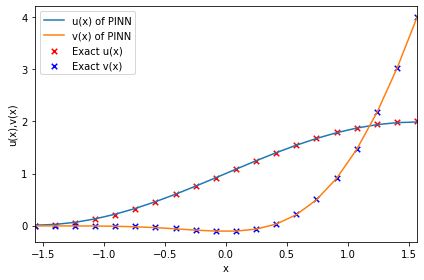

It: 10001, Loss: 5.155e-02  Losses ILRUDrxIC:[0.007852911949157715, 0.03687389940023422, 0.006827039644122124]
It: 10002, Loss: 2.955e-02  Losses ILRUDrxIC:[0.005189614836126566, 0.01612851954996586, 0.008232745341956615]
It: 10003, Loss: 4.854e-02  Losses ILRUDrxIC:[0.005898685660213232, 0.032048821449279785, 0.010597320273518562]
It: 10004, Loss: 5.541e-02  Losses ILRUDrxIC:[0.006635604426264763, 0.04163895174860954, 0.007135089486837387]
It: 10005, Loss: 3.330e-02  Losses ILRUDrxIC:[0.0052781058475375175, 0.020542185753583908, 0.007483308203518391]
It: 10006, Loss: 4.488e-02  Losses ILRUDrxIC:[0.007683063857257366, 0.027500778436660767, 0.009698502719402313]
It: 10007, Loss: 5.174e-02  Losses ILRUDrxIC:[0.007898739539086819, 0.03699779137969017, 0.006839039735496044]
It: 10008, Loss: 2.975e-02  Losses ILRUDrxIC:[0.005268617998808622, 0.016286561265587807, 0.008198373951017857]
It: 10009, Loss: 4.835e-02  Losses ILRUDrxIC:[0.005845149978995323, 0.03192897140979767, 0.0105728209018707

It: 10075, Loss: 4.828e-02  Losses ILRUDrxIC:[0.005858032964169979, 0.03188427910208702, 0.010533595457673073]
It: 10076, Loss: 5.516e-02  Losses ILRUDrxIC:[0.006584209855645895, 0.04147868975996971, 0.007094367407262325]
It: 10077, Loss: 3.320e-02  Losses ILRUDrxIC:[0.005252901464700699, 0.020486947149038315, 0.007459802553057671]
It: 10078, Loss: 4.472e-02  Losses ILRUDrxIC:[0.007652281317859888, 0.027414297685027122, 0.009651031345129013]
It: 10079, Loss: 5.147e-02  Losses ILRUDrxIC:[0.007829023525118828, 0.036828361451625824, 0.006807683501392603]
It: 10080, Loss: 2.954e-02  Losses ILRUDrxIC:[0.005189225077629089, 0.01616635173559189, 0.008183619938790798]
It: 10081, Loss: 4.830e-02  Losses ILRUDrxIC:[0.005859869997948408, 0.031910743564367294, 0.010528752580285072]
It: 10082, Loss: 5.514e-02  Losses ILRUDrxIC:[0.006572800688445568, 0.04147445410490036, 0.00709529547020793]
It: 10083, Loss: 3.316e-02  Losses ILRUDrxIC:[0.005234103184193373, 0.02047019451856613, 0.007455619517713785

It: 10149, Loss: 3.299e-02  Losses ILRUDrxIC:[0.0051984465681016445, 0.020348409190773964, 0.007447667885571718]
It: 10150, Loss: 4.468e-02  Losses ILRUDrxIC:[0.007647072430700064, 0.027440905570983887, 0.009592999704182148]
It: 10151, Loss: 5.135e-02  Losses ILRUDrxIC:[0.007802897598594427, 0.036769501864910126, 0.006782174110412598]
It: 10152, Loss: 2.945e-02  Losses ILRUDrxIC:[0.00514095788821578, 0.016127625480294228, 0.008178713731467724]
It: 10153, Loss: 4.821e-02  Losses ILRUDrxIC:[0.005870213732123375, 0.031860869377851486, 0.010477949865162373]
It: 10154, Loss: 5.505e-02  Losses ILRUDrxIC:[0.006596077233552933, 0.041381388902664185, 0.007070048712193966]
It: 10155, Loss: 3.310e-02  Losses ILRUDrxIC:[0.005237902980297804, 0.020418638363480568, 0.007439048495143652]
It: 10156, Loss: 4.463e-02  Losses ILRUDrxIC:[0.007625318132340908, 0.027407338842749596, 0.009598972275853157]
It: 10157, Loss: 5.142e-02  Losses ILRUDrxIC:[0.007819381542503834, 0.036812033504247665, 0.006789986044

It: 10223, Loss: 5.129e-02  Losses ILRUDrxIC:[0.0077869221568107605, 0.03673599287867546, 0.006765250116586685]
It: 10224, Loss: 2.947e-02  Losses ILRUDrxIC:[0.00514980498701334, 0.01618197001516819, 0.008136803284287453]
It: 10225, Loss: 4.795e-02  Losses ILRUDrxIC:[0.005830854177474976, 0.03171246498823166, 0.010410930030047894]
It: 10226, Loss: 5.477e-02  Losses ILRUDrxIC:[0.006535062566399574, 0.041203346103429794, 0.007029072381556034]
It: 10227, Loss: 3.295e-02  Losses ILRUDrxIC:[0.0052000004798173904, 0.020326796919107437, 0.007420848123729229]
It: 10228, Loss: 4.451e-02  Losses ILRUDrxIC:[0.007602603640407324, 0.027364175766706467, 0.009545473381876945]
It: 10229, Loss: 5.120e-02  Losses ILRUDrxIC:[0.007761584594845772, 0.036672282963991165, 0.006761472672224045]
It: 10230, Loss: 2.939e-02  Losses ILRUDrxIC:[0.005126544274389744, 0.01612043008208275, 0.008140772581100464]
It: 10231, Loss: 4.799e-02  Losses ILRUDrxIC:[0.005838827695697546, 0.03174721449613571, 0.0104085253551602

It: 10297, Loss: 4.784e-02  Losses ILRUDrxIC:[0.005829718895256519, 0.031652189791202545, 0.010362022556364536]
It: 10298, Loss: 5.452e-02  Losses ILRUDrxIC:[0.0064944252371788025, 0.04102319851517677, 0.0070002456195652485]
It: 10299, Loss: 3.270e-02  Losses ILRUDrxIC:[0.005144646391272545, 0.020144790410995483, 0.007413563318550587]
It: 10300, Loss: 4.456e-02  Losses ILRUDrxIC:[0.0076104397885501385, 0.027459271252155304, 0.009494772180914879]
It: 10301, Loss: 5.122e-02  Losses ILRUDrxIC:[0.00777065847069025, 0.03670664131641388, 0.006743284408003092]
It: 10302, Loss: 2.940e-02  Losses ILRUDrxIC:[0.005117853172123432, 0.016153890639543533, 0.008128507062792778]
It: 10303, Loss: 4.788e-02  Losses ILRUDrxIC:[0.005833069793879986, 0.03167833387851715, 0.010364852845668793]
It: 10304, Loss: 5.471e-02  Losses ILRUDrxIC:[0.006550735328346491, 0.04115220159292221, 0.007004502695053816]
It: 10305, Loss: 3.294e-02  Losses ILRUDrxIC:[0.0052108075469732285, 0.020329752936959267, 0.0074033867567

It: 10371, Loss: 3.267e-02  Losses ILRUDrxIC:[0.005140087567269802, 0.020152412354946136, 0.0073780762031674385]
It: 10372, Loss: 4.438e-02  Losses ILRUDrxIC:[0.007570804096758366, 0.027364494279026985, 0.009447645395994186]
It: 10373, Loss: 5.106e-02  Losses ILRUDrxIC:[0.007729268632829189, 0.036600738763809204, 0.0067255524918437]
It: 10374, Loss: 2.932e-02  Losses ILRUDrxIC:[0.005091078579425812, 0.016151422634720802, 0.008082030341029167]
It: 10375, Loss: 4.765e-02  Losses ILRUDrxIC:[0.00580889917910099, 0.03154865652322769, 0.010290928184986115]
It: 10376, Loss: 5.441e-02  Losses ILRUDrxIC:[0.006496748421341181, 0.040950462222099304, 0.006967260967940092]
It: 10377, Loss: 3.272e-02  Losses ILRUDrxIC:[0.0051553514786064625, 0.020184630528092384, 0.007379317656159401]
It: 10378, Loss: 4.431e-02  Losses ILRUDrxIC:[0.007554279174655676, 0.02730466052889824, 0.009447645395994186]
It: 10379, Loss: 5.094e-02  Losses ILRUDrxIC:[0.007696314249187708, 0.03652944043278694, 0.0067149735987186

It: 10518, Loss: 2.918e-02  Losses ILRUDrxIC:[0.005005122162401676, 0.01613653264939785, 0.00804312713444233]
It: 10519, Loss: 4.744e-02  Losses ILRUDrxIC:[0.005818803794682026, 0.0314180850982666, 0.0101991668343544]
It: 10520, Loss: 5.417e-02  Losses ILRUDrxIC:[0.006496104411780834, 0.04074757546186447, 0.006930769886821508]
It: 10521, Loss: 3.254e-02  Losses ILRUDrxIC:[0.00512514216825366, 0.02008357271552086, 0.007330240681767464]
It: 10522, Loss: 4.411e-02  Losses ILRUDrxIC:[0.007511486764997244, 0.0272425077855587, 0.009359367191791534]
It: 10523, Loss: 5.074e-02  Losses ILRUDrxIC:[0.00764556135982275, 0.03640857711434364, 0.006681904662400484]
It: 10524, Loss: 2.915e-02  Losses ILRUDrxIC:[0.005028832703828812, 0.016090309247374535, 0.008026564493775368]
It: 10525, Loss: 4.737e-02  Losses ILRUDrxIC:[0.00578716117888689, 0.03139138221740723, 0.01018886361271143]
It: 10526, Loss: 5.400e-02  Losses ILRUDrxIC:[0.006415981333702803, 0.04067803546786308, 0.0069108023308217525]
It: 1052

It: 10592, Loss: 5.392e-02  Losses ILRUDrxIC:[0.006443198770284653, 0.040583591908216476, 0.006896845996379852]
It: 10593, Loss: 3.234e-02  Losses ILRUDrxIC:[0.00507324980571866, 0.019949689507484436, 0.007319225929677486]
It: 10594, Loss: 4.409e-02  Losses ILRUDrxIC:[0.007501921616494656, 0.02727833390235901, 0.009310160763561726]
It: 10595, Loss: 5.066e-02  Losses ILRUDrxIC:[0.0076211667619645596, 0.03636888414621353, 0.00666560186073184]
It: 10596, Loss: 2.908e-02  Losses ILRUDrxIC:[0.004985978826880455, 0.016079086810350418, 0.008013125509023666]
It: 10597, Loss: 4.725e-02  Losses ILRUDrxIC:[0.005791215691715479, 0.03132457658648491, 0.010134777054190636]
It: 10598, Loss: 5.388e-02  Losses ILRUDrxIC:[0.0064276945777237415, 0.04056108742952347, 0.00688991928473115]
It: 10599, Loss: 3.232e-02  Losses ILRUDrxIC:[0.005064382217824459, 0.01993647962808609, 0.0073206620290875435]
It: 10600, Loss: 4.409e-02  Losses ILRUDrxIC:[0.007502969820052385, 0.027274057269096375, 0.00931010209023952

It: 10666, Loss: 4.403e-02  Losses ILRUDrxIC:[0.007487007416784763, 0.027274450287222862, 0.009266175329685211]
It: 10667, Loss: 5.053e-02  Losses ILRUDrxIC:[0.00758031802251935, 0.036294445395469666, 0.006650522816926241]
It: 10668, Loss: 2.898e-02  Losses ILRUDrxIC:[0.004936028737574816, 0.016051048412919044, 0.007997088134288788]
It: 10669, Loss: 4.714e-02  Losses ILRUDrxIC:[0.005796801298856735, 0.031260885298252106, 0.010084359906613827]
It: 10670, Loss: 5.371e-02  Losses ILRUDrxIC:[0.006411861628293991, 0.040427688509225845, 0.006869936361908913]
It: 10671, Loss: 3.218e-02  Losses ILRUDrxIC:[0.005035107489675283, 0.019842220470309258, 0.007305200211703777]
It: 10672, Loss: 4.404e-02  Losses ILRUDrxIC:[0.0074876644648611546, 0.027287842705845833, 0.009264349937438965]
It: 10673, Loss: 5.055e-02  Losses ILRUDrxIC:[0.00758528895676136, 0.036309100687503815, 0.006651009898632765]
It: 10674, Loss: 2.900e-02  Losses ILRUDrxIC:[0.004941959399729967, 0.01606959104537964, 0.00799121428281

It: 10740, Loss: 2.904e-02  Losses ILRUDrxIC:[0.0049322922714054585, 0.016115745529532433, 0.007995936088263988]
It: 10741, Loss: 4.703e-02  Losses ILRUDrxIC:[0.005778899881988764, 0.031192157417535782, 0.010059475898742676]
It: 10742, Loss: 5.345e-02  Losses ILRUDrxIC:[0.006331603042781353, 0.04026526212692261, 0.006850095000118017]
It: 10743, Loss: 3.205e-02  Losses ILRUDrxIC:[0.005007290747016668, 0.01970422826707363, 0.007337111979722977]
It: 10744, Loss: 4.411e-02  Losses ILRUDrxIC:[0.007491480093449354, 0.027376411482691765, 0.009243538603186607]
It: 10745, Loss: 5.041e-02  Losses ILRUDrxIC:[0.00749753275886178, 0.036286983639001846, 0.006622145883738995]
It: 10746, Loss: 2.893e-02  Losses ILRUDrxIC:[0.004829205572605133, 0.01607152633368969, 0.00802979338914156]
It: 10747, Loss: 4.714e-02  Losses ILRUDrxIC:[0.005841342732310295, 0.03119185008108616, 0.01010572724044323]
It: 10748, Loss: 5.353e-02  Losses ILRUDrxIC:[0.0063861459493637085, 0.04026016592979431, 0.006880959495902061

It: 10814, Loss: 5.317e-02  Losses ILRUDrxIC:[0.0063217151910066605, 0.0400228351354599, 0.006825166288763285]
It: 10815, Loss: 3.181e-02  Losses ILRUDrxIC:[0.004946272354573011, 0.019558174535632133, 0.007310208398848772]
It: 10816, Loss: 4.400e-02  Losses ILRUDrxIC:[0.007461302448064089, 0.027385734021663666, 0.009156731888651848]
It: 10817, Loss: 5.024e-02  Losses ILRUDrxIC:[0.00744419964030385, 0.036159761250019073, 0.006639027036726475]
It: 10818, Loss: 2.882e-02  Losses ILRUDrxIC:[0.004780893679708242, 0.01604529842734337, 0.007994098588824272]
It: 10819, Loss: 4.685e-02  Losses ILRUDrxIC:[0.005820412654429674, 0.031078610569238663, 0.009950704872608185]
It: 10820, Loss: 5.311e-02  Losses ILRUDrxIC:[0.006309097167104483, 0.03997441753745079, 0.006829636637121439]
It: 10821, Loss: 3.174e-02  Losses ILRUDrxIC:[0.004928589798510075, 0.01949680969119072, 0.007312124595046043]
It: 10822, Loss: 4.406e-02  Losses ILRUDrxIC:[0.007467794232070446, 0.027444299310445786, 0.00914578139781951

It: 10888, Loss: 4.468e-02  Losses ILRUDrxIC:[0.007197514642030001, 0.028515860438346863, 0.008968359790742397]
It: 10889, Loss: 4.741e-02  Losses ILRUDrxIC:[0.00608504144474864, 0.03439541533589363, 0.006925857160240412]
It: 10890, Loss: 2.789e-02  Losses ILRUDrxIC:[0.004188483115285635, 0.015167956240475178, 0.00853737536817789]
It: 10891, Loss: 4.490e-02  Losses ILRUDrxIC:[0.005354801192879677, 0.029900752007961273, 0.00964902900159359]
It: 10892, Loss: 4.574e-02  Losses ILRUDrxIC:[0.004737318493425846, 0.0341583751142025, 0.006842648610472679]
It: 10893, Loss: 2.848e-02  Losses ILRUDrxIC:[0.00522181810811162, 0.015440449118614197, 0.007820147089660168]
It: 10894, Loss: 4.280e-02  Losses ILRUDrxIC:[0.006685423664748669, 0.027510972693562508, 0.008602072484791279]
It: 10895, Loss: 4.099e-02  Losses ILRUDrxIC:[0.005317463539540768, 0.02897789515554905, 0.006692123133689165]
It: 10896, Loss: 2.789e-02  Losses ILRUDrxIC:[0.0043564531952142715, 0.014888668432831764, 0.008648381568491459]

It: 10962, Loss: 3.219e-02  Losses ILRUDrxIC:[0.0032804689835757017, 0.023815831169486046, 0.005090129096060991]
It: 10963, Loss: 1.550e-02  Losses ILRUDrxIC:[0.004734918940812349, 0.007256835699081421, 0.003512855153530836]
It: 10964, Loss: 1.210e-02  Losses ILRUDrxIC:[0.004046126268804073, 0.0049895248375833035, 0.0030602102633565664]
It: 10965, Loss: 3.683e-02  Losses ILRUDrxIC:[0.0039267572574317455, 0.027261463925242424, 0.005641900468617678]
It: 10966, Loss: 3.465e-02  Losses ILRUDrxIC:[0.0034149286802858114, 0.025972777977585793, 0.005257305223494768]
It: 10967, Loss: 1.329e-02  Losses ILRUDrxIC:[0.004690753761678934, 0.005332315806299448, 0.0032691711094230413]
It: 10968, Loss: 1.028e-02  Losses ILRUDrxIC:[0.004075090400874615, 0.003455610014498234, 0.0027506703045219183]
It: 10969, Loss: 3.777e-02  Losses ILRUDrxIC:[0.0039244145154953, 0.028152262791991234, 0.005695931613445282]
It: 10970, Loss: 3.496e-02  Losses ILRUDrxIC:[0.0034779587294906378, 0.02620832808315754, 0.0052705

It: 11036, Loss: 1.779e-02  Losses ILRUDrxIC:[0.00461210310459137, 0.008967787027359009, 0.004205857403576374]
It: 11037, Loss: 3.179e-02  Losses ILRUDrxIC:[0.003959144465625286, 0.023472800850868225, 0.004362446255981922]
It: 11038, Loss: 3.023e-02  Losses ILRUDrxIC:[0.003730240510776639, 0.02255828119814396, 0.003938972484320402]
It: 11039, Loss: 1.733e-02  Losses ILRUDrxIC:[0.004573868587613106, 0.00867230724543333, 0.004085419233888388]
It: 11040, Loss: 1.409e-02  Losses ILRUDrxIC:[0.004150127060711384, 0.007004675921052694, 0.0029380072373896837]
It: 11041, Loss: 3.426e-02  Losses ILRUDrxIC:[0.004195262677967548, 0.02431524358689785, 0.005753903649747372]
It: 11042, Loss: 3.148e-02  Losses ILRUDrxIC:[0.0038892466109246016, 0.02218247391283512, 0.005407572258263826]
It: 11043, Loss: 1.783e-02  Losses ILRUDrxIC:[0.004356039222329855, 0.01036934182047844, 0.003106070216745138]
It: 11044, Loss: 1.642e-02  Losses ILRUDrxIC:[0.004188911989331245, 0.009620394557714462, 0.0026078722439706

It: 11110, Loss: 2.151e-02  Losses ILRUDrxIC:[0.004134077578783035, 0.01251323614269495, 0.004862640518695116]
It: 11111, Loss: 2.383e-02  Losses ILRUDrxIC:[0.006883949041366577, 0.011966908350586891, 0.004983942490071058]
It: 11112, Loss: 2.671e-02  Losses ILRUDrxIC:[0.00792419258505106, 0.010418453253805637, 0.008363436907529831]
It: 11113, Loss: 2.302e-02  Losses ILRUDrxIC:[0.004140084143728018, 0.013076428323984146, 0.005804363638162613]
It: 11114, Loss: 1.716e-02  Losses ILRUDrxIC:[0.005338454153388739, 0.006605210714042187, 0.005215125158429146]
It: 11115, Loss: 2.292e-02  Losses ILRUDrxIC:[0.006386721506714821, 0.007856500335037708, 0.008674005046486855]
It: 11116, Loss: 2.410e-02  Losses ILRUDrxIC:[0.004022233188152313, 0.015516980551183224, 0.004560423083603382]
It: 11117, Loss: 2.007e-02  Losses ILRUDrxIC:[0.005527725908905268, 0.00864225160330534, 0.005899755284190178]
It: 11118, Loss: 4.002e-02  Losses ILRUDrxIC:[0.007576900068670511, 0.024887118488550186, 0.007553295698016

It: 11256, Loss: 3.072e-02  Losses ILRUDrxIC:[0.004214955493807793, 0.019408639520406723, 0.007097767200320959]
It: 11257, Loss: 1.974e-02  Losses ILRUDrxIC:[0.004469429142773151, 0.01351645402610302, 0.001754477620124817]
It: 11258, Loss: 1.921e-02  Losses ILRUDrxIC:[0.004278142470866442, 0.012242448516190052, 0.0026932305190712214]
It: 11259, Loss: 2.723e-02  Losses ILRUDrxIC:[0.0044021401554346085, 0.0183972530066967, 0.004435374401509762]
It: 11260, Loss: 2.232e-02  Losses ILRUDrxIC:[0.003797628451138735, 0.015377241186797619, 0.0031469010282307863]
It: 11261, Loss: 2.819e-02  Losses ILRUDrxIC:[0.00595307070761919, 0.016720009967684746, 0.005519072525203228]
It: 11262, Loss: 2.558e-02  Losses ILRUDrxIC:[0.006401630584150553, 0.014304634183645248, 0.004871182609349489]
It: 11263, Loss: 2.569e-02  Losses ILRUDrxIC:[0.003110006917268038, 0.01840851455926895, 0.00417134165763855]
It: 11264, Loss: 2.618e-02  Losses ILRUDrxIC:[0.004170572850853205, 0.01764724776148796, 0.0043581244535744

It: 11402, Loss: 2.086e-02  Losses ILRUDrxIC:[0.004732885397970676, 0.012750341556966305, 0.0033770643640309572]
It: 11403, Loss: 2.861e-02  Losses ILRUDrxIC:[0.0039040392730385065, 0.01979939267039299, 0.004909949377179146]
It: 11404, Loss: 2.696e-02  Losses ILRUDrxIC:[0.0038577187806367874, 0.018501540645956993, 0.004601128399372101]
It: 11405, Loss: 2.077e-02  Losses ILRUDrxIC:[0.00457317428663373, 0.012947510927915573, 0.003247753717005253]
It: 11406, Loss: 1.732e-02  Losses ILRUDrxIC:[0.004358698148280382, 0.010629928670823574, 0.0023322950582951307]
It: 11407, Loss: 3.216e-02  Losses ILRUDrxIC:[0.003938267007470131, 0.02195572666823864, 0.0062647233717143536]
It: 11408, Loss: 3.065e-02  Losses ILRUDrxIC:[0.0038603455759584904, 0.02082711085677147, 0.005960631184279919]
It: 11409, Loss: 1.713e-02  Losses ILRUDrxIC:[0.004142359830439091, 0.010632064193487167, 0.002352622803300619]
It: 11410, Loss: 1.440e-02  Losses ILRUDrxIC:[0.004037720151245594, 0.00828221533447504, 0.00207720813

It: 11476, Loss: 2.944e-02  Losses ILRUDrxIC:[0.0035338159650564194, 0.022111225873231888, 0.00379724963568151]
It: 11477, Loss: 1.804e-02  Losses ILRUDrxIC:[0.0043765283189713955, 0.009282472543418407, 0.0043829577043652534]
It: 11478, Loss: 1.475e-02  Losses ILRUDrxIC:[0.004374468699097633, 0.006815460044890642, 0.0035611577332019806]
It: 11479, Loss: 3.418e-02  Losses ILRUDrxIC:[0.0034802420996129513, 0.02578306943178177, 0.004916465375572443]
It: 11480, Loss: 3.274e-02  Losses ILRUDrxIC:[0.0035278296563774347, 0.024578435346484184, 0.004635106306523085]
It: 11481, Loss: 1.430e-02  Losses ILRUDrxIC:[0.003958850167691708, 0.006882242858409882, 0.003458490362390876]
It: 11482, Loss: 1.120e-02  Losses ILRUDrxIC:[0.0037481735926121473, 0.004522496368736029, 0.0029332907870411873]
It: 11483, Loss: 3.689e-02  Losses ILRUDrxIC:[0.0037901627365499735, 0.027721602469682693, 0.0053828503005206585]
It: 11484, Loss: 3.462e-02  Losses ILRUDrxIC:[0.0033871426712721586, 0.0261672455817461, 0.00506

It: 11549, Loss: 2.705e-02  Losses ILRUDrxIC:[0.003644525306299329, 0.01837608776986599, 0.005027879495173693]
It: 11550, Loss: 2.600e-02  Losses ILRUDrxIC:[0.0031955591402947903, 0.017405878752470016, 0.005400212947279215]
It: 11551, Loss: 2.010e-02  Losses ILRUDrxIC:[0.0031815816182643175, 0.014422458596527576, 0.00250019459053874]
It: 11552, Loss: 2.049e-02  Losses ILRUDrxIC:[0.003197064157575369, 0.012583687901496887, 0.004712823312729597]
It: 11553, Loss: 2.471e-02  Losses ILRUDrxIC:[0.004550914745777845, 0.01720460318028927, 0.0029556516092270613]
It: 11554, Loss: 2.193e-02  Losses ILRUDrxIC:[0.0027741636149585247, 0.01373791042715311, 0.005413530860096216]
It: 11555, Loss: 2.901e-02  Losses ILRUDrxIC:[0.005316453520208597, 0.018337152898311615, 0.0053597912192344666]
It: 11556, Loss: 2.330e-02  Losses ILRUDrxIC:[0.00379008986055851, 0.0170200914144516, 0.002494551008567214]
It: 11557, Loss: 2.326e-02  Losses ILRUDrxIC:[0.004768259357661009, 0.014454220421612263, 0.00403863005340

It: 11623, Loss: 3.429e-02  Losses ILRUDrxIC:[0.004380714148283005, 0.026011889800429344, 0.0038979595992714167]
It: 11624, Loss: 3.234e-02  Losses ILRUDrxIC:[0.00321710342541337, 0.02514326199889183, 0.003983636386692524]
It: 11625, Loss: 1.494e-02  Losses ILRUDrxIC:[0.004177734721451998, 0.007068975828588009, 0.0036904942244291306]
It: 11626, Loss: 1.461e-02  Losses ILRUDrxIC:[0.0034245294518768787, 0.007674485445022583, 0.003511895192787051]
It: 11627, Loss: 2.641e-02  Losses ILRUDrxIC:[0.0034220542293041945, 0.020168287679553032, 0.0028218517545610666]
It: 11628, Loss: 2.093e-02  Losses ILRUDrxIC:[0.002852679928764701, 0.014616245403885841, 0.0034611166920512915]
It: 11629, Loss: 2.612e-02  Losses ILRUDrxIC:[0.004474494140595198, 0.019493889063596725, 0.0021497744601219893]
It: 11630, Loss: 2.722e-02  Losses ILRUDrxIC:[0.0035297509748488665, 0.018547331914305687, 0.005139979068189859]
It: 11631, Loss: 2.126e-02  Losses ILRUDrxIC:[0.004125151317566633, 0.012140526436269283, 0.004990

It: 11696, Loss: 3.296e-02  Losses ILRUDrxIC:[0.003193336771801114, 0.024670295417308807, 0.005100522190332413]
It: 11697, Loss: 1.456e-02  Losses ILRUDrxIC:[0.004493150860071182, 0.006781339645385742, 0.0032811337150633335]
It: 11698, Loss: 1.268e-02  Losses ILRUDrxIC:[0.004292111843824387, 0.005220282357186079, 0.0031690383329987526]
It: 11699, Loss: 3.245e-02  Losses ILRUDrxIC:[0.0034131365828216076, 0.023648111149668694, 0.005388729274272919]
It: 11700, Loss: 2.789e-02  Losses ILRUDrxIC:[0.002997281961143017, 0.01951131410896778, 0.005382213741540909]
It: 11701, Loss: 2.146e-02  Losses ILRUDrxIC:[0.004946224857121706, 0.013981521129608154, 0.002527922624722123]
It: 11702, Loss: 1.976e-02  Losses ILRUDrxIC:[0.004627407528460026, 0.013133419677615166, 0.0020028725266456604]
It: 11703, Loss: 2.791e-02  Losses ILRUDrxIC:[0.003675740212202072, 0.017712555825710297, 0.0065198540687561035]
It: 11704, Loss: 2.541e-02  Losses ILRUDrxIC:[0.0034840547014027834, 0.015181398950517178, 0.0067417

It: 11769, Loss: 1.626e-02  Losses ILRUDrxIC:[0.005147265270352364, 0.008357812650501728, 0.0027576922439038754]
It: 11770, Loss: 1.353e-02  Losses ILRUDrxIC:[0.003432712284848094, 0.007097706198692322, 0.002998150885105133]
It: 11771, Loss: 3.245e-02  Losses ILRUDrxIC:[0.004464522935450077, 0.02447366714477539, 0.0035163613501936197]
It: 11772, Loss: 2.886e-02  Losses ILRUDrxIC:[0.0039061906281858683, 0.022450236603617668, 0.002501091919839382]
It: 11773, Loss: 1.882e-02  Losses ILRUDrxIC:[0.0042262631468474865, 0.010304722003638744, 0.004286728333681822]
It: 11774, Loss: 1.699e-02  Losses ILRUDrxIC:[0.004366706591099501, 0.009289171546697617, 0.0033355792984366417]
It: 11775, Loss: 2.923e-02  Losses ILRUDrxIC:[0.0025877710431814194, 0.022412389516830444, 0.004225337877869606]
It: 11776, Loss: 2.759e-02  Losses ILRUDrxIC:[0.002861888613551855, 0.021073035895824432, 0.003656666725873947]
It: 11777, Loss: 1.755e-02  Losses ILRUDrxIC:[0.003657845314592123, 0.0103988666087389, 0.003495281

It: 11842, Loss: 1.959e-02  Losses ILRUDrxIC:[0.0028992672450840473, 0.012197086587548256, 0.004495842382311821]
It: 11843, Loss: 2.610e-02  Losses ILRUDrxIC:[0.004428164567798376, 0.018374117091298103, 0.0032937750220298767]
It: 11844, Loss: 2.400e-02  Losses ILRUDrxIC:[0.003729959949851036, 0.015476638451218605, 0.0047898138873279095]
It: 11845, Loss: 2.515e-02  Losses ILRUDrxIC:[0.005315593909472227, 0.015712635591626167, 0.004120404366403818]
It: 11846, Loss: 2.259e-02  Losses ILRUDrxIC:[0.00468697352334857, 0.013560054823756218, 0.004343933891505003]
It: 11847, Loss: 2.667e-02  Losses ILRUDrxIC:[0.00354747218079865, 0.01817258819937706, 0.00495068309828639]
It: 11848, Loss: 2.302e-02  Losses ILRUDrxIC:[0.0036941745784133673, 0.016792718321084976, 0.0025339312851428986]
It: 11849, Loss: 2.073e-02  Losses ILRUDrxIC:[0.0037954244762659073, 0.013930186629295349, 0.0030092375818639994]
It: 11850, Loss: 1.843e-02  Losses ILRUDrxIC:[0.003296326147392392, 0.010963056236505508, 0.004168999

It: 11915, Loss: 2.831e-02  Losses ILRUDrxIC:[0.00321854162029922, 0.02109467051923275, 0.004001500550657511]
It: 11916, Loss: 2.436e-02  Losses ILRUDrxIC:[0.0032675869297236204, 0.016716115176677704, 0.004379469435662031]
It: 11917, Loss: 2.436e-02  Losses ILRUDrxIC:[0.004261210560798645, 0.01630028709769249, 0.003799862926825881]
It: 11918, Loss: 2.320e-02  Losses ILRUDrxIC:[0.003311548149213195, 0.014940295368432999, 0.004947945941239595]
It: 11919, Loss: 2.525e-02  Losses ILRUDrxIC:[0.0038553413469344378, 0.016128351911902428, 0.0052709635347127914]
It: 11920, Loss: 1.995e-02  Losses ILRUDrxIC:[0.00318640423938632, 0.013543699868023396, 0.0032212722580879927]
It: 11921, Loss: 2.666e-02  Losses ILRUDrxIC:[0.00467342883348465, 0.017804596573114395, 0.004181723576039076]
It: 11922, Loss: 2.239e-02  Losses ILRUDrxIC:[0.003525739535689354, 0.015351610258221626, 0.0035167569294571877]
It: 11923, Loss: 2.506e-02  Losses ILRUDrxIC:[0.003655798966065049, 0.017209835350513458, 0.004191205371

It: 11988, Loss: 2.469e-02  Losses ILRUDrxIC:[0.0028564180247485638, 0.018498167395591736, 0.0033316481858491898]
It: 11989, Loss: 2.135e-02  Losses ILRUDrxIC:[0.0036417474038898945, 0.014995760284364223, 0.002713290974497795]
It: 11990, Loss: 2.092e-02  Losses ILRUDrxIC:[0.003356896573677659, 0.013247122056782246, 0.004318051040172577]
It: 11991, Loss: 2.444e-02  Losses ILRUDrxIC:[0.003335213754326105, 0.017398685216903687, 0.003704204922541976]
It: 11992, Loss: 2.150e-02  Losses ILRUDrxIC:[0.00344061478972435, 0.013563510030508041, 0.004500013776123524]
It: 11993, Loss: 2.676e-02  Losses ILRUDrxIC:[0.004736530128866434, 0.017413487657904625, 0.0046112146228551865]
It: 11994, Loss: 2.272e-02  Losses ILRUDrxIC:[0.00366925448179245, 0.01451033167541027, 0.004540265537798405]
It: 11995, Loss: 2.680e-02  Losses ILRUDrxIC:[0.004067494999617338, 0.01767333224415779, 0.005063834134489298]
It: 11996, Loss: 2.414e-02  Losses ILRUDrxIC:[0.003875725669786334, 0.016297439113259315, 0.003969793673

It: 12061, Loss: 1.995e-02  Losses ILRUDrxIC:[0.0043646469712257385, 0.012460347265005112, 0.0031286401208490133]
It: 12062, Loss: 1.684e-02  Losses ILRUDrxIC:[0.0036133266985416412, 0.010486038401722908, 0.002742414129897952]
It: 12063, Loss: 3.127e-02  Losses ILRUDrxIC:[0.003955621272325516, 0.021670129150152206, 0.005639323964715004]
It: 12064, Loss: 2.884e-02  Losses ILRUDrxIC:[0.0031818856950849295, 0.02049030363559723, 0.0051724170334637165]
It: 12065, Loss: 1.872e-02  Losses ILRUDrxIC:[0.004696626681834459, 0.010636495426297188, 0.0033820595126599073]
It: 12066, Loss: 1.565e-02  Losses ILRUDrxIC:[0.0039110262878239155, 0.008612416684627533, 0.003126280615106225]
It: 12067, Loss: 3.266e-02  Losses ILRUDrxIC:[0.003930003847926855, 0.023679496720433235, 0.005046680569648743]
It: 12068, Loss: 3.047e-02  Losses ILRUDrxIC:[0.003300720825791359, 0.022732609882950783, 0.004434769973158836]
It: 12069, Loss: 1.696e-02  Losses ILRUDrxIC:[0.004761959426105022, 0.008261647075414658, 0.003936

It: 12206, Loss: 2.469e-02  Losses ILRUDrxIC:[0.0025937191676348448, 0.01849016174674034, 0.0036067578475922346]
It: 12207, Loss: 3.245e-02  Losses ILRUDrxIC:[0.004034915938973427, 0.022645868360996246, 0.0057645137421786785]
It: 12208, Loss: 1.465e-02  Losses ILRUDrxIC:[0.0023938820231705904, 0.006347452290356159, 0.005907383747398853]
It: 12209, Loss: 1.883e-02  Losses ILRUDrxIC:[0.0032722866162657738, 0.013457178138196468, 0.002104096347466111]
It: 12210, Loss: 1.753e-02  Losses ILRUDrxIC:[0.003922644071280956, 0.008995653130114079, 0.004615353420376778]
It: 12211, Loss: 1.529e-02  Losses ILRUDrxIC:[0.0030598603188991547, 0.008654806762933731, 0.003575083101168275]
It: 12212, Loss: 2.026e-02  Losses ILRUDrxIC:[0.005305457394570112, 0.012385962530970573, 0.002564922673627734]
It: 12213, Loss: 9.891e-03  Losses ILRUDrxIC:[0.003640462178736925, 0.0038307616487145424, 0.0024197010789066553]
It: 12214, Loss: 2.779e-02  Losses ILRUDrxIC:[0.005940928589552641, 0.01795228384435177, 0.003899

It: 12353, Loss: 3.091e-02  Losses ILRUDrxIC:[0.0057069770991802216, 0.019288241863250732, 0.005916298367083073]
It: 12354, Loss: 2.048e-02  Losses ILRUDrxIC:[0.0023367879912257195, 0.012500861659646034, 0.005646652076393366]
It: 12355, Loss: 2.473e-02  Losses ILRUDrxIC:[0.003921301569789648, 0.01390580553561449, 0.006905719172209501]
It: 12356, Loss: 2.185e-02  Losses ILRUDrxIC:[0.0026672680396586657, 0.014952914789319038, 0.004225371405482292]
It: 12357, Loss: 2.106e-02  Losses ILRUDrxIC:[0.003139819484204054, 0.014628342352807522, 0.0032965426798909903]
It: 12358, Loss: 2.092e-02  Losses ILRUDrxIC:[0.002873440273106098, 0.01544272806495428, 0.0026081595569849014]
It: 12359, Loss: 2.059e-02  Losses ILRUDrxIC:[0.0031688783783465624, 0.014565003104507923, 0.002856744918972254]
It: 12360, Loss: 2.004e-02  Losses ILRUDrxIC:[0.004373785573989153, 0.01499848160892725, 0.0006666557746939361]
It: 12361, Loss: 1.865e-02  Losses ILRUDrxIC:[0.0034692815970629454, 0.010404583066701889, 0.0047778

It: 12426, Loss: 1.865e-02  Losses ILRUDrxIC:[0.0028755557723343372, 0.012411171570420265, 0.0033660961780697107]
It: 12427, Loss: 9.969e-03  Losses ILRUDrxIC:[0.0025598325300961733, 0.0050151534378528595, 0.0023938228841871023]
It: 12428, Loss: 2.379e-02  Losses ILRUDrxIC:[0.002902230015024543, 0.015987589955329895, 0.004902833141386509]
It: 12429, Loss: 1.571e-02  Losses ILRUDrxIC:[0.0034246479626744986, 0.008303103037178516, 0.003983890172094107]
It: 12430, Loss: 2.572e-02  Losses ILRUDrxIC:[0.002805357100442052, 0.019252413883805275, 0.003659413196146488]
It: 12431, Loss: 2.158e-02  Losses ILRUDrxIC:[0.0034264272544533014, 0.014517982490360737, 0.003635772969573736]
It: 12432, Loss: 2.612e-02  Losses ILRUDrxIC:[0.004202260170131922, 0.01777929998934269, 0.004136237315833569]
It: 12433, Loss: 1.835e-02  Losses ILRUDrxIC:[0.0026594968512654305, 0.012361750937998295, 0.0033330204896628857]
It: 12434, Loss: 3.136e-02  Losses ILRUDrxIC:[0.004695608280599117, 0.021366190165281296, 0.0052

It: 12500, Loss: 1.851e-02  Losses ILRUDrxIC:[0.00558900460600853, 0.011646876111626625, 0.0012788252206519246]
It: 12501, Loss: 2.111e-02  Losses ILRUDrxIC:[0.005757664330303669, 0.005227664019912481, 0.010126338340342045]
It: 12502, Loss: 2.211e-02  Losses ILRUDrxIC:[0.003343503922224045, 0.006186621263623238, 0.012575663626194]
It: 12503, Loss: 2.943e-02  Losses ILRUDrxIC:[0.00421675480902195, 0.01736590825021267, 0.007844838313758373]
It: 12504, Loss: 2.041e-02  Losses ILRUDrxIC:[0.005301640368998051, 0.012869033962488174, 0.002237926470115781]
It: 12505, Loss: 2.716e-02  Losses ILRUDrxIC:[0.004222303628921509, 0.017579734325408936, 0.005359572824090719]
It: 12506, Loss: 2.738e-02  Losses ILRUDrxIC:[0.005379124544560909, 0.016219697892665863, 0.0057767159305512905]
It: 12507, Loss: 2.187e-02  Losses ILRUDrxIC:[0.008974009193480015, 0.01064886525273323, 0.002246276242658496]
It: 12508, Loss: 2.036e-02  Losses ILRUDrxIC:[0.007069277577102184, 0.006395488977432251, 0.00689268251881003

It: 12574, Loss: 5.208e-02  Losses ILRUDrxIC:[0.008493931032717228, 0.03629496321082115, 0.007294212933629751]
It: 12575, Loss: 2.633e-02  Losses ILRUDrxIC:[0.005683564580976963, 0.01620558463037014, 0.004445681348443031]
It: 12576, Loss: 4.283e-02  Losses ILRUDrxIC:[0.004461503587663174, 0.031070025637745857, 0.007301839999854565]
It: 12577, Loss: 5.637e-02  Losses ILRUDrxIC:[0.006452024448662996, 0.041672952473163605, 0.008242020383477211]
It: 12578, Loss: 2.982e-02  Losses ILRUDrxIC:[0.0038880936335772276, 0.02240530215203762, 0.00352568575181067]
It: 12579, Loss: 3.870e-02  Losses ILRUDrxIC:[0.006191476248204708, 0.023516811430454254, 0.008990895003080368]
It: 12580, Loss: 5.345e-02  Losses ILRUDrxIC:[0.007161105051636696, 0.03390023112297058, 0.012384933419525623]
It: 12581, Loss: 2.631e-02  Losses ILRUDrxIC:[0.0036701438948512077, 0.014266458339989185, 0.008374949917197227]
It: 12582, Loss: 4.268e-02  Losses ILRUDrxIC:[0.006425981875509024, 0.03185191750526428, 0.0044033685699105

It: 12648, Loss: 1.457e-02  Losses ILRUDrxIC:[0.0034108744002878666, 0.008222980424761772, 0.0029322176706045866]
It: 12649, Loss: 3.794e-02  Losses ILRUDrxIC:[0.005980880931019783, 0.026712357997894287, 0.005245912354439497]
It: 12650, Loss: 3.807e-02  Losses ILRUDrxIC:[0.0061693936586380005, 0.02735009789466858, 0.00454800995066762]
It: 12651, Loss: 9.928e-03  Losses ILRUDrxIC:[0.002652200870215893, 0.0029127111192792654, 0.004363324027508497]
It: 12652, Loss: 1.886e-02  Losses ILRUDrxIC:[0.003767663612961769, 0.01018993929028511, 0.004906097427010536]
It: 12653, Loss: 1.694e-02  Losses ILRUDrxIC:[0.0031171427108347416, 0.010416507720947266, 0.0034017530269920826]
It: 12654, Loss: 1.109e-02  Losses ILRUDrxIC:[0.002869386924430728, 0.005007255356758833, 0.00321375485509634]
It: 12655, Loss: 1.261e-02  Losses ILRUDrxIC:[0.0028934194706380367, 0.004394101910293102, 0.005320494528859854]
It: 12656, Loss: 1.511e-02  Losses ILRUDrxIC:[0.002403769874945283, 0.008718946017324924, 0.003983956

It: 12721, Loss: 1.358e-02  Losses ILRUDrxIC:[0.003766004927456379, 0.005305129569023848, 0.004510540049523115]
It: 12722, Loss: 2.535e-02  Losses ILRUDrxIC:[0.003269406734034419, 0.01812649518251419, 0.003958753310143948]
It: 12723, Loss: 1.744e-02  Losses ILRUDrxIC:[0.0032113699708133936, 0.011202272959053516, 0.0030225596856325865]
It: 12724, Loss: 2.720e-02  Losses ILRUDrxIC:[0.0035215674433857203, 0.019535893574357033, 0.00414151418954134]
It: 12725, Loss: 1.826e-02  Losses ILRUDrxIC:[0.0029859181959182024, 0.013499608263373375, 0.0017732486594468355]
It: 12726, Loss: 2.762e-02  Losses ILRUDrxIC:[0.004697880242019892, 0.020485104992985725, 0.002437038579955697]
It: 12727, Loss: 2.615e-02  Losses ILRUDrxIC:[0.004385720938444138, 0.017987413331866264, 0.0037739265244454145]
It: 12728, Loss: 2.090e-02  Losses ILRUDrxIC:[0.004309680312871933, 0.012346331961452961, 0.004246440250426531]
It: 12729, Loss: 1.679e-02  Losses ILRUDrxIC:[0.0050598615780472755, 0.009766838513314724, 0.0019596

It: 12794, Loss: 2.505e-02  Losses ILRUDrxIC:[0.0043135229498147964, 0.01600576378405094, 0.004725819919258356]
It: 12795, Loss: 2.382e-02  Losses ILRUDrxIC:[0.004437850322574377, 0.01449106726795435, 0.0048934221267700195]
It: 12796, Loss: 2.112e-02  Losses ILRUDrxIC:[0.004455761518329382, 0.011353281326591969, 0.0053117782808840275]
It: 12797, Loss: 2.709e-02  Losses ILRUDrxIC:[0.003509685629978776, 0.020051518455147743, 0.0035267150960862637]
It: 12798, Loss: 2.317e-02  Losses ILRUDrxIC:[0.00380322290584445, 0.015548758208751678, 0.003819566685706377]
It: 12799, Loss: 2.680e-02  Losses ILRUDrxIC:[0.0041207484900951385, 0.018436739221215248, 0.0042428611777722836]
It: 12800, Loss: 2.567e-02  Losses ILRUDrxIC:[0.004241740331053734, 0.017719080671668053, 0.003709187963977456]
It: 12801, Loss: 2.145e-02  Losses ILRUDrxIC:[0.0034432117827236652, 0.013462516479194164, 0.004544651601463556]
It: 12802, Loss: 1.872e-02  Losses ILRUDrxIC:[0.0035356662701815367, 0.01103746984153986, 0.00415133

It: 12868, Loss: 1.321e-02  Losses ILRUDrxIC:[0.003943249583244324, 0.006319917738437653, 0.00294246687553823]
It: 12869, Loss: 3.434e-02  Losses ILRUDrxIC:[0.003997426480054855, 0.02472284622490406, 0.005619533360004425]
It: 12870, Loss: 3.152e-02  Losses ILRUDrxIC:[0.0036753166932612658, 0.02251562848687172, 0.005328163504600525]
It: 12871, Loss: 1.676e-02  Losses ILRUDrxIC:[0.004200040828436613, 0.00965119618922472, 0.0029058363288640976]
It: 12872, Loss: 1.495e-02  Losses ILRUDrxIC:[0.003962472081184387, 0.008694982156157494, 0.002293806755915284]
It: 12873, Loss: 3.196e-02  Losses ILRUDrxIC:[0.0039000832475721836, 0.02207307703793049, 0.005987595301121473]
It: 12874, Loss: 2.875e-02  Losses ILRUDrxIC:[0.00348357274197042, 0.019823038950562477, 0.005446528550237417]
It: 12875, Loss: 1.946e-02  Losses ILRUDrxIC:[0.004512965679168701, 0.011952188797295094, 0.002992936410009861]
It: 12876, Loss: 1.729e-02  Losses ILRUDrxIC:[0.00431026890873909, 0.010316180996596813, 0.0026646030601114

It: 12941, Loss: 2.997e-02  Losses ILRUDrxIC:[0.0030357877258211374, 0.022910701110959053, 0.004026980604976416]
It: 12942, Loss: 2.558e-02  Losses ILRUDrxIC:[0.0031950753182172775, 0.019344884902238846, 0.0030386862345039845]
It: 12943, Loss: 2.132e-02  Losses ILRUDrxIC:[0.003832044545561075, 0.012568583711981773, 0.004920136649161577]
It: 12944, Loss: 1.867e-02  Losses ILRUDrxIC:[0.0038393998984247446, 0.010442405939102173, 0.004389328416436911]
It: 12945, Loss: 2.807e-02  Losses ILRUDrxIC:[0.00300803710706532, 0.021237812936306, 0.0038231376092880964]
It: 12946, Loss: 2.684e-02  Losses ILRUDrxIC:[0.0032978197559714317, 0.019246667623519897, 0.0042907171882689]
It: 12947, Loss: 1.843e-02  Losses ILRUDrxIC:[0.003484434215351939, 0.011833276599645615, 0.0031100534833967686]
It: 12948, Loss: 1.611e-02  Losses ILRUDrxIC:[0.0032052230089902878, 0.008941106498241425, 0.003964263945817947]
It: 12949, Loss: 2.991e-02  Losses ILRUDrxIC:[0.0036774754989892244, 0.02312260866165161, 0.0031095738

It: 13014, Loss: 2.469e-02  Losses ILRUDrxIC:[0.0032911542803049088, 0.017738718539476395, 0.0036583126056939363]
It: 13015, Loss: 2.095e-02  Losses ILRUDrxIC:[0.004133784212172031, 0.013155652210116386, 0.0036588418297469616]
It: 13016, Loss: 1.825e-02  Losses ILRUDrxIC:[0.003564043901860714, 0.010649783536791801, 0.004032937344163656]
It: 13017, Loss: 2.839e-02  Losses ILRUDrxIC:[0.0034941670019179583, 0.02100086212158203, 0.0038995821960270405]
It: 13018, Loss: 2.637e-02  Losses ILRUDrxIC:[0.0033006605226546526, 0.019246287643909454, 0.0038245446048676968]
It: 13019, Loss: 1.914e-02  Losses ILRUDrxIC:[0.003984186332672834, 0.011484324932098389, 0.003671292681246996]
It: 13020, Loss: 1.676e-02  Losses ILRUDrxIC:[0.003453095443546772, 0.009060703217983246, 0.004241941962391138]
It: 13021, Loss: 2.952e-02  Losses ILRUDrxIC:[0.0035535660572350025, 0.021913647651672363, 0.004047887399792671]
It: 13022, Loss: 2.659e-02  Losses ILRUDrxIC:[0.0032235742546617985, 0.019533436745405197, 0.0038

It: 13087, Loss: 2.526e-02  Losses ILRUDrxIC:[0.004433044698089361, 0.016898104920983315, 0.003930586390197277]
It: 13088, Loss: 2.128e-02  Losses ILRUDrxIC:[0.0037408671341836452, 0.014109555631875992, 0.0034315583761781454]
It: 13089, Loss: 2.571e-02  Losses ILRUDrxIC:[0.00327318930067122, 0.018509693443775177, 0.003924050834029913]
It: 13090, Loss: 2.424e-02  Losses ILRUDrxIC:[0.003254498355090618, 0.017618009820580482, 0.0033708016853779554]
It: 13091, Loss: 1.990e-02  Losses ILRUDrxIC:[0.0035824698861688375, 0.012740625068545341, 0.0035744099877774715]
It: 13092, Loss: 1.649e-02  Losses ILRUDrxIC:[0.003184804692864418, 0.009644919075071812, 0.003660445800051093]
It: 13093, Loss: 2.942e-02  Losses ILRUDrxIC:[0.0033141064923256636, 0.02259276993572712, 0.0035151089541614056]
It: 13094, Loss: 2.804e-02  Losses ILRUDrxIC:[0.002984544262290001, 0.021202391013503075, 0.003852173453196883]
It: 13095, Loss: 1.654e-02  Losses ILRUDrxIC:[0.0037125442177057266, 0.009240307845175266, 0.003585

It: 13160, Loss: 2.283e-02  Losses ILRUDrxIC:[0.003368666861206293, 0.015897518023848534, 0.0035649656783789396]
It: 13161, Loss: 2.388e-02  Losses ILRUDrxIC:[0.003497611964121461, 0.014934418722987175, 0.005452735349535942]
It: 13162, Loss: 2.071e-02  Losses ILRUDrxIC:[0.0024565740022808313, 0.013056675903499126, 0.0051954067312181]
It: 13163, Loss: 2.647e-02  Losses ILRUDrxIC:[0.004808889236301184, 0.01814122498035431, 0.0035248342901468277]
It: 13164, Loss: 2.357e-02  Losses ILRUDrxIC:[0.0035277530550956726, 0.016676094383001328, 0.0033710577990859747]
It: 13165, Loss: 2.376e-02  Losses ILRUDrxIC:[0.0038948131259530783, 0.015060733072459698, 0.004809026140719652]
It: 13166, Loss: 2.084e-02  Losses ILRUDrxIC:[0.0026902875397354364, 0.014148850925266743, 0.004004749935120344]
It: 13167, Loss: 2.610e-02  Losses ILRUDrxIC:[0.005346652586013079, 0.01644495502114296, 0.004310645628720522]
It: 13168, Loss: 2.267e-02  Losses ILRUDrxIC:[0.004640771541744471, 0.014364016242325306, 0.003668874

It: 13305, Loss: 2.912e-02  Losses ILRUDrxIC:[0.0034965542145073414, 0.02185811661183834, 0.003765672678127885]
It: 13306, Loss: 2.744e-02  Losses ILRUDrxIC:[0.003291347064077854, 0.020237157121300697, 0.003914882428944111]
It: 13307, Loss: 1.771e-02  Losses ILRUDrxIC:[0.0037990023847669363, 0.010118729434907436, 0.0037900658790022135]
It: 13308, Loss: 1.576e-02  Losses ILRUDrxIC:[0.0034632855094969273, 0.008085069246590137, 0.004208683501929045]
It: 13309, Loss: 2.850e-02  Losses ILRUDrxIC:[0.003347973106428981, 0.02123122662305832, 0.003923616372048855]
It: 13310, Loss: 2.481e-02  Losses ILRUDrxIC:[0.003129880642518401, 0.017725715413689613, 0.003950383048504591]
It: 13311, Loss: 2.199e-02  Losses ILRUDrxIC:[0.004029369913041592, 0.01421840488910675, 0.0037414939142763615]
It: 13312, Loss: 2.057e-02  Losses ILRUDrxIC:[0.003429536474868655, 0.012702877633273602, 0.004432859364897013]
It: 13313, Loss: 2.557e-02  Losses ILRUDrxIC:[0.003402198664844036, 0.01754624769091606, 0.00461857020

It: 13378, Loss: 2.829e-02  Losses ILRUDrxIC:[0.003386921714991331, 0.02165762148797512, 0.003244329709559679]
It: 13379, Loss: 1.657e-02  Losses ILRUDrxIC:[0.003890457795932889, 0.008666681125760078, 0.004014570266008377]
It: 13380, Loss: 1.271e-02  Losses ILRUDrxIC:[0.00333468453027308, 0.0066263494081795216, 0.002753364620730281]
It: 13381, Loss: 3.198e-02  Losses ILRUDrxIC:[0.003346232697367668, 0.024660641327500343, 0.003969802986830473]
It: 13382, Loss: 2.851e-02  Losses ILRUDrxIC:[0.0029325629584491253, 0.022851567715406418, 0.0027293299790471792]
It: 13383, Loss: 1.686e-02  Losses ILRUDrxIC:[0.00321596534922719, 0.009187804535031319, 0.004457094706594944]
It: 13384, Loss: 1.548e-02  Losses ILRUDrxIC:[0.00301682623103261, 0.008613337762653828, 0.0038481359370052814]
It: 13385, Loss: 2.696e-02  Losses ILRUDrxIC:[0.002720020478591323, 0.02055453136563301, 0.0036833505146205425]
It: 13386, Loss: 2.255e-02  Losses ILRUDrxIC:[0.0025175202172249556, 0.016289398074150085, 0.00374321592

It: 13451, Loss: 1.961e-02  Losses ILRUDrxIC:[0.003728170646354556, 0.012132533825933933, 0.003744728397578001]
It: 13452, Loss: 1.635e-02  Losses ILRUDrxIC:[0.0033005508594214916, 0.009214527904987335, 0.0038356026634573936]
It: 13453, Loss: 2.937e-02  Losses ILRUDrxIC:[0.0034373190719634295, 0.022159414365887642, 0.003774449462071061]
It: 13454, Loss: 2.744e-02  Losses ILRUDrxIC:[0.003142070956528187, 0.02046377770602703, 0.00383614469319582]
It: 13455, Loss: 1.742e-02  Losses ILRUDrxIC:[0.0037209102883934975, 0.00989461038261652, 0.0038078604266047478]
It: 13456, Loss: 1.545e-02  Losses ILRUDrxIC:[0.0033226418308913708, 0.008004432544112206, 0.004125390201807022]
It: 13457, Loss: 2.813e-02  Losses ILRUDrxIC:[0.0033583438489586115, 0.02090405859053135, 0.0038673169910907745]
It: 13458, Loss: 2.417e-02  Losses ILRUDrxIC:[0.0030699812341481447, 0.017146505415439606, 0.0039499681442976]
It: 13459, Loss: 2.250e-02  Losses ILRUDrxIC:[0.004069475457072258, 0.01469204667955637, 0.0037412375

It: 13524, Loss: 1.956e-02  Losses ILRUDrxIC:[0.0033915892709046602, 0.012067991308867931, 0.004105296451598406]
It: 13525, Loss: 2.739e-02  Losses ILRUDrxIC:[0.00362604227848351, 0.01945595070719719, 0.004312528297305107]
It: 13526, Loss: 2.480e-02  Losses ILRUDrxIC:[0.003425263799726963, 0.017941614612936974, 0.003434770507737994]
It: 13527, Loss: 1.962e-02  Losses ILRUDrxIC:[0.0037314132787287235, 0.011905379593372345, 0.003986474126577377]
It: 13528, Loss: 1.617e-02  Losses ILRUDrxIC:[0.003373540937900543, 0.009100534953176975, 0.00369808217510581]
It: 13529, Loss: 2.876e-02  Losses ILRUDrxIC:[0.003302772529423237, 0.02154489979147911, 0.003909857477992773]
It: 13530, Loss: 2.597e-02  Losses ILRUDrxIC:[0.003107741242274642, 0.01914113759994507, 0.0037231440655887127]
It: 13531, Loss: 1.929e-02  Losses ILRUDrxIC:[0.0037912214174866676, 0.011736455373466015, 0.0037659499794244766]
It: 13532, Loss: 1.747e-02  Losses ILRUDrxIC:[0.0034647376742213964, 0.009731466881930828, 0.00426995521

It: 13597, Loss: 2.533e-02  Losses ILRUDrxIC:[0.003770623356103897, 0.01664368249475956, 0.00491351680830121]
It: 13598, Loss: 2.125e-02  Losses ILRUDrxIC:[0.0031190242152661085, 0.014890816062688828, 0.003241145983338356]
It: 13599, Loss: 2.414e-02  Losses ILRUDrxIC:[0.004252701532095671, 0.015482929535210133, 0.004408989101648331]
It: 13600, Loss: 1.989e-02  Losses ILRUDrxIC:[0.003601863281801343, 0.012790411710739136, 0.0035015169996768236]
It: 13601, Loss: 2.698e-02  Losses ILRUDrxIC:[0.0031727231107652187, 0.019270045682787895, 0.00453326478600502]
It: 13602, Loss: 2.473e-02  Losses ILRUDrxIC:[0.002934443997219205, 0.01829596422612667, 0.0034992964938282967]
It: 13603, Loss: 2.003e-02  Losses ILRUDrxIC:[0.003783739171922207, 0.011918952688574791, 0.004324852954596281]
It: 13604, Loss: 1.572e-02  Losses ILRUDrxIC:[0.0029291752725839615, 0.009315019473433495, 0.003476172685623169]
It: 13605, Loss: 3.078e-02  Losses ILRUDrxIC:[0.0035540000535547733, 0.022718919441103935, 0.0045089432

It: 13670, Loss: 2.396e-02  Losses ILRUDrxIC:[0.002811579965054989, 0.015342649072408676, 0.005809097550809383]
It: 13671, Loss: 2.225e-02  Losses ILRUDrxIC:[0.004488887265324593, 0.015764228999614716, 0.001999522093683481]
It: 13672, Loss: 2.077e-02  Losses ILRUDrxIC:[0.0046805087476968765, 0.013620027340948582, 0.0024662071373313665]
It: 13673, Loss: 2.391e-02  Losses ILRUDrxIC:[0.002937895245850086, 0.01683546043932438, 0.00413184380158782]
It: 13674, Loss: 2.079e-02  Losses ILRUDrxIC:[0.0026582644786685705, 0.015204927884042263, 0.0029224371537566185]
It: 13675, Loss: 2.485e-02  Losses ILRUDrxIC:[0.0055005839094519615, 0.014439035207033157, 0.004908212926238775]
It: 13676, Loss: 2.082e-02  Losses ILRUDrxIC:[0.005302926991134882, 0.011720518581569195, 0.0037952137645334005]
It: 13677, Loss: 2.752e-02  Losses ILRUDrxIC:[0.002936979290097952, 0.0196995846927166, 0.004882128909230232]
It: 13678, Loss: 2.712e-02  Losses ILRUDrxIC:[0.0036405448336154222, 0.018837766721844673, 0.004639935

It: 13743, Loss: 1.869e-02  Losses ILRUDrxIC:[0.0036929112393409014, 0.010464921593666077, 0.004535466432571411]
It: 13744, Loss: 1.735e-02  Losses ILRUDrxIC:[0.003788635367527604, 0.009082913398742676, 0.004477606154978275]
It: 13745, Loss: 2.695e-02  Losses ILRUDrxIC:[0.0032038914505392313, 0.02016039378941059, 0.0035816323943436146]
It: 13746, Loss: 2.273e-02  Losses ILRUDrxIC:[0.0030165102798491716, 0.016340777277946472, 0.0033745879773050547]
It: 13747, Loss: 2.476e-02  Losses ILRUDrxIC:[0.004409531597048044, 0.015931133180856705, 0.004418864846229553]
It: 13748, Loss: 2.323e-02  Losses ILRUDrxIC:[0.004340037237852812, 0.014928996562957764, 0.003962321672588587]
It: 13749, Loss: 2.238e-02  Losses ILRUDrxIC:[0.0029113402124494314, 0.015436146408319473, 0.004030019044876099]
It: 13750, Loss: 2.024e-02  Losses ILRUDrxIC:[0.0031092707067728043, 0.013338521122932434, 0.0037893967237323523]
It: 13751, Loss: 2.527e-02  Losses ILRUDrxIC:[0.0038737293798476458, 0.01763591729104519, 0.00376

It: 13816, Loss: 1.478e-02  Losses ILRUDrxIC:[0.0038718823343515396, 0.007619182113558054, 0.0032879619393497705]
It: 13817, Loss: 2.971e-02  Losses ILRUDrxIC:[0.0031647207215428352, 0.023184996098279953, 0.0033629550598561764]
It: 13818, Loss: 2.798e-02  Losses ILRUDrxIC:[0.0037443421315401793, 0.02134103886783123, 0.0028924578800797462]
It: 13819, Loss: 1.569e-02  Losses ILRUDrxIC:[0.002532705431804061, 0.009216670878231525, 0.003937881905585527]
It: 13820, Loss: 1.407e-02  Losses ILRUDrxIC:[0.003517430741339922, 0.007444043178111315, 0.003105230163782835]
It: 13821, Loss: 2.913e-02  Losses ILRUDrxIC:[0.0022425521165132523, 0.02237950824201107, 0.004504697397351265]
It: 13822, Loss: 2.715e-02  Losses ILRUDrxIC:[0.0030787198338657618, 0.020568089559674263, 0.0035018085036426783]
It: 13823, Loss: 1.672e-02  Losses ILRUDrxIC:[0.0026487235445529222, 0.009310940280556679, 0.004762995522469282]
It: 13824, Loss: 1.424e-02  Losses ILRUDrxIC:[0.00279846228659153, 0.0066185942851006985, 0.0048

It: 13889, Loss: 2.525e-02  Losses ILRUDrxIC:[0.003442484186962247, 0.017736786976456642, 0.004072296898812056]
It: 13890, Loss: 2.297e-02  Losses ILRUDrxIC:[0.0032875919714570045, 0.01622743532061577, 0.003457392333075404]
It: 13891, Loss: 2.112e-02  Losses ILRUDrxIC:[0.0037226895801723003, 0.013573415577411652, 0.003822674509137869]
It: 13892, Loss: 1.775e-02  Losses ILRUDrxIC:[0.003534347051754594, 0.010558710433542728, 0.0036541542503982782]
It: 13893, Loss: 2.789e-02  Losses ILRUDrxIC:[0.003160525346174836, 0.020973771810531616, 0.003759144339710474]
It: 13894, Loss: 2.645e-02  Losses ILRUDrxIC:[0.003268339904025197, 0.019575944170355797, 0.0036080223508179188]
It: 13895, Loss: 1.734e-02  Losses ILRUDrxIC:[0.003386378986760974, 0.01033251453191042, 0.003622323740273714]
It: 13896, Loss: 1.478e-02  Losses ILRUDrxIC:[0.003351727034896612, 0.0076073226518929005, 0.003823297331109643]
It: 13897, Loss: 2.956e-02  Losses ILRUDrxIC:[0.0031748369801789522, 0.022825196385383606, 0.00355571

It: 14033, Loss: 2.604e-02  Losses ILRUDrxIC:[0.0030086988117545843, 0.019234295934438705, 0.0037943676579743624]
It: 14034, Loss: 2.198e-02  Losses ILRUDrxIC:[0.003144762711599469, 0.014767976477742195, 0.004064223729074001]
It: 14035, Loss: 2.458e-02  Losses ILRUDrxIC:[0.003982917405664921, 0.01670624315738678, 0.003889398882165551]
It: 14036, Loss: 2.258e-02  Losses ILRUDrxIC:[0.003280655713751912, 0.014989752322435379, 0.004304679110646248]
It: 14037, Loss: 2.356e-02  Losses ILRUDrxIC:[0.0032584723085165024, 0.015382331795990467, 0.004922601860016584]
It: 14038, Loss: 1.908e-02  Losses ILRUDrxIC:[0.0030167466029524803, 0.01297011412680149, 0.0030922722071409225]
It: 14039, Loss: 2.536e-02  Losses ILRUDrxIC:[0.003868682309985161, 0.017220426350831985, 0.004272159188985825]
It: 14040, Loss: 2.104e-02  Losses ILRUDrxIC:[0.0030996694695204496, 0.014330991543829441, 0.003606332466006279]
It: 14041, Loss: 2.504e-02  Losses ILRUDrxIC:[0.0031525827944278717, 0.017497437074780464, 0.0043934

It: 14106, Loss: 2.545e-02  Losses ILRUDrxIC:[0.0030346482526510954, 0.019003532826900482, 0.003414209233596921]
It: 14107, Loss: 1.843e-02  Losses ILRUDrxIC:[0.0034734532237052917, 0.011125752702355385, 0.003828861750662327]
It: 14108, Loss: 1.539e-02  Losses ILRUDrxIC:[0.0030081854201853275, 0.008775549940764904, 0.003609041916206479]
It: 14109, Loss: 2.881e-02  Losses ILRUDrxIC:[0.003267378779128194, 0.02182304859161377, 0.003720899811014533]
It: 14110, Loss: 2.619e-02  Losses ILRUDrxIC:[0.0028244766872376204, 0.01973598450422287, 0.003632086794823408]
It: 14111, Loss: 1.793e-02  Losses ILRUDrxIC:[0.003640594659373164, 0.010612394660711288, 0.00367839727550745]
It: 14112, Loss: 1.573e-02  Losses ILRUDrxIC:[0.003135344246402383, 0.008720899000763893, 0.0038755720015615225]
It: 14113, Loss: 2.764e-02  Losses ILRUDrxIC:[0.003322975942865014, 0.020677389577031136, 0.003639745758846402]
It: 14114, Loss: 2.459e-02  Losses ILRUDrxIC:[0.0030636335723102093, 0.017649680376052856, 0.003879913

It: 14251, Loss: 2.241e-02  Losses ILRUDrxIC:[0.003959006164222956, 0.014996428042650223, 0.003454656573012471]
It: 14252, Loss: 2.010e-02  Losses ILRUDrxIC:[0.0034153664018958807, 0.012639369815587997, 0.004043447319418192]
It: 14253, Loss: 2.517e-02  Losses ILRUDrxIC:[0.0034169114660471678, 0.01750369556248188, 0.004252741113305092]
It: 14254, Loss: 2.179e-02  Losses ILRUDrxIC:[0.0032527425792068243, 0.015181124210357666, 0.0033590507227927446]
It: 14255, Loss: 2.225e-02  Losses ILRUDrxIC:[0.003960003145039082, 0.014540090225636959, 0.0037543009966611862]
It: 14256, Loss: 1.904e-02  Losses ILRUDrxIC:[0.003523578867316246, 0.011717601679265499, 0.0037944393698126078]
It: 14257, Loss: 2.630e-02  Losses ILRUDrxIC:[0.003227904438972473, 0.0188775472342968, 0.00419614277780056]
It: 14258, Loss: 2.347e-02  Losses ILRUDrxIC:[0.0031980304047465324, 0.01694392040371895, 0.0033311862498521805]
It: 14259, Loss: 2.012e-02  Losses ILRUDrxIC:[0.0037233876064419746, 0.012623901478946209, 0.00377361

It: 14324, Loss: 1.554e-02  Losses ILRUDrxIC:[0.0031955325976014137, 0.008664523251354694, 0.003675819141790271]
It: 14325, Loss: 2.826e-02  Losses ILRUDrxIC:[0.0032343955244868994, 0.02118656039237976, 0.003837050637230277]
It: 14326, Loss: 2.513e-02  Losses ILRUDrxIC:[0.002973107388243079, 0.0185776948928833, 0.003578242613002658]
It: 14327, Loss: 1.931e-02  Losses ILRUDrxIC:[0.003631837898865342, 0.011984582990407944, 0.0036973142996430397]
It: 14328, Loss: 1.744e-02  Losses ILRUDrxIC:[0.003205407876521349, 0.010255635716021061, 0.003980695270001888]
It: 14329, Loss: 2.609e-02  Losses ILRUDrxIC:[0.003133102785795927, 0.01889236643910408, 0.00406824192032218]
It: 14330, Loss: 2.214e-02  Losses ILRUDrxIC:[0.002912013791501522, 0.01559493038803339, 0.003629696788266301]
It: 14331, Loss: 2.270e-02  Losses ILRUDrxIC:[0.003912934567779303, 0.01496599055826664, 0.0038167189341038465]
It: 14332, Loss: 1.997e-02  Losses ILRUDrxIC:[0.0031144260428845882, 0.01287221722304821, 0.003985559102147

It: 14397, Loss: 2.579e-02  Losses ILRUDrxIC:[0.0034068147651851177, 0.017965519800782204, 0.00441773422062397]
It: 14398, Loss: 2.199e-02  Losses ILRUDrxIC:[0.002967667067423463, 0.015760762616991997, 0.00326305883936584]
It: 14399, Loss: 2.219e-02  Losses ILRUDrxIC:[0.003911294974386692, 0.014255475252866745, 0.0040219868533313274]
It: 14400, Loss: 1.855e-02  Losses ILRUDrxIC:[0.003288509324193001, 0.011705681681632996, 0.0035576128866523504]
It: 14401, Loss: 2.633e-02  Losses ILRUDrxIC:[0.003130898345261812, 0.019028732553124428, 0.004173247143626213]
It: 14402, Loss: 2.349e-02  Losses ILRUDrxIC:[0.0029304816853255033, 0.01712154783308506, 0.0034407658968120813]
It: 14403, Loss: 2.043e-02  Losses ILRUDrxIC:[0.0036761010996997356, 0.01276975404471159, 0.003980229143053293]
It: 14404, Loss: 1.699e-02  Losses ILRUDrxIC:[0.0031127864494919777, 0.01015804335474968, 0.0037151796277612448]
It: 14405, Loss: 2.789e-02  Losses ILRUDrxIC:[0.003308339510113001, 0.02046418935060501, 0.0041154595

It: 14470, Loss: 2.371e-02  Losses ILRUDrxIC:[0.0029274385888129473, 0.017324412241578102, 0.0034542062785476446]
It: 14471, Loss: 2.042e-02  Losses ILRUDrxIC:[0.003710827324539423, 0.012700634077191353, 0.0040083699859678745]
It: 14472, Loss: 1.710e-02  Losses ILRUDrxIC:[0.0031432316172868013, 0.01030508242547512, 0.00365626928396523]
It: 14473, Loss: 2.740e-02  Losses ILRUDrxIC:[0.0032337545417249203, 0.02002684585750103, 0.004135367926210165]
It: 14474, Loss: 2.417e-02  Losses ILRUDrxIC:[0.0029034828767180443, 0.017814336344599724, 0.003448435803875327]
It: 14475, Loss: 2.003e-02  Losses ILRUDrxIC:[0.0036819223314523697, 0.012348995544016361, 0.004001939203590155]
It: 14476, Loss: 1.687e-02  Losses ILRUDrxIC:[0.0031239802483469248, 0.01013419684022665, 0.003613017965108156]
It: 14477, Loss: 2.725e-02  Losses ILRUDrxIC:[0.003178145969286561, 0.01998949982225895, 0.0040849060751497746]
It: 14478, Loss: 2.388e-02  Losses ILRUDrxIC:[0.002866574563086033, 0.01758512109518051, 0.003431805

It: 14543, Loss: 2.066e-02  Losses ILRUDrxIC:[0.0037323026917874813, 0.012887542136013508, 0.004041134845465422]
It: 14544, Loss: 1.737e-02  Losses ILRUDrxIC:[0.003035451751202345, 0.010699378326535225, 0.0036305857356637716]
It: 14545, Loss: 2.698e-02  Losses ILRUDrxIC:[0.003182555316016078, 0.019607143476605415, 0.0041939327493309975]
It: 14546, Loss: 2.358e-02  Losses ILRUDrxIC:[0.0027535127010196447, 0.017385197803378105, 0.003438792424276471]
It: 14547, Loss: 2.065e-02  Losses ILRUDrxIC:[0.003734010271728039, 0.01285925880074501, 0.004058185499161482]
It: 14548, Loss: 1.733e-02  Losses ILRUDrxIC:[0.00302469776943326, 0.010691291652619839, 0.003618213115260005]
It: 14549, Loss: 2.703e-02  Losses ILRUDrxIC:[0.0031814798712730408, 0.019646964967250824, 0.004205819219350815]
It: 14550, Loss: 2.363e-02  Losses ILRUDrxIC:[0.002735334914177656, 0.017455339431762695, 0.0034359581768512726]
It: 14551, Loss: 2.063e-02  Losses ILRUDrxIC:[0.003731626318767667, 0.012815396301448345, 0.00407998

It: 14616, Loss: 1.574e-02  Losses ILRUDrxIC:[0.0035646918695420027, 0.008927096612751484, 0.0032516394276171923]
It: 14617, Loss: 3.050e-02  Losses ILRUDrxIC:[0.003381497459486127, 0.022018078714609146, 0.00510428799316287]
It: 14618, Loss: 2.882e-02  Losses ILRUDrxIC:[0.0035534892231225967, 0.020511815324425697, 0.004755662754178047]
It: 14619, Loss: 1.642e-02  Losses ILRUDrxIC:[0.003484223736450076, 0.00924205407500267, 0.003693042788654566]
It: 14620, Loss: 1.399e-02  Losses ILRUDrxIC:[0.0033183738123625517, 0.00696917437016964, 0.0037027306389063597]
It: 14621, Loss: 3.089e-02  Losses ILRUDrxIC:[0.003482396947219968, 0.02325904741883278, 0.004147907719016075]
It: 14622, Loss: 2.779e-02  Losses ILRUDrxIC:[0.0029044863767921925, 0.02105022221803665, 0.0038337616715580225]
It: 14623, Loss: 1.782e-02  Losses ILRUDrxIC:[0.003704959060996771, 0.009629050269722939, 0.004487954080104828]
It: 14624, Loss: 1.592e-02  Losses ILRUDrxIC:[0.0031262007541954517, 0.008326386101543903, 0.004465352

It: 14689, Loss: 3.080e-02  Losses ILRUDrxIC:[0.0034608212299644947, 0.022337771952152252, 0.004996609408408403]
It: 14690, Loss: 2.822e-02  Losses ILRUDrxIC:[0.0032804810907691717, 0.02030060812830925, 0.004636121913790703]
It: 14691, Loss: 1.764e-02  Losses ILRUDrxIC:[0.004245107062160969, 0.010060307569801807, 0.0033324656542390585]
It: 14692, Loss: 1.544e-02  Losses ILRUDrxIC:[0.00416170759126544, 0.008334130048751831, 0.0029414352029561996]
It: 14693, Loss: 2.999e-02  Losses ILRUDrxIC:[0.003260839032009244, 0.021532531827688217, 0.005195879843086004]
It: 14694, Loss: 2.756e-02  Losses ILRUDrxIC:[0.003095299704000354, 0.01955815963447094, 0.004910229239612818]
It: 14695, Loss: 1.795e-02  Losses ILRUDrxIC:[0.0042337896302342415, 0.010759041644632816, 0.002953393617644906]
It: 14696, Loss: 1.550e-02  Losses ILRUDrxIC:[0.004081204067915678, 0.008939437568187714, 0.002480839379131794]
It: 14697, Loss: 3.012e-02  Losses ILRUDrxIC:[0.0032824657391756773, 0.021168570965528488, 0.005669299

It: 14835, Loss: 2.358e-02  Losses ILRUDrxIC:[0.0035371030680835247, 0.015397178009152412, 0.004643706139177084]
It: 14836, Loss: 1.798e-02  Losses ILRUDrxIC:[0.004234762862324715, 0.012455186806619167, 0.0012911938829347491]
It: 14837, Loss: 2.871e-02  Losses ILRUDrxIC:[0.0027984254993498325, 0.018585551530122757, 0.007329522632062435]
It: 14838, Loss: 2.769e-02  Losses ILRUDrxIC:[0.0026094322092831135, 0.017039773985743523, 0.008039598353207111]
It: 14839, Loss: 1.771e-02  Losses ILRUDrxIC:[0.002817367436364293, 0.013433542102575302, 0.0014570844359695911]
It: 14840, Loss: 2.660e-02  Losses ILRUDrxIC:[0.0022103125229477882, 0.014151429757475853, 0.010242735967040062]
It: 14841, Loss: 2.847e-02  Losses ILRUDrxIC:[0.003841980127617717, 0.012114926241338253, 0.012509997934103012]
It: 14842, Loss: 2.013e-02  Losses ILRUDrxIC:[0.0028341321740299463, 0.008514337241649628, 0.008784307166934013]
It: 14843, Loss: 2.945e-02  Losses ILRUDrxIC:[0.005285107530653477, 0.019229436293244362, 0.00493

It: 14908, Loss: 1.574e-02  Losses ILRUDrxIC:[0.002826210344210267, 0.009143318049609661, 0.00377350440248847]
It: 14909, Loss: 2.736e-02  Losses ILRUDrxIC:[0.003765476867556572, 0.020541908219456673, 0.003052524756640196]
It: 14910, Loss: 2.526e-02  Losses ILRUDrxIC:[0.003078858135268092, 0.018201544880867004, 0.003984260838478804]
It: 14911, Loss: 1.954e-02  Losses ILRUDrxIC:[0.004050514195114374, 0.012177339754998684, 0.00331458100117743]
It: 14912, Loss: 1.892e-02  Losses ILRUDrxIC:[0.0034573262091726065, 0.011139394715428352, 0.004322871100157499]
It: 14913, Loss: 2.536e-02  Losses ILRUDrxIC:[0.003620447125285864, 0.01758410409092903, 0.004159187898039818]
It: 14914, Loss: 2.109e-02  Losses ILRUDrxIC:[0.0030794935300946236, 0.014780768193304539, 0.003233219962567091]
It: 14915, Loss: 2.274e-02  Losses ILRUDrxIC:[0.0041503035463392735, 0.015466785058379173, 0.0031269437167793512]
It: 14916, Loss: 2.136e-02  Losses ILRUDrxIC:[0.003406429197639227, 0.013754342682659626, 0.00419749645

It: 14981, Loss: 2.476e-02  Losses ILRUDrxIC:[0.0032929102890193462, 0.017491674050688744, 0.003980133682489395]
It: 14982, Loss: 2.247e-02  Losses ILRUDrxIC:[0.0029757532756775618, 0.01604921743273735, 0.0034493596758693457]
It: 14983, Loss: 2.071e-02  Losses ILRUDrxIC:[0.0038029560819268227, 0.013213816098868847, 0.0036897631362080574]
It: 14984, Loss: 1.733e-02  Losses ILRUDrxIC:[0.0032914062030613422, 0.010349491611123085, 0.0036926958709955215]
It: 14985, Loss: 2.750e-02  Losses ILRUDrxIC:[0.003386180382221937, 0.02038651332259178, 0.0037313285283744335]
It: 14986, Loss: 2.563e-02  Losses ILRUDrxIC:[0.003194392193108797, 0.018864737823605537, 0.00357450102455914]
It: 14987, Loss: 1.782e-02  Losses ILRUDrxIC:[0.0035586468875408173, 0.010649631731212139, 0.0036080293357372284]
It: 14988, Loss: 1.541e-02  Losses ILRUDrxIC:[0.003279276192188263, 0.008375940844416618, 0.0037574435118585825]
It: 14989, Loss: 2.797e-02  Losses ILRUDrxIC:[0.0032918869983404875, 0.021129438653588295, 0.003

It: 15054, Loss: 2.081e-02  Losses ILRUDrxIC:[0.0029059643857181072, 0.014270785264670849, 0.0036289417184889317]
It: 15055, Loss: 2.384e-02  Losses ILRUDrxIC:[0.003911154344677925, 0.01622600480914116, 0.003703530877828598]
It: 15056, Loss: 2.126e-02  Losses ILRUDrxIC:[0.0030633360147476196, 0.014235446229577065, 0.0039625009521842]
It: 15057, Loss: 2.358e-02  Losses ILRUDrxIC:[0.0033574693370610476, 0.015764949843287468, 0.004462333861738443]
It: 15058, Loss: 1.957e-02  Losses ILRUDrxIC:[0.002993430243805051, 0.013510125689208508, 0.003065928351134062]
It: 15059, Loss: 2.387e-02  Losses ILRUDrxIC:[0.003870404325425625, 0.01608908548951149, 0.003913221415132284]
It: 15060, Loss: 1.995e-02  Losses ILRUDrxIC:[0.003194040386006236, 0.013273999094963074, 0.0034861788153648376]
It: 15061, Loss: 2.489e-02  Losses ILRUDrxIC:[0.003145177848637104, 0.017688259482383728, 0.004059181082993746]
It: 15062, Loss: 2.267e-02  Losses ILRUDrxIC:[0.0028681892435997725, 0.01633383519947529, 0.00346953328

It: 15127, Loss: 1.777e-02  Losses ILRUDrxIC:[0.0037746031302958727, 0.01004002708941698, 0.003950431011617184]
It: 15128, Loss: 1.424e-02  Losses ILRUDrxIC:[0.0030298507772386074, 0.00788111425936222, 0.0033304146490991116]
It: 15129, Loss: 2.959e-02  Losses ILRUDrxIC:[0.003498692065477371, 0.022347763180732727, 0.0037401411682367325]
It: 15130, Loss: 2.655e-02  Losses ILRUDrxIC:[0.002886683214455843, 0.020625077188014984, 0.0030342494137585163]
It: 15131, Loss: 1.691e-02  Losses ILRUDrxIC:[0.0034535075537860394, 0.009790501557290554, 0.003661507274955511]
It: 15132, Loss: 1.514e-02  Losses ILRUDrxIC:[0.003161967732012272, 0.008731530979275703, 0.0032508617732673883]
It: 15133, Loss: 2.546e-02  Losses ILRUDrxIC:[0.002739405259490013, 0.019377464428544044, 0.003344970988109708]
It: 15134, Loss: 2.144e-02  Losses ILRUDrxIC:[0.0027309583965688944, 0.0152891268953681, 0.003419875632971525]
It: 15135, Loss: 2.254e-02  Losses ILRUDrxIC:[0.0035482211969792843, 0.01576157659292221, 0.00322607

It: 15200, Loss: 1.873e-02  Losses ILRUDrxIC:[0.0031177650671452284, 0.011675122193992138, 0.0039414153434336185]
It: 15201, Loss: 2.506e-02  Losses ILRUDrxIC:[0.003209131769835949, 0.01765194907784462, 0.004203894641250372]
It: 15202, Loss: 2.111e-02  Losses ILRUDrxIC:[0.0028929889667779207, 0.014892296865582466, 0.003325869794934988]
It: 15203, Loss: 2.266e-02  Losses ILRUDrxIC:[0.003848994616419077, 0.014996188692748547, 0.0038144588470458984]
It: 15204, Loss: 1.942e-02  Losses ILRUDrxIC:[0.0031291665509343147, 0.012663307599723339, 0.0036261093337088823]
It: 15205, Loss: 2.478e-02  Losses ILRUDrxIC:[0.003204348497092724, 0.017450984567403793, 0.0041215792298316956]
It: 15206, Loss: 2.158e-02  Losses ILRUDrxIC:[0.0028999606147408485, 0.015384773723781109, 0.0032941685058176517]
It: 15207, Loss: 2.172e-02  Losses ILRUDrxIC:[0.0037778231780976057, 0.014105649664998055, 0.00383572350256145]
It: 15208, Loss: 1.824e-02  Losses ILRUDrxIC:[0.0031972983852028847, 0.011423056945204735, 0.003

It: 15273, Loss: 2.580e-02  Losses ILRUDrxIC:[0.003159731160849333, 0.01857941970229149, 0.0040579489432275295]
It: 15274, Loss: 2.261e-02  Losses ILRUDrxIC:[0.0028653708286583424, 0.01638093963265419, 0.0033614072017371655]
It: 15275, Loss: 2.087e-02  Losses ILRUDrxIC:[0.0036994426045566797, 0.013312019407749176, 0.0038554309867322445]
It: 15276, Loss: 1.765e-02  Losses ILRUDrxIC:[0.0031203911639750004, 0.010927915573120117, 0.003606253769248724]
It: 15277, Loss: 2.629e-02  Losses ILRUDrxIC:[0.0031842226162552834, 0.019079571589827538, 0.0040279775857925415]
It: 15278, Loss: 2.320e-02  Losses ILRUDrxIC:[0.0028812880627810955, 0.016923533752560616, 0.003395182080566883]
It: 15279, Loss: 2.034e-02  Losses ILRUDrxIC:[0.0036609498783946037, 0.012795639224350452, 0.003884762991219759]
It: 15280, Loss: 1.719e-02  Losses ILRUDrxIC:[0.003115670522674918, 0.010498655028641224, 0.0035742465406656265]
It: 15281, Loss: 2.659e-02  Losses ILRUDrxIC:[0.003171879332512617, 0.01941496692597866, 0.0039

It: 15346, Loss: 2.303e-02  Losses ILRUDrxIC:[0.002735573099926114, 0.01690657064318657, 0.0033863529097288847]
It: 15347, Loss: 2.055e-02  Losses ILRUDrxIC:[0.0036723511293530464, 0.012966034933924675, 0.0039137243293225765]
It: 15348, Loss: 1.740e-02  Losses ILRUDrxIC:[0.0030096611008048058, 0.010816256515681744, 0.0035693931858986616]
It: 15349, Loss: 2.631e-02  Losses ILRUDrxIC:[0.0031372280791401863, 0.01912289671599865, 0.004053029231727123]
It: 15350, Loss: 2.304e-02  Losses ILRUDrxIC:[0.0027253541629761457, 0.01693214289844036, 0.0033860430121421814]
It: 15351, Loss: 2.054e-02  Losses ILRUDrxIC:[0.003675022628158331, 0.012948817573487759, 0.00392079446464777]
It: 15352, Loss: 1.738e-02  Losses ILRUDrxIC:[0.0030028403270989656, 0.010810124687850475, 0.003563324920833111]
It: 15353, Loss: 2.634e-02  Losses ILRUDrxIC:[0.003139908891171217, 0.019142763689160347, 0.004057769197970629]
It: 15354, Loss: 2.307e-02  Losses ILRUDrxIC:[0.002716175513342023, 0.016966890543699265, 0.0033837

It: 15419, Loss: 1.751e-02  Losses ILRUDrxIC:[0.004611385520547628, 0.008402951061725616, 0.004496059380471706]
It: 15420, Loss: 1.514e-02  Losses ILRUDrxIC:[0.00400303490459919, 0.007162672001868486, 0.003976223990321159]
It: 15421, Loss: 2.894e-02  Losses ILRUDrxIC:[0.002671442460268736, 0.02244846150279045, 0.0038216542452573776]
It: 15422, Loss: 2.612e-02  Losses ILRUDrxIC:[0.0022542981896549463, 0.02057163044810295, 0.003297028597444296]
It: 15423, Loss: 1.877e-02  Losses ILRUDrxIC:[0.004296631086617708, 0.010384266264736652, 0.004089603666216135]
It: 15424, Loss: 1.665e-02  Losses ILRUDrxIC:[0.0037315189838409424, 0.010007618926465511, 0.002914240350946784]
It: 15425, Loss: 2.704e-02  Losses ILRUDrxIC:[0.0025338532868772745, 0.019263701513409615, 0.0052407123148441315]
It: 15426, Loss: 2.352e-02  Losses ILRUDrxIC:[0.002236909233033657, 0.016645552590489388, 0.004636949393898249]
It: 15427, Loss: 2.189e-02  Losses ILRUDrxIC:[0.004080490209162235, 0.014440551400184631, 0.0033640742

It: 15492, Loss: 1.801e-02  Losses ILRUDrxIC:[0.002603482222184539, 0.011571435257792473, 0.003833211027085781]
It: 15493, Loss: 2.716e-02  Losses ILRUDrxIC:[0.003539154538884759, 0.01914612576365471, 0.004474123008549213]
It: 15494, Loss: 2.449e-02  Losses ILRUDrxIC:[0.002693645656108856, 0.018146023154258728, 0.0036522545851767063]
It: 15495, Loss: 1.907e-02  Losses ILRUDrxIC:[0.003771319054067135, 0.010775231756269932, 0.0045262412168085575]
It: 15496, Loss: 1.550e-02  Losses ILRUDrxIC:[0.0031437845900654793, 0.00852628517895937, 0.003832370275631547]
It: 15497, Loss: 2.872e-02  Losses ILRUDrxIC:[0.003605287754908204, 0.02101338841021061, 0.004103177692741156]
It: 15498, Loss: 2.534e-02  Losses ILRUDrxIC:[0.0029078798834234476, 0.018734309822320938, 0.0036967468913644552]
It: 15499, Loss: 1.985e-02  Losses ILRUDrxIC:[0.0038808502722531557, 0.01188826747238636, 0.0040772478096187115]
It: 15500, Loss: 1.760e-02  Losses ILRUDrxIC:[0.002999013988301158, 0.01101546548306942, 0.0035846123

It: 15565, Loss: 3.371e-02  Losses ILRUDrxIC:[0.0029925419948995113, 0.02579200454056263, 0.004921446088701487]
It: 15566, Loss: 3.133e-02  Losses ILRUDrxIC:[0.003109453245997429, 0.023194845765829086, 0.005021264310926199]
It: 15567, Loss: 1.362e-02  Losses ILRUDrxIC:[0.0035055142361670732, 0.007508581038564444, 0.002602318534627557]
It: 15568, Loss: 1.279e-02  Losses ILRUDrxIC:[0.0036308798007667065, 0.006547839380800724, 0.0026127230376005173]
It: 15569, Loss: 2.930e-02  Losses ILRUDrxIC:[0.003071149578318, 0.0215621255338192, 0.004670131020247936]
It: 15570, Loss: 2.489e-02  Losses ILRUDrxIC:[0.002445518271997571, 0.01858743652701378, 0.0038585697766393423]
It: 15571, Loss: 2.101e-02  Losses ILRUDrxIC:[0.004864226095378399, 0.011840786784887314, 0.004301769193261862]
It: 15572, Loss: 1.963e-02  Losses ILRUDrxIC:[0.004726223181933165, 0.01057958509773016, 0.004322391003370285]
It: 15573, Loss: 2.447e-02  Losses ILRUDrxIC:[0.0026339960750192404, 0.01859268546104431, 0.003245542524382

It: 15710, Loss: 2.622e-02  Losses ILRUDrxIC:[0.0027850978076457977, 0.018899764865636826, 0.004533895291388035]
It: 15711, Loss: 1.740e-02  Losses ILRUDrxIC:[0.004055232275277376, 0.010248770006000996, 0.003098716726526618]
It: 15712, Loss: 1.491e-02  Losses ILRUDrxIC:[0.004073361866176128, 0.00798807106912136, 0.0028494896832853556]
It: 15713, Loss: 2.907e-02  Losses ILRUDrxIC:[0.0028521777130663395, 0.02176593244075775, 0.004456839989870787]
It: 15714, Loss: 2.716e-02  Losses ILRUDrxIC:[0.0027209115214645863, 0.020390205085277557, 0.004051265772432089]
It: 15715, Loss: 1.612e-02  Losses ILRUDrxIC:[0.004070464055985212, 0.00861262809485197, 0.0034417761489748955]
It: 15716, Loss: 1.329e-02  Losses ILRUDrxIC:[0.004042098298668861, 0.006229929160326719, 0.0030154704581946135]
It: 15717, Loss: 3.097e-02  Losses ILRUDrxIC:[0.0028538787737488747, 0.023624872788786888, 0.004494405817240477]
It: 15718, Loss: 2.933e-02  Losses ILRUDrxIC:[0.002866138704121113, 0.022316116839647293, 0.00414965

It: 15856, Loss: 2.304e-02  Losses ILRUDrxIC:[0.00569909205660224, 0.005640197545289993, 0.011696971952915192]
It: 15857, Loss: 3.627e-02  Losses ILRUDrxIC:[0.005724880378693342, 0.02361074462532997, 0.006931948009878397]
It: 15858, Loss: 3.416e-02  Losses ILRUDrxIC:[0.004662618972361088, 0.024350490421056747, 0.0051485528238117695]
It: 15859, Loss: 2.145e-02  Losses ILRUDrxIC:[0.005030541215091944, 0.006266697775572538, 0.010157240554690361]
It: 15860, Loss: 3.303e-02  Losses ILRUDrxIC:[0.005453369114547968, 0.019828639924526215, 0.007745831273496151]
It: 15861, Loss: 2.606e-02  Losses ILRUDrxIC:[0.00462672533467412, 0.01877334713935852, 0.0026620058342814445]
It: 15862, Loss: 2.156e-02  Losses ILRUDrxIC:[0.0045338887721300125, 0.009927138686180115, 0.007094215601682663]
It: 15863, Loss: 2.302e-02  Losses ILRUDrxIC:[0.003592957276850939, 0.01494921837002039, 0.004478126298636198]
It: 15864, Loss: 2.546e-02  Losses ILRUDrxIC:[0.004400796722620726, 0.01459506992250681, 0.006464784499257

It: 15929, Loss: 1.823e-02  Losses ILRUDrxIC:[0.002322209533303976, 0.013409236446022987, 0.002501173410564661]
It: 15930, Loss: 1.733e-02  Losses ILRUDrxIC:[0.0025511542335152626, 0.01171210128813982, 0.0030711309518665075]
It: 15931, Loss: 2.436e-02  Losses ILRUDrxIC:[0.0028235812205821276, 0.018470212817192078, 0.0030689917039126158]
It: 15932, Loss: 2.075e-02  Losses ILRUDrxIC:[0.0018986710347235203, 0.016818827018141747, 0.0020321281626820564]
It: 15933, Loss: 2.254e-02  Losses ILRUDrxIC:[0.004490862134844065, 0.012546447105705738, 0.005505661945790052]
It: 15934, Loss: 1.929e-02  Losses ILRUDrxIC:[0.0036946020554751158, 0.010138495825231075, 0.005452122539281845]
It: 15935, Loss: 2.553e-02  Losses ILRUDrxIC:[0.0033487577456980944, 0.020653901621699333, 0.0015271073207259178]
It: 15936, Loss: 2.552e-02  Losses ILRUDrxIC:[0.0038359377067536116, 0.019229885190725327, 0.0024533539544790983]
It: 15937, Loss: 1.553e-02  Losses ILRUDrxIC:[0.002952242735773325, 0.009631747379899025, 0.00

It: 16002, Loss: 1.609e-02  Losses ILRUDrxIC:[0.003179816761985421, 0.0093463733792305, 0.0035652450751513243]
It: 16003, Loss: 2.707e-02  Losses ILRUDrxIC:[0.003074522828683257, 0.02048913948237896, 0.0035093731712549925]
It: 16004, Loss: 2.460e-02  Losses ILRUDrxIC:[0.003010842250660062, 0.01818624511361122, 0.003401391441002488]
It: 16005, Loss: 1.874e-02  Losses ILRUDrxIC:[0.003474552882835269, 0.011768827214837074, 0.0034933381248265505]
It: 16006, Loss: 1.657e-02  Losses ILRUDrxIC:[0.003298192983493209, 0.009636672213673592, 0.0036329131107777357]
It: 16007, Loss: 2.652e-02  Losses ILRUDrxIC:[0.0029624158050864935, 0.020027805119752884, 0.0035335824359208345]
It: 16008, Loss: 2.401e-02  Losses ILRUDrxIC:[0.002965800231322646, 0.017552310600876808, 0.003494669683277607]
It: 16009, Loss: 1.949e-02  Losses ILRUDrxIC:[0.003529515815898776, 0.01244217436760664, 0.003520370926707983]
It: 16010, Loss: 1.730e-02  Losses ILRUDrxIC:[0.0032962646801024675, 0.010260344482958317, 0.0037474930

It: 16075, Loss: 2.607e-02  Losses ILRUDrxIC:[0.003099948400631547, 0.01927618682384491, 0.0036985883489251137]
It: 16076, Loss: 2.378e-02  Losses ILRUDrxIC:[0.0029499882366508245, 0.017463304102420807, 0.003361967857927084]
It: 16077, Loss: 1.906e-02  Losses ILRUDrxIC:[0.003523134393617511, 0.011997354216873646, 0.00353739014826715]
It: 16078, Loss: 1.633e-02  Losses ILRUDrxIC:[0.0031864498741924763, 0.00959719717502594, 0.0035485532134771347]
It: 16079, Loss: 2.701e-02  Losses ILRUDrxIC:[0.0030965544283390045, 0.020371876657009125, 0.0035416623577475548]
It: 16080, Loss: 2.478e-02  Losses ILRUDrxIC:[0.002986462088301778, 0.01836029440164566, 0.0034300596453249454]
It: 16081, Loss: 1.820e-02  Losses ILRUDrxIC:[0.0034660135861486197, 0.011268126778304577, 0.003462416585534811]
It: 16082, Loss: 1.604e-02  Losses ILRUDrxIC:[0.003231736132875085, 0.009123925119638443, 0.003684533992782235]
It: 16083, Loss: 2.676e-02  Losses ILRUDrxIC:[0.0030400792602449656, 0.020183900371193886, 0.0035379

It: 16148, Loss: 2.263e-02  Losses ILRUDrxIC:[0.0028801329899579287, 0.016040368005633354, 0.003710172139108181]
It: 16149, Loss: 2.141e-02  Losses ILRUDrxIC:[0.0037037660367786884, 0.014114465564489365, 0.0035918091889470816]
It: 16150, Loss: 1.940e-02  Losses ILRUDrxIC:[0.0031813671812415123, 0.012240285985171795, 0.003980771638453007]
It: 16151, Loss: 2.452e-02  Losses ILRUDrxIC:[0.0031689221505075693, 0.017130527645349503, 0.004217424895614386]
It: 16152, Loss: 2.084e-02  Losses ILRUDrxIC:[0.002966315485537052, 0.01461760327219963, 0.0032579463440924883]
It: 16153, Loss: 2.270e-02  Losses ILRUDrxIC:[0.0037221156526356936, 0.015114649198949337, 0.003859316697344184]
It: 16154, Loss: 1.948e-02  Losses ILRUDrxIC:[0.0031416520942002535, 0.012844099663197994, 0.0034987647086381912]
It: 16155, Loss: 2.441e-02  Losses ILRUDrxIC:[0.003000455442816019, 0.017424937337636948, 0.003989263903349638]
It: 16156, Loss: 2.184e-02  Losses ILRUDrxIC:[0.0027363032568246126, 0.015783490613102913, 0.003

It: 16221, Loss: 2.074e-02  Losses ILRUDrxIC:[0.0036338025238364935, 0.013353701680898666, 0.003755217883735895]
It: 16222, Loss: 1.724e-02  Losses ILRUDrxIC:[0.0030060114804655313, 0.0107254134491086, 0.003506649285554886]
It: 16223, Loss: 2.680e-02  Losses ILRUDrxIC:[0.0032221192959696054, 0.01975232921540737, 0.003825164632871747]
It: 16224, Loss: 2.458e-02  Losses ILRUDrxIC:[0.002884654561057687, 0.01833142526447773, 0.00335993361659348]
It: 16225, Loss: 1.813e-02  Losses ILRUDrxIC:[0.003457397921010852, 0.0109455781057477, 0.003723860252648592]
It: 16226, Loss: 1.504e-02  Losses ILRUDrxIC:[0.002993626520037651, 0.008648302406072617, 0.0033959171269088984]
It: 16227, Loss: 2.804e-02  Losses ILRUDrxIC:[0.0031745920423418283, 0.02127842605113983, 0.003590512555092573]
It: 16228, Loss: 2.551e-02  Losses ILRUDrxIC:[0.002815868007019162, 0.019408250227570534, 0.0032851637806743383]
It: 16229, Loss: 1.726e-02  Losses ILRUDrxIC:[0.003390594618394971, 0.010368624702095985, 0.00350050954148

It: 16294, Loss: 1.524e-02  Losses ILRUDrxIC:[0.0030440022237598896, 0.008753607049584389, 0.0034398306161165237]
It: 16295, Loss: 2.657e-02  Losses ILRUDrxIC:[0.0029661033768206835, 0.02012244053184986, 0.003485650522634387]
It: 16296, Loss: 2.347e-02  Losses ILRUDrxIC:[0.002765861339867115, 0.017270516604185104, 0.003429454518482089]
It: 16297, Loss: 1.968e-02  Losses ILRUDrxIC:[0.003511779708787799, 0.012785871513187885, 0.003386168275028467]
It: 16298, Loss: 1.801e-02  Losses ILRUDrxIC:[0.0030954352114349604, 0.011033576913177967, 0.0038819105830043554]
It: 16299, Loss: 2.475e-02  Losses ILRUDrxIC:[0.0030218958854675293, 0.017841022461652756, 0.0038917623460292816]
It: 16300, Loss: 2.131e-02  Losses ILRUDrxIC:[0.002829287899658084, 0.014982755295932293, 0.0035008778795599937]
It: 16301, Loss: 2.214e-02  Losses ILRUDrxIC:[0.00376449734903872, 0.014621023088693619, 0.0037514367140829563]
It: 16302, Loss: 1.915e-02  Losses ILRUDrxIC:[0.0030094783287495375, 0.012455079704523087, 0.0036

It: 16367, Loss: 2.507e-02  Losses ILRUDrxIC:[0.0031608117278665304, 0.01789439097046852, 0.004019244108349085]
It: 16368, Loss: 2.158e-02  Losses ILRUDrxIC:[0.0028218431398272514, 0.01546753104776144, 0.003293692134320736]
It: 16369, Loss: 2.147e-02  Losses ILRUDrxIC:[0.0037255287170410156, 0.013983646407723427, 0.0037599289789795876]
It: 16370, Loss: 1.832e-02  Losses ILRUDrxIC:[0.0030737807974219322, 0.011744434013962746, 0.003502235049381852]
It: 16371, Loss: 2.503e-02  Losses ILRUDrxIC:[0.0030804236885160208, 0.01798398233950138, 0.003967850469052792]
It: 16372, Loss: 2.198e-02  Losses ILRUDrxIC:[0.002769430633634329, 0.0159740149974823, 0.0032362903002649546]
It: 16373, Loss: 2.069e-02  Losses ILRUDrxIC:[0.0036410645116120577, 0.013299291022121906, 0.003745568450540304]
It: 16374, Loss: 1.741e-02  Losses ILRUDrxIC:[0.0030680939089506865, 0.010857832618057728, 0.003488988848403096]
It: 16375, Loss: 2.604e-02  Losses ILRUDrxIC:[0.003114918479695916, 0.019046828150749207, 0.00387981

It: 16440, Loss: 2.255e-02  Losses ILRUDrxIC:[0.002736852504312992, 0.016513576731085777, 0.0033037094399333]
It: 16441, Loss: 2.027e-02  Losses ILRUDrxIC:[0.003605891251936555, 0.012914666905999184, 0.003751592244952917]
It: 16442, Loss: 1.724e-02  Losses ILRUDrxIC:[0.0030090606305748224, 0.01072914618998766, 0.003504443448036909]
It: 16443, Loss: 2.580e-02  Losses ILRUDrxIC:[0.00307089532725513, 0.01882791519165039, 0.003898786846548319]
It: 16444, Loss: 2.271e-02  Losses ILRUDrxIC:[0.0027372774202376604, 0.01666862517595291, 0.003302128054201603]
It: 16445, Loss: 2.011e-02  Losses ILRUDrxIC:[0.0035802770871669054, 0.012764726765453815, 0.0037608174607157707]
It: 16446, Loss: 1.707e-02  Losses ILRUDrxIC:[0.002995274728164077, 0.010588721372187138, 0.0034908591769635677]
It: 16447, Loss: 2.594e-02  Losses ILRUDrxIC:[0.0030778609216213226, 0.018972041085362434, 0.003891897154971957]
It: 16448, Loss: 2.285e-02  Losses ILRUDrxIC:[0.002730552339926362, 0.01681983657181263, 0.0033023760188

It: 16513, Loss: 1.997e-02  Losses ILRUDrxIC:[0.0036093874368816614, 0.012442771345376968, 0.003916891757398844]
It: 16514, Loss: 1.682e-02  Losses ILRUDrxIC:[0.002836716128513217, 0.010555433109402657, 0.0034308917820453644]
It: 16515, Loss: 2.634e-02  Losses ILRUDrxIC:[0.0030567708890885115, 0.019245609641075134, 0.00403556227684021]
It: 16516, Loss: 2.314e-02  Losses ILRUDrxIC:[0.002467847429215908, 0.017352869734168053, 0.0033235065639019012]
It: 16517, Loss: 1.998e-02  Losses ILRUDrxIC:[0.0036254278384149075, 0.012383206747472286, 0.003973253071308136]
It: 16518, Loss: 1.681e-02  Losses ILRUDrxIC:[0.00281682051718235, 0.010563172399997711, 0.0034284694120287895]
It: 16519, Loss: 2.648e-02  Losses ILRUDrxIC:[0.0030584733467549086, 0.019317548722028732, 0.004106282722204924]
It: 16520, Loss: 2.327e-02  Losses ILRUDrxIC:[0.0024127173237502575, 0.017508579418063164, 0.0033508918713778257]
It: 16521, Loss: 2.003e-02  Losses ILRUDrxIC:[0.0036563389003276825, 0.012312722392380238, 0.0040

It: 16586, Loss: 1.879e-02  Losses ILRUDrxIC:[0.0026254316326230764, 0.012322492897510529, 0.003844244172796607]
It: 16587, Loss: 2.537e-02  Losses ILRUDrxIC:[0.003158748149871826, 0.0177919939160347, 0.004421080928295851]
It: 16588, Loss: 2.337e-02  Losses ILRUDrxIC:[0.0028394432738423347, 0.016452006995677948, 0.0040780287235975266]
It: 16589, Loss: 1.947e-02  Losses ILRUDrxIC:[0.003521063830703497, 0.012062792666256428, 0.003881728043779731]
It: 16590, Loss: 1.651e-02  Losses ILRUDrxIC:[0.003345558186993003, 0.009541615843772888, 0.003621656447649002]
It: 16591, Loss: 2.718e-02  Losses ILRUDrxIC:[0.003239640034735203, 0.02005695179104805, 0.00388748524710536]
It: 16592, Loss: 2.480e-02  Losses ILRUDrxIC:[0.003144825343042612, 0.018197113648056984, 0.0034590710420161486]
It: 16593, Loss: 1.873e-02  Losses ILRUDrxIC:[0.0036399064119905233, 0.010986934415996075, 0.004103947430849075]
It: 16594, Loss: 1.600e-02  Losses ILRUDrxIC:[0.002995747374370694, 0.009182260371744633, 0.00382186099

It: 16659, Loss: 3.235e-02  Losses ILRUDrxIC:[0.0033149616792798042, 0.023504890501499176, 0.005528168752789497]
It: 16660, Loss: 3.026e-02  Losses ILRUDrxIC:[0.003089223289862275, 0.021982084959745407, 0.005185450427234173]
It: 16661, Loss: 1.344e-02  Losses ILRUDrxIC:[0.003918820060789585, 0.0071676308289170265, 0.0023518328089267015]
It: 16662, Loss: 1.134e-02  Losses ILRUDrxIC:[0.003736834041774273, 0.0055010044015944, 0.0021008767653256655]
It: 16663, Loss: 3.157e-02  Losses ILRUDrxIC:[0.0033257948234677315, 0.022677011787891388, 0.0055688489228487015]
It: 16664, Loss: 2.852e-02  Losses ILRUDrxIC:[0.002929320791736245, 0.020325496792793274, 0.005267656408250332]
It: 16665, Loss: 1.604e-02  Losses ILRUDrxIC:[0.004287831950932741, 0.009394118562340736, 0.0023537538945674896]
It: 16666, Loss: 1.488e-02  Losses ILRUDrxIC:[0.004222955089062452, 0.008254201151430607, 0.0024073701351881027]
It: 16667, Loss: 2.717e-02  Losses ILRUDrxIC:[0.003021374111995101, 0.019184760749340057, 0.004965

It: 16732, Loss: 2.480e-02  Losses ILRUDrxIC:[0.002652710070833564, 0.017867274582386017, 0.004278150852769613]
It: 16733, Loss: 1.765e-02  Losses ILRUDrxIC:[0.0035614098887890577, 0.011065411381423473, 0.0030254980083554983]
It: 16734, Loss: 1.447e-02  Losses ILRUDrxIC:[0.003018850926309824, 0.008813014253973961, 0.0026345413643866777]
It: 16735, Loss: 2.963e-02  Losses ILRUDrxIC:[0.0033820918761193752, 0.021368863061070442, 0.004881084430962801]
It: 16736, Loss: 2.790e-02  Losses ILRUDrxIC:[0.002868079114705324, 0.020308678969740868, 0.004725252278149128]
It: 16737, Loss: 1.499e-02  Losses ILRUDrxIC:[0.0036304090172052383, 0.008828294463455677, 0.0025281221605837345]
It: 16738, Loss: 1.230e-02  Losses ILRUDrxIC:[0.0029935564380139112, 0.006991338450461626, 0.00231916387565434]
It: 16739, Loss: 3.120e-02  Losses ILRUDrxIC:[0.0035041857045143843, 0.022882159799337387, 0.004816066473722458]
It: 16740, Loss: 2.892e-02  Losses ILRUDrxIC:[0.0029949245508760214, 0.02157074399292469, 0.00435

It: 16877, Loss: 2.320e-02  Losses ILRUDrxIC:[0.0035633081570267677, 0.01604931242763996, 0.0035883672535419464]
It: 16878, Loss: 1.961e-02  Losses ILRUDrxIC:[0.002953042509034276, 0.013238457962870598, 0.0034196015913039446]
It: 16879, Loss: 2.377e-02  Losses ILRUDrxIC:[0.003184495959430933, 0.016903765499591827, 0.0036807863507419825]
It: 16880, Loss: 2.172e-02  Losses ILRUDrxIC:[0.002917900448665023, 0.01551060751080513, 0.0032912995666265488]
It: 16881, Loss: 2.001e-02  Losses ILRUDrxIC:[0.003613152774050832, 0.012897925451397896, 0.0034982729703187943]
It: 16882, Loss: 1.688e-02  Losses ILRUDrxIC:[0.0032602965366095304, 0.01005107443779707, 0.003564993152394891]
It: 16883, Loss: 2.653e-02  Losses ILRUDrxIC:[0.003191240830346942, 0.01985081098973751, 0.003484871704131365]
It: 16884, Loss: 2.502e-02  Losses ILRUDrxIC:[0.0031491336412727833, 0.018395790830254555, 0.003479852806776762]
It: 16885, Loss: 1.698e-02  Losses ILRUDrxIC:[0.0033933131489902735, 0.010221604257822037, 0.0033624

It: 16950, Loss: 1.648e-02  Losses ILRUDrxIC:[0.0032574895303696394, 0.009514665231108665, 0.0037084820214658976]
It: 16951, Loss: 2.482e-02  Losses ILRUDrxIC:[0.0029292611870914698, 0.018339749425649643, 0.0035529443994164467]
It: 16952, Loss: 2.157e-02  Losses ILRUDrxIC:[0.0028893365524709225, 0.015166419558227062, 0.0035115263890475035]
It: 16953, Loss: 2.145e-02  Losses ILRUDrxIC:[0.003646174678578973, 0.014381198212504387, 0.0034248619340360165]
It: 16954, Loss: 1.958e-02  Losses ILRUDrxIC:[0.0032009503338485956, 0.012553618289530277, 0.0038284268230199814]
It: 16955, Loss: 2.328e-02  Losses ILRUDrxIC:[0.003056931309401989, 0.016190549358725548, 0.004037472885102034]
It: 16956, Loss: 1.965e-02  Losses ILRUDrxIC:[0.0029349124524742365, 0.013613863848149776, 0.003103006863966584]
It: 16957, Loss: 2.261e-02  Losses ILRUDrxIC:[0.003617193317040801, 0.015440056100487709, 0.003550215857103467]
It: 16958, Loss: 1.953e-02  Losses ILRUDrxIC:[0.0030882263090461493, 0.012969660572707653, 0.0

It: 17023, Loss: 2.435e-02  Losses ILRUDrxIC:[0.003024396253749728, 0.01754607819020748, 0.0037783398292958736]
It: 17024, Loss: 2.186e-02  Losses ILRUDrxIC:[0.0028774228412657976, 0.01569771021604538, 0.003280331613495946]
It: 17025, Loss: 2.009e-02  Losses ILRUDrxIC:[0.003535777796059847, 0.012949943542480469, 0.0036033757496625185]
It: 17026, Loss: 1.702e-02  Losses ILRUDrxIC:[0.003150585573166609, 0.010375377722084522, 0.0034939302131533623]
It: 17027, Loss: 2.588e-02  Losses ILRUDrxIC:[0.0031250182073563337, 0.01906099170446396, 0.003697905922308564]
It: 17028, Loss: 2.349e-02  Losses ILRUDrxIC:[0.0029874490574002266, 0.017191210761666298, 0.003313677618280053]
It: 17029, Loss: 1.864e-02  Losses ILRUDrxIC:[0.0033976128324866295, 0.011650205589830875, 0.0035935156047344208]
It: 17030, Loss: 1.601e-02  Losses ILRUDrxIC:[0.0031373705714941025, 0.009433192200958729, 0.003441487206146121]
It: 17031, Loss: 2.604e-02  Losses ILRUDrxIC:[0.003028030041605234, 0.019453737884759903, 0.003559

It: 17096, Loss: 2.272e-02  Losses ILRUDrxIC:[0.00284712016582489, 0.01661820523440838, 0.0032591172493994236]
It: 17097, Loss: 1.945e-02  Losses ILRUDrxIC:[0.0034354182425886393, 0.012399914674460888, 0.0036142778117209673]
It: 17098, Loss: 1.678e-02  Losses ILRUDrxIC:[0.0030819496605545282, 0.010257833637297153, 0.0034369162749499083]
It: 17099, Loss: 2.530e-02  Losses ILRUDrxIC:[0.002971899462863803, 0.0186420027166605, 0.003682755632326007]
It: 17100, Loss: 2.238e-02  Losses ILRUDrxIC:[0.0028199241496622562, 0.016273027285933495, 0.0032822780776768923]
It: 17101, Loss: 1.984e-02  Losses ILRUDrxIC:[0.003447531955316663, 0.012834789231419563, 0.0035609679762274027]
It: 17102, Loss: 1.732e-02  Losses ILRUDrxIC:[0.003066661534830928, 0.010731889866292477, 0.003522787941619754]
It: 17103, Loss: 2.482e-02  Losses ILRUDrxIC:[0.0029794550500810146, 0.018098963424563408, 0.0037392706144601107]
It: 17104, Loss: 2.179e-02  Losses ILRUDrxIC:[0.002814333885908127, 0.015676556155085564, 0.003298

It: 17169, Loss: 2.007e-02  Losses ILRUDrxIC:[0.003483956679701805, 0.012885897420346737, 0.00370287848636508]
It: 17170, Loss: 1.715e-02  Losses ILRUDrxIC:[0.0029658039566129446, 0.010762586258351803, 0.003420809982344508]
It: 17171, Loss: 2.518e-02  Losses ILRUDrxIC:[0.002990595530718565, 0.018378442153334618, 0.003811054164543748]
It: 17172, Loss: 2.218e-02  Losses ILRUDrxIC:[0.0026912454050034285, 0.016233598813414574, 0.0032507916912436485]
It: 17173, Loss: 2.005e-02  Losses ILRUDrxIC:[0.0034791012294590473, 0.012857995927333832, 0.0037084934301674366]
It: 17174, Loss: 1.712e-02  Losses ILRUDrxIC:[0.002955244854092598, 0.010749438777565956, 0.0034181878436356783]
It: 17175, Loss: 2.520e-02  Losses ILRUDrxIC:[0.0029864320531487465, 0.018400726839900017, 0.0038135903887450695]
It: 17176, Loss: 2.219e-02  Losses ILRUDrxIC:[0.002677443902939558, 0.016263986006379128, 0.0032533120829612017]
It: 17177, Loss: 2.003e-02  Losses ILRUDrxIC:[0.0034779689740389585, 0.012840109877288342, 0.003

It: 17314, Loss: 1.645e-02  Losses ILRUDrxIC:[0.003807993372902274, 0.009923594072461128, 0.002722139237448573]
It: 17315, Loss: 2.714e-02  Losses ILRUDrxIC:[0.003342411946505308, 0.01912718638777733, 0.004669544752687216]
It: 17316, Loss: 2.466e-02  Losses ILRUDrxIC:[0.003088550176471472, 0.017648709937930107, 0.003923654556274414]
It: 17317, Loss: 1.919e-02  Losses ILRUDrxIC:[0.003954622428864241, 0.011496742255985737, 0.0037347874604165554]
It: 17318, Loss: 1.698e-02  Losses ILRUDrxIC:[0.0036232774145901203, 0.010159161873161793, 0.003193773329257965]
It: 17319, Loss: 2.660e-02  Losses ILRUDrxIC:[0.003273345297202468, 0.018839070573449135, 0.004484543576836586]
It: 17320, Loss: 2.441e-02  Losses ILRUDrxIC:[0.002829952398315072, 0.017416201531887054, 0.004161541815847158]
It: 17321, Loss: 1.888e-02  Losses ILRUDrxIC:[0.004118791315704584, 0.01136730145663023, 0.003396353917196393]
It: 17322, Loss: 1.620e-02  Losses ILRUDrxIC:[0.0035606317687779665, 0.009606916457414627, 0.00303389318

It: 17388, Loss: 2.042e-02  Losses ILRUDrxIC:[0.0030310535803437233, 0.013766160234808922, 0.0036191288381814957]
It: 17389, Loss: 2.171e-02  Losses ILRUDrxIC:[0.0038079209625720978, 0.014439625665545464, 0.003461346961557865]
It: 17390, Loss: 1.841e-02  Losses ILRUDrxIC:[0.003877672366797924, 0.011826827190816402, 0.00270079355686903]
It: 17391, Loss: 2.541e-02  Losses ILRUDrxIC:[0.0031663188710808754, 0.017635539174079895, 0.004609638825058937]
It: 17392, Loss: 2.378e-02  Losses ILRUDrxIC:[0.0032763031776994467, 0.01654767245054245, 0.003956844564527273]
It: 17393, Loss: 1.881e-02  Losses ILRUDrxIC:[0.0034926075022667646, 0.01170421577990055, 0.0036095352843403816]
It: 17394, Loss: 1.616e-02  Losses ILRUDrxIC:[0.003627761034294963, 0.009236842393875122, 0.003300343407317996]
It: 17395, Loss: 2.718e-02  Losses ILRUDrxIC:[0.002969075459986925, 0.020183851942420006, 0.004022680222988129]
It: 17396, Loss: 2.534e-02  Losses ILRUDrxIC:[0.002993404632434249, 0.018880534917116165, 0.00346820

It: 17461, Loss: 2.304e-02  Losses ILRUDrxIC:[0.0040428233332931995, 0.01763949915766716, 0.0013613699702546]
It: 17462, Loss: 2.027e-02  Losses ILRUDrxIC:[0.004102964419871569, 0.01378196757286787, 0.0023828137200325727]
It: 17463, Loss: 2.191e-02  Losses ILRUDrxIC:[0.0031445578206330538, 0.01605786755681038, 0.00270861922763288]
It: 17464, Loss: 2.055e-02  Losses ILRUDrxIC:[0.0028466798830777407, 0.015491470694541931, 0.0022124445531517267]
It: 17465, Loss: 1.920e-02  Losses ILRUDrxIC:[0.0048448010347783566, 0.011095491237938404, 0.0032553027849644423]
It: 17466, Loss: 1.526e-02  Losses ILRUDrxIC:[0.004267069045454264, 0.0086284214630723, 0.002368693705648184]
It: 17467, Loss: 2.721e-02  Losses ILRUDrxIC:[0.003981547895818949, 0.0192252267152071, 0.0040022036992013454]
It: 17468, Loss: 2.573e-02  Losses ILRUDrxIC:[0.004022281616926193, 0.017981477081775665, 0.0037213421892374754]
It: 17469, Loss: 1.572e-02  Losses ILRUDrxIC:[0.003729330375790596, 0.009438158012926579, 0.0025572630111

It: 17534, Loss: 1.584e-02  Losses ILRUDrxIC:[0.0033319315407425165, 0.008019127883017063, 0.004483975004404783]
It: 17535, Loss: 1.445e-02  Losses ILRUDrxIC:[0.0028028679080307484, 0.007732131984084845, 0.003912393935024738]
It: 17536, Loss: 1.966e-02  Losses ILRUDrxIC:[0.003422528738155961, 0.012515713460743427, 0.003716810140758753]
It: 17537, Loss: 1.520e-02  Losses ILRUDrxIC:[0.003304017474874854, 0.008698063902556896, 0.0032002127263695]
It: 17538, Loss: 2.301e-02  Losses ILRUDrxIC:[0.0031096104066818953, 0.015333740040659904, 0.0045699854381382465]
It: 17539, Loss: 2.239e-02  Losses ILRUDrxIC:[0.003581088501960039, 0.014654397033154964, 0.004155459813773632]
It: 17540, Loss: 1.515e-02  Losses ILRUDrxIC:[0.0025782608427107334, 0.008388036862015724, 0.0041809724643826485]
It: 17541, Loss: 2.122e-02  Losses ILRUDrxIC:[0.0037478108424693346, 0.012615956366062164, 0.004859399050474167]
It: 17542, Loss: 1.099e-02  Losses ILRUDrxIC:[0.002492158440873027, 0.005886227358132601, 0.0026104

It: 17607, Loss: 1.682e-02  Losses ILRUDrxIC:[0.0037316337693482637, 0.010664377361536026, 0.0024204847868531942]
It: 17608, Loss: 1.398e-02  Losses ILRUDrxIC:[0.00271114194765687, 0.008818302303552628, 0.002445994410663843]
It: 17609, Loss: 2.926e-02  Losses ILRUDrxIC:[0.0038304070476442575, 0.021078210324048996, 0.004354411736130714]
It: 17610, Loss: 2.692e-02  Losses ILRUDrxIC:[0.0031727140303701162, 0.019764401018619537, 0.003985249903053045]
It: 17611, Loss: 1.633e-02  Losses ILRUDrxIC:[0.0037098820321261883, 0.009733264334499836, 0.002890698378905654]
It: 17612, Loss: 1.413e-02  Losses ILRUDrxIC:[0.0034149165730923414, 0.008302710019052029, 0.002416987670585513]
It: 17613, Loss: 2.876e-02  Losses ILRUDrxIC:[0.002970824483782053, 0.021303847432136536, 0.0044901068322360516]
It: 17614, Loss: 2.655e-02  Losses ILRUDrxIC:[0.002496427856385708, 0.01998656801879406, 0.004062466789036989]
It: 17615, Loss: 1.637e-02  Losses ILRUDrxIC:[0.0038092981558293104, 0.009645964950323105, 0.002913

It: 17680, Loss: 1.830e-02  Losses ILRUDrxIC:[0.002880253130570054, 0.009664121083915234, 0.005750828888267279]
It: 17681, Loss: 2.198e-02  Losses ILRUDrxIC:[0.0026011504232883453, 0.01888420432806015, 0.0004936320474371314]
It: 17682, Loss: 1.907e-02  Losses ILRUDrxIC:[0.0022794760297983885, 0.016221804544329643, 0.000567185808904469]
It: 17683, Loss: 2.074e-02  Losses ILRUDrxIC:[0.004101181402802467, 0.012125024572014809, 0.0045172469690442085]
It: 17684, Loss: 1.740e-02  Losses ILRUDrxIC:[0.00300302030518651, 0.010770577937364578, 0.0036222191993147135]
It: 17685, Loss: 2.454e-02  Losses ILRUDrxIC:[0.0046563404612243176, 0.017406165599822998, 0.0024799222592264414]
It: 17686, Loss: 2.289e-02  Losses ILRUDrxIC:[0.004230613354593515, 0.016248952597379684, 0.0024081834126263857]
It: 17687, Loss: 1.731e-02  Losses ILRUDrxIC:[0.0035220999270677567, 0.010572044178843498, 0.0032120991963893175]
It: 17688, Loss: 1.478e-02  Losses ILRUDrxIC:[0.003929720725864172, 0.007977006025612354, 0.0028

It: 17753, Loss: 1.735e-02  Losses ILRUDrxIC:[0.0037790979258716106, 0.010100958868861198, 0.00346919777803123]
It: 17754, Loss: 2.272e-02  Losses ILRUDrxIC:[0.001781643833965063, 0.01603156328201294, 0.00490713631734252]
It: 17755, Loss: 1.972e-02  Losses ILRUDrxIC:[0.0029714934062212706, 0.011963501572608948, 0.004781794268637896]
It: 17756, Loss: 2.235e-02  Losses ILRUDrxIC:[0.0016879889881238341, 0.01780465804040432, 0.002857016632333398]
It: 17757, Loss: 2.342e-02  Losses ILRUDrxIC:[0.0032800890039652586, 0.016741326078772545, 0.003399241017177701]
It: 17758, Loss: 1.585e-02  Losses ILRUDrxIC:[0.0029412657022476196, 0.00980316661298275, 0.003106500254943967]
It: 17759, Loss: 1.196e-02  Losses ILRUDrxIC:[0.003357073524966836, 0.005675618536770344, 0.002928618574514985]
It: 17760, Loss: 3.151e-02  Losses ILRUDrxIC:[0.0039841486141085625, 0.023192599415779114, 0.004332146141678095]
It: 17761, Loss: 2.798e-02  Losses ILRUDrxIC:[0.002535749925300479, 0.02095964550971985, 0.004485696554

It: 17826, Loss: 2.267e-02  Losses ILRUDrxIC:[0.0036607119254767895, 0.015591355971992016, 0.0034172788728028536]
It: 17827, Loss: 2.013e-02  Losses ILRUDrxIC:[0.0028467897791415453, 0.013635692186653614, 0.0036463686265051365]
It: 17828, Loss: 2.278e-02  Losses ILRUDrxIC:[0.0032518713269382715, 0.01560578029602766, 0.003920148592442274]
It: 17829, Loss: 1.968e-02  Losses ILRUDrxIC:[0.002736653434112668, 0.013823232613503933, 0.0031159156933426857]
It: 17830, Loss: 2.200e-02  Losses ILRUDrxIC:[0.003828807733952999, 0.014715764671564102, 0.003459779778495431]
It: 17831, Loss: 1.872e-02  Losses ILRUDrxIC:[0.0031908804085105658, 0.012185071595013142, 0.0033481346908956766]
It: 17832, Loss: 2.424e-02  Losses ILRUDrxIC:[0.003137622494250536, 0.017613636329770088, 0.0034897385630756617]
It: 17833, Loss: 2.255e-02  Losses ILRUDrxIC:[0.0029567342717200518, 0.016289900988340378, 0.0033000323455780745]
It: 17834, Loss: 1.875e-02  Losses ILRUDrxIC:[0.003458772785961628, 0.012053721584379673, 0.00

It: 17899, Loss: 1.564e-02  Losses ILRUDrxIC:[0.0030715728644281626, 0.00893720518797636, 0.0036309275310486555]
It: 17900, Loss: 2.561e-02  Losses ILRUDrxIC:[0.003065506462007761, 0.019040260463953018, 0.0035006103571504354]
It: 17901, Loss: 2.242e-02  Losses ILRUDrxIC:[0.002813227940350771, 0.016144046559929848, 0.0034582065418362617]
It: 17902, Loss: 2.031e-02  Losses ILRUDrxIC:[0.003613682696595788, 0.013304715976119041, 0.0033886884339153767]
It: 17903, Loss: 1.858e-02  Losses ILRUDrxIC:[0.0031243509147316217, 0.01169917918741703, 0.0037594297900795937]
It: 17904, Loss: 2.361e-02  Losses ILRUDrxIC:[0.002998228883370757, 0.016672244295477867, 0.003944482654333115]
It: 17905, Loss: 1.985e-02  Losses ILRUDrxIC:[0.002740817377343774, 0.013954825699329376, 0.00315705593675375]
It: 17906, Loss: 2.230e-02  Losses ILRUDrxIC:[0.003644846612587571, 0.015149370767176151, 0.003506821347400546]
It: 17907, Loss: 1.937e-02  Losses ILRUDrxIC:[0.002925671637058258, 0.012960550375282764, 0.00348704

It: 17972, Loss: 2.456e-02  Losses ILRUDrxIC:[0.0030480336863547564, 0.017776094377040863, 0.003737721359357238]
It: 17973, Loss: 2.216e-02  Losses ILRUDrxIC:[0.002766241552308202, 0.016130831092596054, 0.003260955447331071]
It: 17974, Loss: 1.944e-02  Losses ILRUDrxIC:[0.003528488101437688, 0.012368263676762581, 0.003546786028891802]
It: 17975, Loss: 1.637e-02  Losses ILRUDrxIC:[0.0030291047878563404, 0.009908144362270832, 0.0034310054033994675]
It: 17976, Loss: 2.615e-02  Losses ILRUDrxIC:[0.003138249274343252, 0.019418377429246902, 0.003594811772927642]
It: 17977, Loss: 2.380e-02  Losses ILRUDrxIC:[0.0028685571160167456, 0.01765553280711174, 0.0032808829564601183]
It: 17978, Loss: 1.796e-02  Losses ILRUDrxIC:[0.0033826346043497324, 0.011095961555838585, 0.0034860426094383]
It: 17979, Loss: 1.549e-02  Losses ILRUDrxIC:[0.002999101998284459, 0.009066148661077023, 0.0034245706629008055]
It: 17980, Loss: 2.601e-02  Losses ILRUDrxIC:[0.0030464937444776297, 0.01951301097869873, 0.00345461

It: 18045, Loss: 2.290e-02  Losses ILRUDrxIC:[0.0027164784260094166, 0.01695355400443077, 0.0032300823368132114]
It: 18046, Loss: 1.895e-02  Losses ILRUDrxIC:[0.0034288910683244467, 0.012055781669914722, 0.0034640475641936064]
It: 18047, Loss: 1.657e-02  Losses ILRUDrxIC:[0.002970241941511631, 0.010140327736735344, 0.0034546528477221727]
It: 18048, Loss: 2.498e-02  Losses ILRUDrxIC:[0.0029577165842056274, 0.01841539703309536, 0.0036068246699869633]
It: 18049, Loss: 2.194e-02  Losses ILRUDrxIC:[0.00269370898604393, 0.01594696007668972, 0.00329616479575634]
It: 18050, Loss: 2.004e-02  Losses ILRUDrxIC:[0.0035195418167859316, 0.013028131797909737, 0.003489724826067686]
It: 18051, Loss: 1.751e-02  Losses ILRUDrxIC:[0.00294972350820899, 0.011017873883247375, 0.003540418343618512]
It: 18052, Loss: 2.453e-02  Losses ILRUDrxIC:[0.0030451288912445307, 0.017689542844891548, 0.0037917897570878267]
It: 18053, Loss: 2.131e-02  Losses ILRUDrxIC:[0.002726996783167124, 0.015382939949631691, 0.00319837

It: 18118, Loss: 1.958e-02  Losses ILRUDrxIC:[0.0034655346535146236, 0.012529469095170498, 0.0035836556926369667]
It: 18119, Loss: 1.677e-02  Losses ILRUDrxIC:[0.00290920352563262, 0.010478227399289608, 0.0033828779123723507]
It: 18120, Loss: 2.510e-02  Losses ILRUDrxIC:[0.0029868443962186575, 0.01840011030435562, 0.0037092396523803473]
It: 18121, Loss: 2.211e-02  Losses ILRUDrxIC:[0.0026442771777510643, 0.01624900847673416, 0.0032122728880494833]
It: 18122, Loss: 1.970e-02  Losses ILRUDrxIC:[0.003481542691588402, 0.012627478688955307, 0.003586025442928076]
It: 18123, Loss: 1.687e-02  Losses ILRUDrxIC:[0.0029048649594187737, 0.010567186400294304, 0.00339540489949286]
It: 18124, Loss: 2.504e-02  Losses ILRUDrxIC:[0.002995084971189499, 0.018320349976420403, 0.0037274148780852556]
It: 18125, Loss: 2.203e-02  Losses ILRUDrxIC:[0.002642099978402257, 0.016185468062758446, 0.0032065112609416246]
It: 18126, Loss: 1.976e-02  Losses ILRUDrxIC:[0.0034947253298014402, 0.012675842270255089, 0.00359

It: 18263, Loss: 1.674e-02  Losses ILRUDrxIC:[0.002824781695380807, 0.01058404054492712, 0.0033306938130408525]
It: 18264, Loss: 2.504e-02  Losses ILRUDrxIC:[0.0030004512518644333, 0.018315235152840614, 0.0037257419899106026]
It: 18265, Loss: 2.200e-02  Losses ILRUDrxIC:[0.002537364140152931, 0.01628204807639122, 0.003183329477906227]
It: 18266, Loss: 1.968e-02  Losses ILRUDrxIC:[0.003506915643811226, 0.012568886391818523, 0.0036036816891282797]
It: 18267, Loss: 1.677e-02  Losses ILRUDrxIC:[0.0028330686036497355, 0.010601446963846684, 0.0033367990981787443]
It: 18268, Loss: 2.499e-02  Losses ILRUDrxIC:[0.0030041388235986233, 0.01827121526002884, 0.0037190942093729973]
It: 18269, Loss: 2.196e-02  Losses ILRUDrxIC:[0.0025526145473122597, 0.016218822449445724, 0.003184759058058262]
It: 18270, Loss: 1.971e-02  Losses ILRUDrxIC:[0.0035075999330729246, 0.012608738616108894, 0.0035929777659475803]
It: 18271, Loss: 1.681e-02  Losses ILRUDrxIC:[0.0028443490155041218, 0.010623699054121971, 0.003

It: 18336, Loss: 2.550e-02  Losses ILRUDrxIC:[0.002951128641143441, 0.018532179296016693, 0.004016352351754904]
It: 18337, Loss: 2.235e-02  Losses ILRUDrxIC:[0.0023174085654318333, 0.016786998137831688, 0.003241106169298291]
It: 18338, Loss: 1.989e-02  Losses ILRUDrxIC:[0.0035317495930939913, 0.012375684455037117, 0.0039866468869149685]
It: 18339, Loss: 1.676e-02  Losses ILRUDrxIC:[0.0027047707699239254, 0.010728646069765091, 0.003323231590911746]
It: 18340, Loss: 2.574e-02  Losses ILRUDrxIC:[0.002958348486572504, 0.018613090738654137, 0.004168469924479723]
It: 18341, Loss: 2.261e-02  Losses ILRUDrxIC:[0.0022479831241071224, 0.017025023698806763, 0.0033380179665982723]
It: 18342, Loss: 2.003e-02  Losses ILRUDrxIC:[0.0035961440298706293, 0.012274961918592453, 0.004156713839620352]
It: 18343, Loss: 1.697e-02  Losses ILRUDrxIC:[0.0027461808640509844, 0.010827535763382912, 0.0033995674457401037]
It: 18344, Loss: 2.595e-02  Losses ILRUDrxIC:[0.002965065883472562, 0.018607722595334053, 0.004

It: 18409, Loss: 2.432e-02  Losses ILRUDrxIC:[0.0029437504708766937, 0.01832127943634987, 0.0030528358183801174]
It: 18410, Loss: 1.872e-02  Losses ILRUDrxIC:[0.003719521453604102, 0.010595951229333878, 0.004403364844620228]
It: 18411, Loss: 1.619e-02  Losses ILRUDrxIC:[0.0029699874576181173, 0.009123160503804684, 0.004096196498721838]
It: 18412, Loss: 2.596e-02  Losses ILRUDrxIC:[0.00339389406144619, 0.019241638481616974, 0.0033227582462131977]
It: 18413, Loss: 2.258e-02  Losses ILRUDrxIC:[0.002282022964209318, 0.016928939148783684, 0.0033721793442964554]
It: 18414, Loss: 1.977e-02  Losses ILRUDrxIC:[0.003714044112712145, 0.012445708736777306, 0.003611917607486248]
It: 18415, Loss: 1.680e-02  Losses ILRUDrxIC:[0.0025437427684664726, 0.011134091764688492, 0.003122979309409857]
It: 18416, Loss: 2.529e-02  Losses ILRUDrxIC:[0.003278205404058099, 0.017688091844320297, 0.004322825465351343]
It: 18417, Loss: 2.199e-02  Losses ILRUDrxIC:[0.0023262090981006622, 0.015713781118392944, 0.0039485

It: 18482, Loss: 1.904e-02  Losses ILRUDrxIC:[0.0038315104320645332, 0.011739238165318966, 0.0034703679848462343]
It: 18483, Loss: 1.620e-02  Losses ILRUDrxIC:[0.004265096038579941, 0.008863664232194424, 0.003070938168093562]
It: 18484, Loss: 2.687e-02  Losses ILRUDrxIC:[0.002742324024438858, 0.020064320415258408, 0.004061654210090637]
It: 18485, Loss: 2.510e-02  Losses ILRUDrxIC:[0.0031175350304692984, 0.018857942894101143, 0.003122522495687008]
It: 18486, Loss: 1.690e-02  Losses ILRUDrxIC:[0.0036942872684448957, 0.008691143244504929, 0.004510424565523863]
It: 18487, Loss: 1.401e-02  Losses ILRUDrxIC:[0.003739828709512949, 0.006209565792232752, 0.0040566157549619675]
It: 18488, Loss: 2.869e-02  Losses ILRUDrxIC:[0.0029159821569919586, 0.022010842338204384, 0.0037642554379999638]
It: 18489, Loss: 2.673e-02  Losses ILRUDrxIC:[0.0030744695104658604, 0.020040342584252357, 0.003611363936215639]
It: 18490, Loss: 1.592e-02  Losses ILRUDrxIC:[0.003362225601449609, 0.008846067823469639, 0.0037

It: 18555, Loss: 2.023e-02  Losses ILRUDrxIC:[0.004514912609010935, 0.01263402123004198, 0.0030811827164143324]
It: 18556, Loss: 2.285e-02  Losses ILRUDrxIC:[0.002455939305946231, 0.016374077647924423, 0.00401798402890563]
It: 18557, Loss: 2.171e-02  Losses ILRUDrxIC:[0.0030122112948447466, 0.015195433981716633, 0.0035032921005040407]
It: 18558, Loss: 1.957e-02  Losses ILRUDrxIC:[0.0033867605961859226, 0.012616307474672794, 0.0035704649053514004]
It: 18559, Loss: 1.638e-02  Losses ILRUDrxIC:[0.0035557651426643133, 0.010039965622127056, 0.002784326672554016]
It: 18560, Loss: 2.651e-02  Losses ILRUDrxIC:[0.0029718494042754173, 0.019046088680624962, 0.004495406989008188]
It: 18561, Loss: 2.479e-02  Losses ILRUDrxIC:[0.002994982758536935, 0.017831075936555862, 0.003962936345487833]
It: 18562, Loss: 1.706e-02  Losses ILRUDrxIC:[0.003378656692802906, 0.010189506225287914, 0.0034909474197775126]
It: 18563, Loss: 1.457e-02  Losses ILRUDrxIC:[0.003423599759116769, 0.007854373194277287, 0.003290

It: 18628, Loss: 2.145e-02  Losses ILRUDrxIC:[0.0030617141164839268, 0.014037775807082653, 0.004353096708655357]
It: 18629, Loss: 1.948e-02  Losses ILRUDrxIC:[0.0030807191506028175, 0.01259478460997343, 0.0038002096116542816]
It: 18630, Loss: 2.201e-02  Losses ILRUDrxIC:[0.003921473864465952, 0.015088686719536781, 0.0030044051818549633]
It: 18631, Loss: 1.969e-02  Losses ILRUDrxIC:[0.00431846221908927, 0.01255650445818901, 0.0028155522886663675]
It: 18632, Loss: 2.203e-02  Losses ILRUDrxIC:[0.0023823603987693787, 0.016061771661043167, 0.003583859419450164]
It: 18633, Loss: 2.022e-02  Losses ILRUDrxIC:[0.002684930805116892, 0.014632552862167358, 0.0029006274417042732]
It: 18634, Loss: 2.068e-02  Losses ILRUDrxIC:[0.0039456626400351524, 0.012930277734994888, 0.003807437838986516]
It: 18635, Loss: 1.717e-02  Losses ILRUDrxIC:[0.0038586868904531, 0.010415509343147278, 0.0028944136574864388]
It: 18636, Loss: 2.568e-02  Losses ILRUDrxIC:[0.0031138744670897722, 0.01827896013855934, 0.00428999

It: 18701, Loss: 2.044e-02  Losses ILRUDrxIC:[0.0026992426719516516, 0.014144731685519218, 0.0035999107640236616]
It: 18702, Loss: 2.116e-02  Losses ILRUDrxIC:[0.0037105188239365816, 0.014608719386160374, 0.0028398572467267513]
It: 18703, Loss: 1.877e-02  Losses ILRUDrxIC:[0.003941625822335482, 0.012554283253848553, 0.002271929057314992]
It: 18704, Loss: 2.315e-02  Losses ILRUDrxIC:[0.002623189240694046, 0.016061807051301003, 0.004460909869521856]
It: 18705, Loss: 2.140e-02  Losses ILRUDrxIC:[0.00299512199126184, 0.014465504325926304, 0.003939141985028982]
It: 18706, Loss: 2.006e-02  Losses ILRUDrxIC:[0.0032748673111200333, 0.013785621151328087, 0.0029988375026732683]
It: 18707, Loss: 1.773e-02  Losses ILRUDrxIC:[0.0037729833275079727, 0.011372744105756283, 0.0025859717279672623]
It: 18708, Loss: 2.403e-02  Losses ILRUDrxIC:[0.002338212449103594, 0.017551206052303314, 0.0041366261430084705]
It: 18709, Loss: 2.230e-02  Losses ILRUDrxIC:[0.002700344193726778, 0.01620938442647457, 0.00338

It: 18774, Loss: 2.080e-02  Losses ILRUDrxIC:[0.0033605690114200115, 0.014736928045749664, 0.002705872757360339]
It: 18775, Loss: 1.872e-02  Losses ILRUDrxIC:[0.00403066910803318, 0.012164918705821037, 0.0025253770872950554]
It: 18776, Loss: 2.244e-02  Losses ILRUDrxIC:[0.002282883273437619, 0.016492852941155434, 0.0036593531258404255]
It: 18777, Loss: 2.062e-02  Losses ILRUDrxIC:[0.0028515448793768883, 0.014986534602940083, 0.0027775366324931383]
It: 18778, Loss: 2.006e-02  Losses ILRUDrxIC:[0.0035129033494740725, 0.012507949955761433, 0.0040342858992516994]
It: 18779, Loss: 1.678e-02  Losses ILRUDrxIC:[0.003748021088540554, 0.009795964695513248, 0.0032375070732086897]
It: 18780, Loss: 2.583e-02  Losses ILRUDrxIC:[0.0025819330476224422, 0.0191501472145319, 0.004095275886356831]
It: 18781, Loss: 2.476e-02  Losses ILRUDrxIC:[0.0030121500603854656, 0.017834385856986046, 0.003910815343260765]
It: 18782, Loss: 1.602e-02  Losses ILRUDrxIC:[0.0028737036045640707, 0.010023795999586582, 0.0031

It: 18847, Loss: 2.098e-02  Losses ILRUDrxIC:[0.004397568758577108, 0.01369616948068142, 0.0028897481970489025]
It: 18848, Loss: 2.073e-02  Losses ILRUDrxIC:[0.0025379625149071217, 0.013954057358205318, 0.0042367298156023026]
It: 18849, Loss: 1.899e-02  Losses ILRUDrxIC:[0.0027199622709304094, 0.012374676764011383, 0.003898659721016884]
It: 18850, Loss: 2.205e-02  Losses ILRUDrxIC:[0.003836308838799596, 0.01485401950776577, 0.003356039756909013]
It: 18851, Loss: 1.948e-02  Losses ILRUDrxIC:[0.004144536331295967, 0.01217576302587986, 0.0031597542110830545]
It: 18852, Loss: 2.232e-02  Losses ILRUDrxIC:[0.0024640874471515417, 0.01604817993938923, 0.003804599167779088]
It: 18853, Loss: 2.083e-02  Losses ILRUDrxIC:[0.0026697192806750536, 0.014547865837812424, 0.0036146470811218023]
It: 18854, Loss: 1.977e-02  Losses ILRUDrxIC:[0.0036705275997519493, 0.01263538096100092, 0.0034652878530323505]
It: 18855, Loss: 1.689e-02  Losses ILRUDrxIC:[0.0038320114836096764, 0.009752532467246056, 0.003309

It: 18920, Loss: 2.394e-02  Losses ILRUDrxIC:[0.0026739693712443113, 0.017950035631656647, 0.0033166094217449427]
It: 18921, Loss: 2.205e-02  Losses ILRUDrxIC:[0.0025667876470834017, 0.016017526388168335, 0.003464124398306012]
It: 18922, Loss: 1.913e-02  Losses ILRUDrxIC:[0.0033570488449186087, 0.012490803375840187, 0.003282778663560748]
It: 18923, Loss: 1.671e-02  Losses ILRUDrxIC:[0.0034983931109309196, 0.009956897236406803, 0.003255116520449519]
It: 18924, Loss: 2.499e-02  Losses ILRUDrxIC:[0.0026179086416959763, 0.01904478669166565, 0.0033301326911896467]
It: 18925, Loss: 2.335e-02  Losses ILRUDrxIC:[0.002636426128447056, 0.01734989322721958, 0.0033660447224974632]
It: 18926, Loss: 1.753e-02  Losses ILRUDrxIC:[0.003289308398962021, 0.010909759439527988, 0.0033334798645228148]
It: 18927, Loss: 1.499e-02  Losses ILRUDrxIC:[0.003394176485016942, 0.008394382894039154, 0.003198878141120076]
It: 18928, Loss: 2.639e-02  Losses ILRUDrxIC:[0.002727667335420847, 0.020301003009080887, 0.00335

It: 18993, Loss: 2.328e-02  Losses ILRUDrxIC:[0.0029345182701945305, 0.01658782921731472, 0.0037529626861214638]
It: 18994, Loss: 1.742e-02  Losses ILRUDrxIC:[0.0030545969493687153, 0.011082406155765057, 0.0032819209154695272]
It: 18995, Loss: 1.498e-02  Losses ILRUDrxIC:[0.003401694353669882, 0.008342238143086433, 0.0032359370961785316]
It: 18996, Loss: 2.631e-02  Losses ILRUDrxIC:[0.0025176291819661856, 0.02030923217535019, 0.0034807645715773106]
It: 18997, Loss: 2.450e-02  Losses ILRUDrxIC:[0.0026811198331415653, 0.01870054565370083, 0.00311747076921165]
It: 18998, Loss: 1.625e-02  Losses ILRUDrxIC:[0.0032141676638275385, 0.00922600831836462, 0.0038143235724419355]
It: 18999, Loss: 1.415e-02  Losses ILRUDrxIC:[0.0031881232280284166, 0.007264561019837856, 0.003700986271724105]
It: 19000, Loss: 2.573e-02  Losses ILRUDrxIC:[0.002641399158164859, 0.019795237109065056, 0.003295197384431958]
It: 19001, Loss: 2.263e-02  Losses ILRUDrxIC:[0.0024264848325401545, 0.016851648688316345, 0.00335

It: 19066, Loss: 2.016e-02  Losses ILRUDrxIC:[0.0031170055735856295, 0.013719560578465462, 0.003323823679238558]
It: 19067, Loss: 1.871e-02  Losses ILRUDrxIC:[0.003436850616708398, 0.01177026517689228, 0.0035069596488028765]
It: 19068, Loss: 2.180e-02  Losses ILRUDrxIC:[0.0027136991266161203, 0.01591535285115242, 0.0031737247481942177]
It: 19069, Loss: 1.933e-02  Losses ILRUDrxIC:[0.002783806063234806, 0.012750060297548771, 0.0038001728244125843]
It: 19070, Loss: 2.253e-02  Losses ILRUDrxIC:[0.0034702804405242205, 0.01592460833489895, 0.0031360858120024204]
It: 19071, Loss: 2.087e-02  Losses ILRUDrxIC:[0.0040358793921768665, 0.013083509169518948, 0.003753483993932605]
It: 19072, Loss: 2.141e-02  Losses ILRUDrxIC:[0.0025365937035530806, 0.015544633381068707, 0.003331003012135625]
It: 19073, Loss: 2.081e-02  Losses ILRUDrxIC:[0.0032164156436920166, 0.013319953344762325, 0.004278003238141537]
It: 19074, Loss: 2.171e-02  Losses ILRUDrxIC:[0.002871145959943533, 0.01462074089795351, 0.004213

It: 19139, Loss: 1.840e-02  Losses ILRUDrxIC:[0.0035579288378357887, 0.01149742491543293, 0.0033492750953882933]
It: 19140, Loss: 2.285e-02  Losses ILRUDrxIC:[0.0025691299233585596, 0.016854234039783478, 0.003428519004955888]
It: 19141, Loss: 2.095e-02  Losses ILRUDrxIC:[0.0029679718427360058, 0.01441977545619011, 0.003561919555068016]
It: 19142, Loss: 2.058e-02  Losses ILRUDrxIC:[0.0029850429855287075, 0.014037948101758957, 0.0035580045077949762]
It: 19143, Loss: 1.831e-02  Losses ILRUDrxIC:[0.0035318147856742144, 0.011405304074287415, 0.003369601909071207]
It: 19144, Loss: 2.304e-02  Losses ILRUDrxIC:[0.0025636302307248116, 0.017021624371409416, 0.0034518628381192684]
It: 19145, Loss: 2.116e-02  Losses ILRUDrxIC:[0.0029372544959187508, 0.014668313786387444, 0.0035554065834730864]
It: 19146, Loss: 2.033e-02  Losses ILRUDrxIC:[0.0029664207249879837, 0.013816510327160358, 0.003549625165760517]
It: 19147, Loss: 1.810e-02  Losses ILRUDrxIC:[0.0034599893260747194, 0.011262181214988232, 0.0

It: 19212, Loss: 2.369e-02  Losses ILRUDrxIC:[0.002398701151832938, 0.017752528190612793, 0.003543349914252758]
It: 19213, Loss: 2.177e-02  Losses ILRUDrxIC:[0.002994118956848979, 0.015521719120442867, 0.0032572830095887184]
It: 19214, Loss: 1.926e-02  Losses ILRUDrxIC:[0.0029075583443045616, 0.012887709774076939, 0.0034643469844013453]
It: 19215, Loss: 1.710e-02  Losses ILRUDrxIC:[0.003524854313582182, 0.010449578985571861, 0.003121419809758663]
It: 19216, Loss: 2.386e-02  Losses ILRUDrxIC:[0.0023925716523081064, 0.017896760255098343, 0.0035728057846426964]
It: 19217, Loss: 2.193e-02  Losses ILRUDrxIC:[0.0029950288590043783, 0.015682201832532883, 0.0032516184728592634]
It: 19218, Loss: 1.911e-02  Losses ILRUDrxIC:[0.0029127460438758135, 0.012725972570478916, 0.0034737270325422287]
It: 19219, Loss: 1.699e-02  Losses ILRUDrxIC:[0.0035249372012913227, 0.010347813367843628, 0.0031169282738119364]
It: 19220, Loss: 2.395e-02  Losses ILRUDrxIC:[0.002387531567364931, 0.01795380190014839, 0.00

It: 19285, Loss: 2.263e-02  Losses ILRUDrxIC:[0.002561889123171568, 0.016687242314219475, 0.003381103277206421]
It: 19286, Loss: 1.844e-02  Losses ILRUDrxIC:[0.0033521780278533697, 0.011759760789573193, 0.003324793418869376]
It: 19287, Loss: 1.647e-02  Losses ILRUDrxIC:[0.0034681824035942554, 0.009793945588171482, 0.0032062160316854715]
It: 19288, Loss: 2.412e-02  Losses ILRUDrxIC:[0.0025235137436538935, 0.018100863322615623, 0.003492712741717696]
It: 19289, Loss: 2.175e-02  Losses ILRUDrxIC:[0.002520045731216669, 0.015764454379677773, 0.003462918335571885]
It: 19290, Loss: 1.937e-02  Losses ILRUDrxIC:[0.0035043528769165277, 0.01272599957883358, 0.0031402437016367912]
It: 19291, Loss: 1.734e-02  Losses ILRUDrxIC:[0.00364101305603981, 0.01064805593341589, 0.0030543534085154533]
It: 19292, Loss: 2.349e-02  Losses ILRUDrxIC:[0.0025346684269607067, 0.017460519447922707, 0.0034963074140250683]
It: 19293, Loss: 2.137e-02  Losses ILRUDrxIC:[0.002616697223857045, 0.015354763716459274, 0.003394

It: 19358, Loss: 2.179e-02  Losses ILRUDrxIC:[0.003623261349275708, 0.01529433112591505, 0.0028751734644174576]
It: 19359, Loss: 1.999e-02  Losses ILRUDrxIC:[0.003847551066428423, 0.013137551955878735, 0.0030018878169357777]
It: 19360, Loss: 2.068e-02  Losses ILRUDrxIC:[0.002536977641284466, 0.014806222170591354, 0.0033332034945487976]
It: 19361, Loss: 1.869e-02  Losses ILRUDrxIC:[0.002760334173217416, 0.012490722350776196, 0.0034419142175465822]
It: 19362, Loss: 2.188e-02  Losses ILRUDrxIC:[0.0035920359659940004, 0.01521140243858099, 0.003074988489970565]
It: 19363, Loss: 1.942e-02  Losses ILRUDrxIC:[0.004062463529407978, 0.012204204685986042, 0.003157929517328739]
It: 19364, Loss: 2.194e-02  Losses ILRUDrxIC:[0.0024647440295666456, 0.01622537150979042, 0.0032518089283257723]
It: 19365, Loss: 2.082e-02  Losses ILRUDrxIC:[0.003162637585774064, 0.014240366406738758, 0.003416352439671755]
It: 19366, Loss: 1.946e-02  Losses ILRUDrxIC:[0.0030776429921388626, 0.013169514015316963, 0.0032094

It: 19431, Loss: 1.839e-02  Losses ILRUDrxIC:[0.0034955949522554874, 0.011641972698271275, 0.0032519353553652763]
It: 19432, Loss: 2.253e-02  Losses ILRUDrxIC:[0.002692652866244316, 0.016487320885062218, 0.003354692831635475]
It: 19433, Loss: 2.054e-02  Losses ILRUDrxIC:[0.003001321339979768, 0.013956587761640549, 0.0035782696213573217]
It: 19434, Loss: 2.102e-02  Losses ILRUDrxIC:[0.0030078247655183077, 0.01435475517064333, 0.0036561135202646255]
It: 19435, Loss: 1.848e-02  Losses ILRUDrxIC:[0.0034771778155118227, 0.01172906719148159, 0.0032720037270337343]
It: 19436, Loss: 2.265e-02  Losses ILRUDrxIC:[0.0027044962625950575, 0.01646641083061695, 0.0034816551487892866]
It: 19437, Loss: 2.050e-02  Losses ILRUDrxIC:[0.002973068505525589, 0.014039913192391396, 0.0034904975909739733]
It: 19438, Loss: 2.090e-02  Losses ILRUDrxIC:[0.003027101047337055, 0.014214860275387764, 0.003659171750769019]
It: 19439, Loss: 1.827e-02  Losses ILRUDrxIC:[0.0034822344314306974, 0.011560405604541302, 0.0032

It: 19504, Loss: 2.273e-02  Losses ILRUDrxIC:[0.002652665600180626, 0.016740404069423676, 0.003336378140375018]
It: 19505, Loss: 2.074e-02  Losses ILRUDrxIC:[0.002915801713243127, 0.014356346800923347, 0.0034701700787991285]
It: 19506, Loss: 2.045e-02  Losses ILRUDrxIC:[0.003041868796572089, 0.01393191609531641, 0.003480268409475684]
It: 19507, Loss: 1.817e-02  Losses ILRUDrxIC:[0.003504670225083828, 0.011408757418394089, 0.003251653164625168]
It: 19508, Loss: 2.269e-02  Losses ILRUDrxIC:[0.0026150650810450315, 0.016731232404708862, 0.003344564465805888]
It: 19509, Loss: 2.070e-02  Losses ILRUDrxIC:[0.002948018256574869, 0.014311542734503746, 0.0034386292099952698]
It: 19510, Loss: 2.044e-02  Losses ILRUDrxIC:[0.0030133111868053675, 0.013958576135337353, 0.0034723433200269938]
It: 19511, Loss: 1.815e-02  Losses ILRUDrxIC:[0.0035293451510369778, 0.011387704871594906, 0.0032317761797457933]
It: 19512, Loss: 2.269e-02  Losses ILRUDrxIC:[0.00258189276792109, 0.016753414645791054, 0.0033577

It: 19577, Loss: 2.103e-02  Losses ILRUDrxIC:[0.0034049649257212877, 0.014492769725620747, 0.0031353281810879707]
It: 19578, Loss: 2.020e-02  Losses ILRUDrxIC:[0.0028437983710318804, 0.01372142881155014, 0.0036376856733113527]
It: 19579, Loss: 1.839e-02  Losses ILRUDrxIC:[0.0037540581542998552, 0.011592557653784752, 0.0030410909093916416]
It: 19580, Loss: 2.266e-02  Losses ILRUDrxIC:[0.002773548476397991, 0.016128957271575928, 0.0037616060581058264]
It: 19581, Loss: 2.093e-02  Losses ILRUDrxIC:[0.003412082092836499, 0.014165855944156647, 0.003348937723785639]
It: 19582, Loss: 2.031e-02  Losses ILRUDrxIC:[0.0029796913731843233, 0.013648535124957561, 0.003683999413624406]
It: 19583, Loss: 1.827e-02  Losses ILRUDrxIC:[0.0036927438341081142, 0.011348397471010685, 0.003232404123991728]
It: 19584, Loss: 2.313e-02  Losses ILRUDrxIC:[0.0027935481630265713, 0.016621729359030724, 0.0037150313146412373]
It: 19585, Loss: 2.172e-02  Losses ILRUDrxIC:[0.003343865042552352, 0.014989993534982204, 0.00

It: 19650, Loss: 2.022e-02  Losses ILRUDrxIC:[0.0032117064110934734, 0.013641380704939365, 0.0033675169106572866]
It: 19651, Loss: 1.797e-02  Losses ILRUDrxIC:[0.003736353013664484, 0.011063982732594013, 0.0031679149251431227]
It: 19652, Loss: 2.268e-02  Losses ILRUDrxIC:[0.0026066151913255453, 0.016812223941087723, 0.0032595135271549225]
It: 19653, Loss: 2.069e-02  Losses ILRUDrxIC:[0.003059958340600133, 0.014284762553870678, 0.0033439865801483393]
It: 19654, Loss: 2.028e-02  Losses ILRUDrxIC:[0.003112010657787323, 0.013764021918177605, 0.003399598179385066]
It: 19655, Loss: 1.796e-02  Losses ILRUDrxIC:[0.003684667404741049, 0.011163453571498394, 0.003115515224635601]
It: 19656, Loss: 2.266e-02  Losses ILRUDrxIC:[0.0026144974399358034, 0.016731733456254005, 0.0033168417867273092]
It: 19657, Loss: 2.051e-02  Losses ILRUDrxIC:[0.0030312740709632635, 0.014211741276085377, 0.0032630288042128086]
It: 19658, Loss: 2.039e-02  Losses ILRUDrxIC:[0.003171029267832637, 0.013830459676682949, 0.00

It: 19795, Loss: 1.262e-02  Losses ILRUDrxIC:[0.0032884683459997177, 0.00584318907931447, 0.003489027265459299]
It: 19796, Loss: 2.549e-02  Losses ILRUDrxIC:[0.0023994978982955217, 0.019929205998778343, 0.0031621388625353575]
It: 19797, Loss: 2.201e-02  Losses ILRUDrxIC:[0.0022125665564090014, 0.016797836869955063, 0.002997019561007619]
It: 19798, Loss: 1.918e-02  Losses ILRUDrxIC:[0.003701363690197468, 0.01184266246855259, 0.0036373205948621035]
It: 19799, Loss: 1.799e-02  Losses ILRUDrxIC:[0.00353452330455184, 0.011073977686464787, 0.0033832795452326536]
It: 19800, Loss: 2.101e-02  Losses ILRUDrxIC:[0.002486353274434805, 0.014841594733297825, 0.003677425906062126]
It: 19801, Loss: 1.775e-02  Losses ILRUDrxIC:[0.0022916472516953945, 0.011349232867360115, 0.004113316535949707]
It: 19802, Loss: 2.250e-02  Losses ILRUDrxIC:[0.003770955605432391, 0.016458027064800262, 0.0022704382427036762]
It: 19803, Loss: 1.999e-02  Losses ILRUDrxIC:[0.00373944197781384, 0.013991421088576317, 0.00225931

It: 19868, Loss: 2.338e-02  Losses ILRUDrxIC:[0.0029651192016899586, 0.016797374933958054, 0.0036212755367159843]
It: 19869, Loss: 2.082e-02  Losses ILRUDrxIC:[0.002272565383464098, 0.01486475020647049, 0.0036779942456632853]
It: 19870, Loss: 2.043e-02  Losses ILRUDrxIC:[0.0031057712621986866, 0.013612015172839165, 0.003712227800861001]
It: 19871, Loss: 1.767e-02  Losses ILRUDrxIC:[0.002800242742523551, 0.011355405673384666, 0.0035189464688301086]
It: 19872, Loss: 2.354e-02  Losses ILRUDrxIC:[0.0029070007149130106, 0.01719723455607891, 0.003433976322412491]
It: 19873, Loss: 2.126e-02  Losses ILRUDrxIC:[0.0023722483310848475, 0.01519998349249363, 0.003687274642288685]
It: 19874, Loss: 1.994e-02  Losses ILRUDrxIC:[0.0029821537900716066, 0.013248525559902191, 0.0037047474179416895]
It: 19875, Loss: 1.733e-02  Losses ILRUDrxIC:[0.002810891717672348, 0.011087662540376186, 0.003429195610806346]
It: 19876, Loss: 2.354e-02  Losses ILRUDrxIC:[0.0027898692060261965, 0.017218630760908127, 0.00353

It: 19941, Loss: 2.397e-02  Losses ILRUDrxIC:[0.0027096287813037634, 0.017765957862138748, 0.0034950999543070793]
It: 19942, Loss: 1.714e-02  Losses ILRUDrxIC:[0.003893811022862792, 0.010369653813540936, 0.0028783855959773064]
It: 19943, Loss: 1.617e-02  Losses ILRUDrxIC:[0.0037074023857712746, 0.008747156709432602, 0.003715605242177844]
It: 19944, Loss: 2.431e-02  Losses ILRUDrxIC:[0.0031312303617596626, 0.018264247104525566, 0.002919149585068226]
It: 19945, Loss: 2.309e-02  Losses ILRUDrxIC:[0.0032052660826593637, 0.01584767922759056, 0.004037892445921898]
It: 19946, Loss: 1.953e-02  Losses ILRUDrxIC:[0.0032986642327159643, 0.012423703446984291, 0.0038032070733606815]
It: 19947, Loss: 1.788e-02  Losses ILRUDrxIC:[0.003500576363876462, 0.011366939172148705, 0.003016215516254306]
It: 19948, Loss: 2.069e-02  Losses ILRUDrxIC:[0.0030109889339655638, 0.01499500498175621, 0.002681086538359523]
It: 19949, Loss: 1.886e-02  Losses ILRUDrxIC:[0.002762202173471451, 0.012014093808829784, 0.00408

<Figure size 432x288 with 0 Axes>

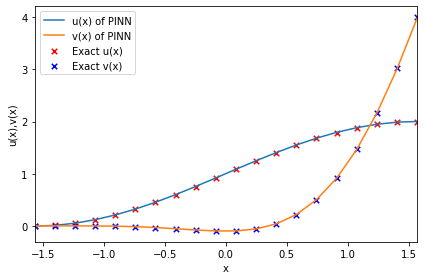

In [3]:
def ElasImag(nIter = 2000, print_period = 1000, plot_period = 1000):
    x_range = np.array([a, b])
    # Network Structure
    layers_U = [1, 40, 40,40,1]
    layers_V = [1, 40, 40,40,1]
    Xx = np.linspace(x_range[0], x_range[1], 100)
    Xx = np.reshape(Xx, [-1, 1])

    f = open("loss_record.txt", "w")

    num_train_tps = 200
    num_test_tps = 20

    model = PhysicsInformedNN(layers_U, layers_V, x_range, f, num_train_tps)

    it_array = []
    loss_array = []
    losses_array = []

    start_time = time.time()
    for it in range(1, nIter+1):
        loss, losses = model.train(Xx, it, it%print_period==0)
        if (it%print_period==0):
            loss_array.append(loss)
            losses_array.append(losses)
            it_array.append(it)
            dt = time.time() - start_time
            print('Time: ', dt)
            start_time = time.time()
            if (it % plot_period == 0 or it == print_period):
                print("Result Plotted...")
                plt.figure()
                x_test, U_test, V_test, _, _, _, _ = model.test(num_test_tps)
                u_exact = 1.0 + np.sin(x_test)
                v_exact = 7/4-(3*np.pi**2)/16+(3*x_test**2)/4+2* np.sin(x_test)-2*x_test*np.cos(x_test)-(x_test*np.cos(x_test)*np.sin(x_test))/2+np.sin(x_test)**2/4
                # u_exact = np.exp(-x_test) * np.cosh(x_test)
                # v_exact = np.exp(-x_test) * np.sinh(x_test)
                UV_test = np.hstack((U_test, V_test))
                UV_exact = np.hstack((u_exact, v_exact))
                UV = np.hstack((x_test, UV_exact, UV_test))
                print(UV)
                l2Uerror = np.linalg.norm(U_test - u_exact, 2) / np.linalg.norm(u_exact, 2)
                l2Verror = np.linalg.norm(V_test - v_exact, 2) / np.linalg.norm(v_exact, 2)
                print('L2U error: ', l2Uerror)
                print('L2V error: ', l2Verror)
                # plt.figure()
                # x_test, t_test = np.meshgrid(x_test, x_test)
                # surf = ax.plot_surface(x_test, y_test, V_test, cmap=cm.coolwarm,
                #                        linewidth=0, antialiased=False)
                # fig.colorbar(surf, shrink=0.5, aspect=5)
                # plt.xlabel('x')
                # plt.ylabel('t')
                # plt.show()
                plt.figure()
                plt.plot(x_test, U_test, label='u(x) of PINN')
                plt.plot(x_test, V_test, label='v(x) of PINN')
                plt.scatter(x_test, u_exact, s=30, c='r', marker='x', label='Exact u(x)')
                plt.scatter(x_test, v_exact, s=30, c='b', marker='x', label='Exact v(x)')
                plt.legend(loc='upper left')
                plt.xlabel('x')
                plt.ylabel('u(x),v(x)')
                plt.xlim(x_range[0], x_range[1])
                plt.tight_layout()
                plt.show()
ElasImag(nIter =20000, print_period =10000, plot_period = 10000)